In [1]:
%matplotlib notebook
import torch
import os
# Turn on CPP Stacktraces for more debug detail
os.environ['TORCH_SHOW_CPP_STACKTRACES'] = "1"
from torch_sym3eig import Sym3Eig as se

In [2]:
import matplotlib.pyplot as plt
from lazy_imports import np
#from lazy_imports import plt
from lazy_imports import loadmat, savemat
plt.rcParams["figure.figsize"] = (4, 4) # (w, h)

In [3]:
import pickle
import math
import pandas as pd

In [4]:
import time

In [5]:
from lazy_imports import itkwidgets
from lazy_imports import itkview
from lazy_imports import interactive
from lazy_imports import ipywidgets
from lazy_imports import pv

In [6]:
from tqdm import tqdm

from util.RegistrationFunc3DCuda import *
from util.SplitEbinMetric3DCuda import *

In [7]:
from disp.vis import vis_tensors, vis_path, disp_scalar_to_file
from disp.vis import disp_vector_to_file, disp_tensor_to_file
from disp.vis import disp_gradG_to_file, disp_gradA_to_file
from disp.vis import view_3d_tensors, tensors_to_mesh
from disp.vis import plot_grid_2d
from data.io import readRaw, ReadScalars, ReadTensors, WriteTensorNPArray, WriteScalarNPArray, readPath3D
from data.convert import GetNPArrayFromSITK, GetSITKImageFromNP

In [8]:
from util.tensors import tens_6_to_tens_3x3, tens_3x3_to_tens_6, get_framework, fractional_anisotropy

In [9]:
# Use get_idty from RegistrationFunc3DCuda instead
#from util.diffeo import get_idty_3d

In [10]:
import scipy.linalg

# Some utility functions

In [11]:
def plot_6_components(np_img, title, figsz=4, filename=None,vmin=-2,vmax=2):
  f, axes = plt.subplots(3, 2, figsize=(figsz*2,figsz*3))
  im0=axes[0,0].imshow(np_img[...,0],vmin=vmin,vmax=vmax)
  axes[0,0].set_title(f'{title} 0,0')
  im1=axes[0,1].imshow(np_img[...,1],vmin=vmin,vmax=vmax)
  axes[0,1].set_title(f'{title} 0,1')
  im2=axes[1,0].imshow(np_img[...,2],vmin=vmin,vmax=vmax)
  axes[1,0].set_title(f'{title} 0,2')
  im3=axes[1,1].imshow(np_img[...,3],vmin=vmin,vmax=vmax)
  axes[1,1].set_title(f'{title} 1,1')
  im4=axes[2,0].imshow(np_img[...,4],vmin=vmin,vmax=vmax)
  axes[2,0].set_title(f'{title} 1,2')
  im5=axes[2,1].imshow(np_img[...,5],vmin=vmin,vmax=vmax)
  axes[2,1].set_title(f'{title} 2,2')
  plt.tight_layout()

  cbar=f.colorbar(im0, ax=axes[0,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
  cbar.ax.tick_params(labelsize=6)
  cbar=f.colorbar(im1, ax=axes[0,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
  cbar.ax.tick_params(labelsize=6)
  cbar=f.colorbar(im2, ax=axes[1,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
  cbar.ax.tick_params(labelsize=6)
  cbar=f.colorbar(im3, ax=axes[1,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
  cbar.ax.tick_params(labelsize=6)
  cbar=f.colorbar(im4, ax=axes[2,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
  cbar.ax.tick_params(labelsize=6)
  cbar=f.colorbar(im5, ax=axes[2,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
  cbar.ax.tick_params(labelsize=6)
  
  if filename:
    f.savefig(filename, bbox_inches='tight', pad_inches=0, 
              dpi=400, transparent=True)

  return(f,axes)

def plot_3x3_components(np_img, title, figsz=4, filename=None,vmin=-2,vmax=2):
  f, axes = plt.subplots(3, 2, figsize=(figsz*2,figsz*3))
  im0=axes[0,0].imshow(np_img[...,0,0],vmin=vmin,vmax=vmax)
  axes[0,0].set_title(f'{title} 0,0')
  im1=axes[0,1].imshow(np_img[...,0,1],vmin=vmin,vmax=vmax)
  axes[0,1].set_title(f'{title} 0,1')
  im2=axes[1,0].imshow(np_img[...,0,2],vmin=vmin,vmax=vmax)
  axes[1,0].set_title(f'{title} 0,2')
  im3=axes[1,1].imshow(np_img[...,1,1],vmin=vmin,vmax=vmax)
  axes[1,1].set_title(f'{title} 1,1')
  im4=axes[2,0].imshow(np_img[...,1,2],vmin=vmin,vmax=vmax)
  axes[2,0].set_title(f'{title} 1,2')
  im5=axes[2,1].imshow(np_img[...,2,2],vmin=vmin,vmax=vmax)
  axes[2,1].set_title(f'{title} 2,2')
  plt.tight_layout()

  cbar=f.colorbar(im0, ax=axes[0,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
  cbar.ax.tick_params(labelsize=6)
  cbar=f.colorbar(im1, ax=axes[0,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
  cbar.ax.tick_params(labelsize=6)
  cbar=f.colorbar(im2, ax=axes[1,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
  cbar.ax.tick_params(labelsize=6)
  cbar=f.colorbar(im3, ax=axes[1,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
  cbar.ax.tick_params(labelsize=6)
  cbar=f.colorbar(im4, ax=axes[2,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
  cbar.ax.tick_params(labelsize=6)
  cbar=f.colorbar(im5, ax=axes[2,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
  cbar.ax.tick_params(labelsize=6)
  
  if filename:
    f.savefig(filename, bbox_inches='tight', pad_inches=0, 
              dpi=400, transparent=True)

  return(f,axes)


# Setup Torch device defaults

In [12]:
cuda_dev = 'cuda:0'
device = torch.device(cuda_dev if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type('torch.cuda.DoubleTensor' if torch.cuda.is_available() else 'torch.DoubleTensor')
print(device)

cuda:0


# Display Configuration

In [13]:
# from colorbrewer2, sequential 9 values pasted together YlGnBu (reverse order) then YlOrRd
# EXCEPT THESE ARE NOT PRINT FRIENDLY OR PHOTOCOPY SAFE!!!
# But skip the yellows in the middle -- too light
geo_colors = ['tab:red', 'tab:pink', 'tab:orange', 'tab:blue', 'tab:purple', 'tab:green', 'tab:cyan']
eul_colors = ['k', 'tab:gray', 'tab:brown', 'm', 'y', 'tab:olive', 'maroon']
#interp_colors = ['#081d58', '#253494', '#225ea8', '#1d91c0', '#41b6c4', '#7fcdbb', '#c7e9b4', '#edf8b1', '#ffffd9',
#                 '#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']
interp_colors = ['#081d58', '#253494', '#225ea8', '#1d91c0', '#41b6c4', '#7fcdbb', '#c7e9b4',
                 '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']
# Compromise, use 5 class YlGnBu (reverse order) and YlOrBr again leaving out yellow
#interp_colors = ['#253494', '#2c7fb8', '#41b6c4', '#a1dab4', '#fed98e', '#fe9929', '#d95f0e', '#993404']

case_color='tab:orange'
ctrl_color='tab:blue'
train_color='tab:blue'
test_color='tab:orange'

ncycle = 100 # Number of colors 
# winter
cycle_colors = [plt.get_cmap('copper')(1. * i/ncycle) for i in range(ncycle)]

#plt.rc('axes', 
#       prop_cycle=(cycler('color', new_colors) + 
#                   cycler('linestyle', ['-', '--', ':', '-.'])))

plt.rc('axes', 
       prop_cycle=(plt.cycler('color', cycle_colors)))


# Setup for Reading Results

In [14]:
sim_name = 'sim1'
datadir=f'/usr/sci/projects/abcd/simdata/annulus/{sim_name}/'
atlasdir=f'/usr/sci/projects/abcd/simresults/annulus/{sim_name}/'
ann_prefix='metpy_annulus_3D_'
ann1_tens_file = f'{datadir}/{ann_prefix}1_tens.nhdr'
ann1_mask_file = f'{datadir}/{ann_prefix}1_mask.nhdr'
ann1_eval_file = f'{datadir}/{ann_prefix}1_eval.nhdr'
ann2_tens_file = f'{datadir}/{ann_prefix}2_tens.nhdr'
ann2_mask_file = f'{datadir}/{ann_prefix}2_mask.nhdr'
ann2_eval_file = f'{datadir}/{ann_prefix}2_eval.nhdr'

ann1_tensor_np = ReadTensors(f'{atlasdir}/{ann_prefix}1_scaled_orig_tensors_v2.nhdr')
ann1_mask_np = ReadScalars(f'{atlasdir}/{ann_prefix}1_orig_mask.nhdr')
ann1_img_np = ReadScalars(f'{atlasdir}/{ann_prefix}1_T1_flip_y.nhdr')
ann1_alpha_np = ReadScalars(f'{atlasdir}/{ann_prefix}1_alpha.nhdr')
ann2_tensor_np = ReadTensors(f'{atlasdir}/{ann_prefix}2_scaled_orig_tensors_v2.nhdr')
ann2_mask_np = ReadScalars(f'{atlasdir}/{ann_prefix}2_orig_mask.nhdr')
ann2_img_np = ReadScalars(f'{atlasdir}/{ann_prefix}2_T1_flip_y.nhdr')
ann2_alpha_np = ReadScalars(f'{atlasdir}/{ann_prefix}2_alpha.nhdr')

mask_all_np = np.ones_like(ann1_mask_np)

In [15]:
ann1_orig_tens = ReadTensors(ann1_tens_file)
ann1_orig_mask = ReadScalars(ann1_mask_file)
#ann1_orig_tens = ReadTensors(f'{atlasdir}/{ann_prefix}1_scaled_tensors.nhdr')
ann1_orig_tens[0,0,0]

array([1., 0., 0., 1., 0., 1.])

<IPython.core.display.Javascript object>


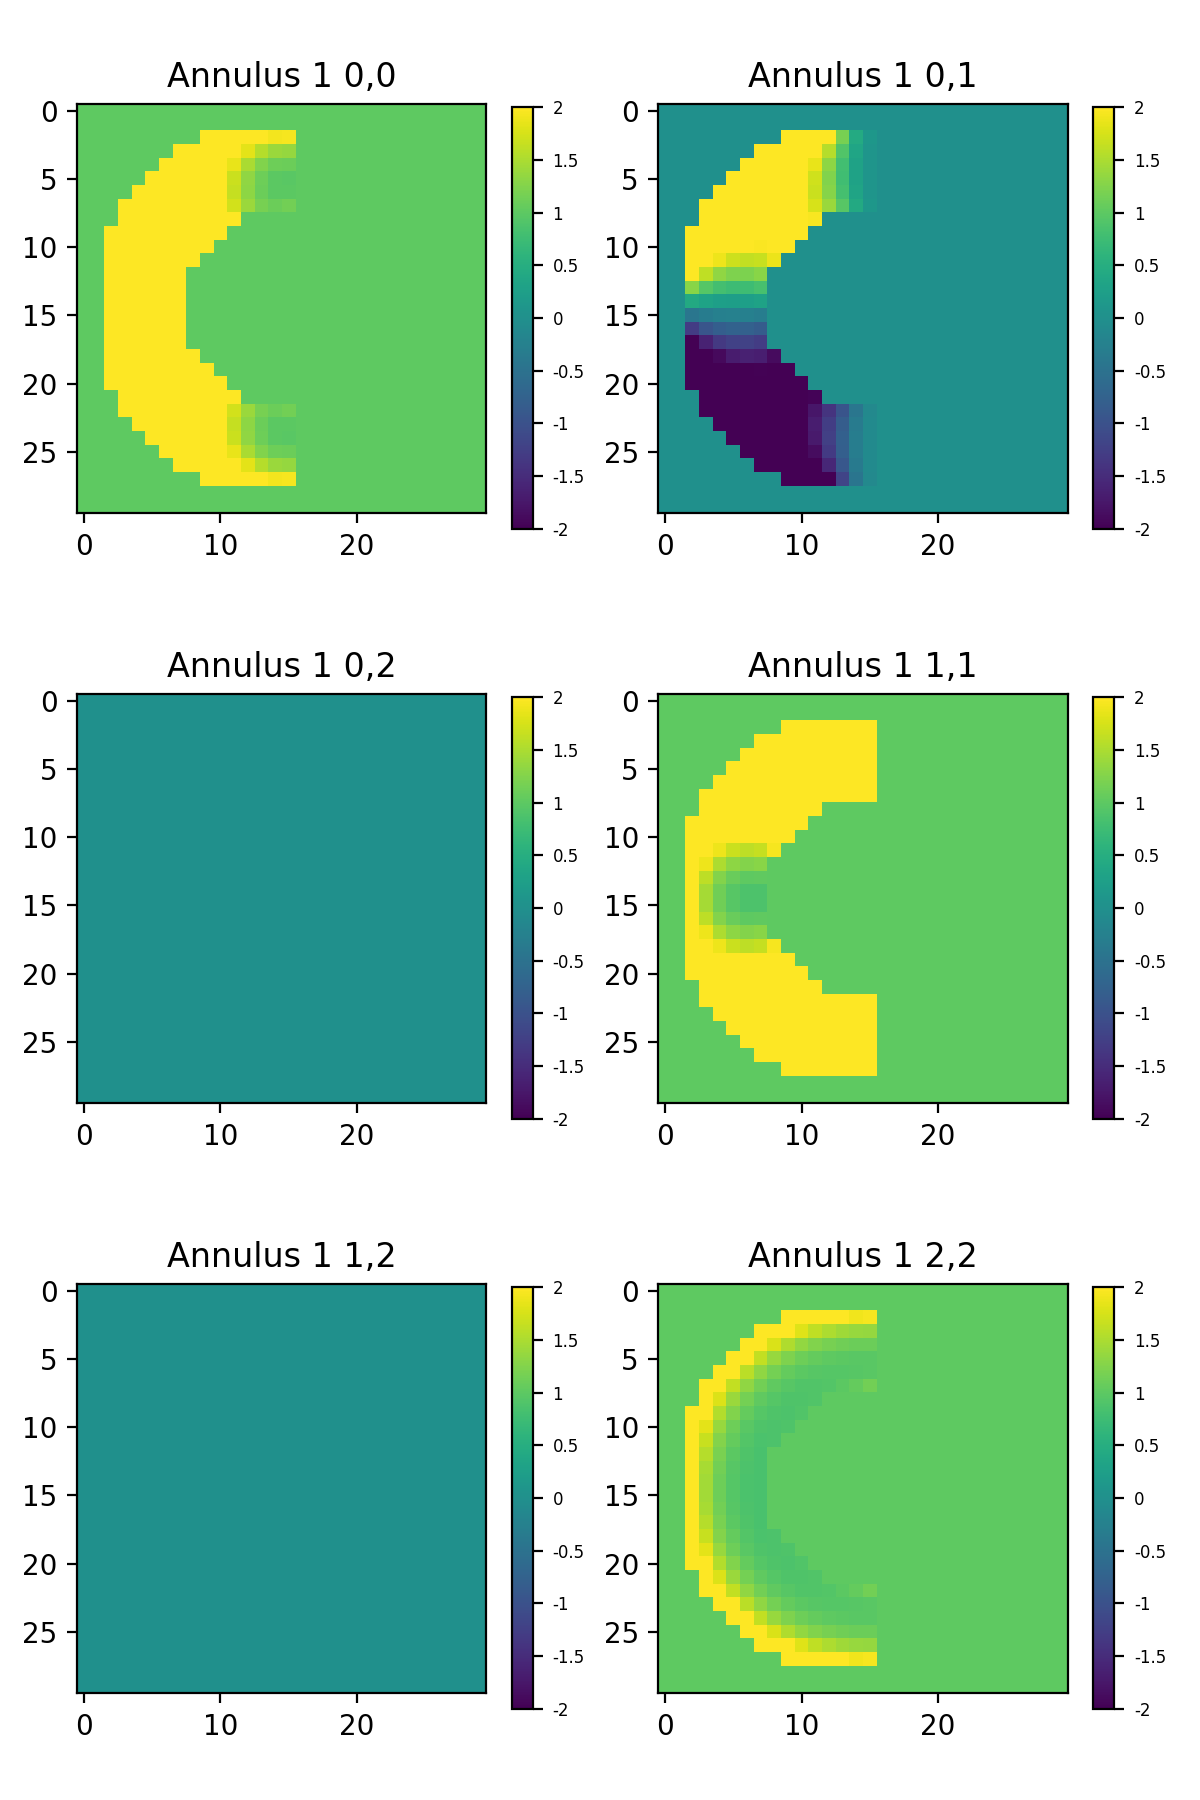

<IPython.core.display.Javascript object>


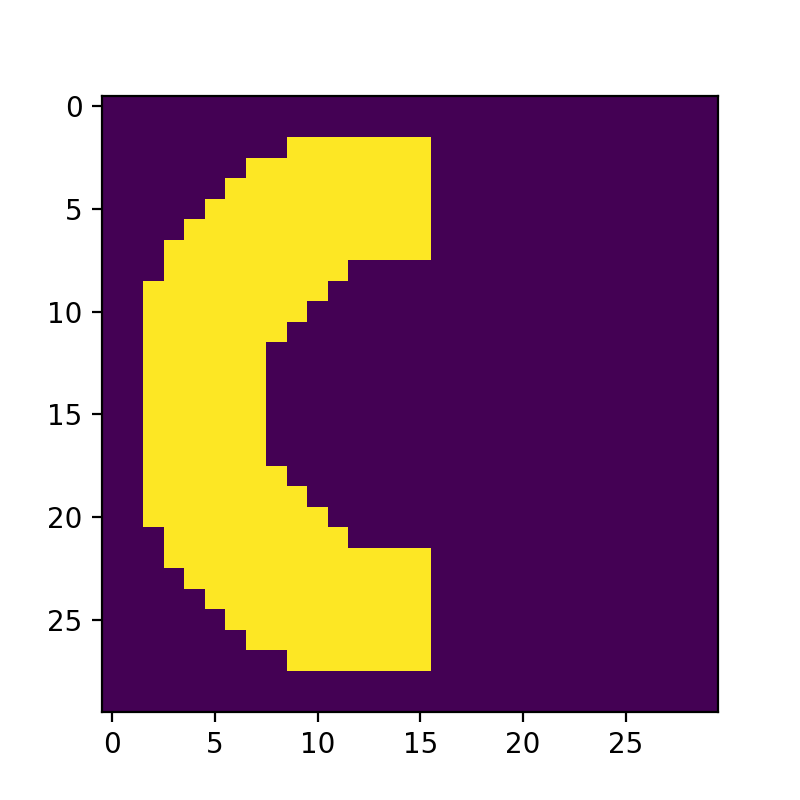

<IPython.core.display.Javascript object>


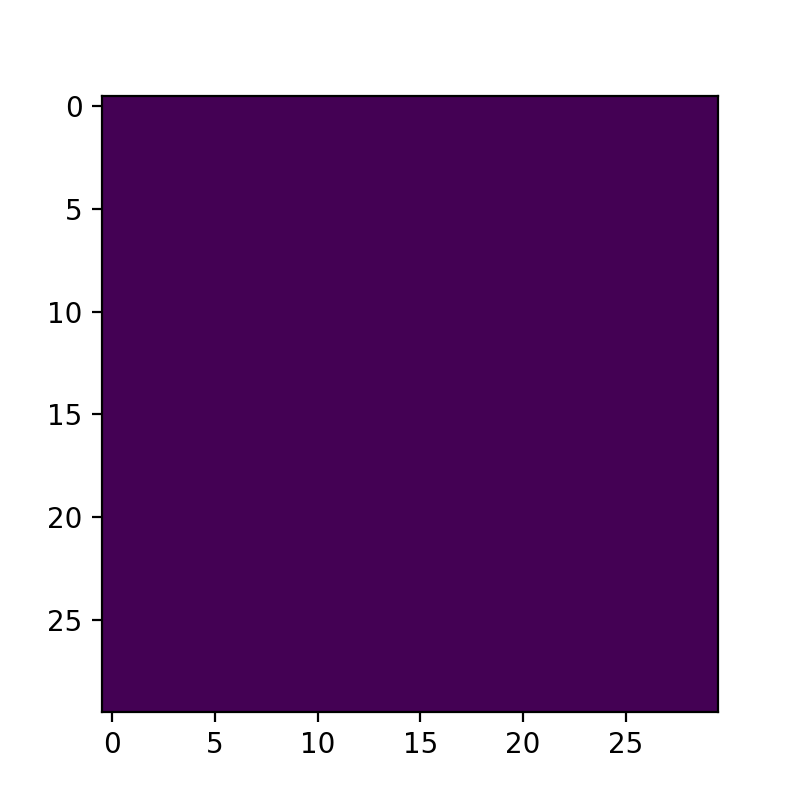

In [16]:
#f, axes = plot_6_components(ann1_orig_tens[:,::-1,2], 'Annulus 1',3)
f, axes = plot_6_components(ann1_tensor_np[:,::-1,2], 'Annulus 1',3)
plt.figure()
plt.imshow(ann1_orig_mask[:,::-1,2])
alt_mask = np.zeros_like(ann1_mask_np)
alt_mask[ann1_orig_tens[...,0] > 1] = 1
plt.figure()
plt.imshow(alt_mask[:,::-1,2]-ann1_orig_mask[:,::-1,2])

# Setup for Writing Results

In [17]:
#figdir = '/usr/sci/projects/abcd/Figures/annulus/before_evec_fix/'
#figdir = '/usr/sci/projects/abcd/Figures/annulus/after_evec_bug_only/'
#figdir = '/usr/sci/projects/abcd/Figures/annulus/after_evec_fix/'
#figdir = '/usr/sci/projects/abcd/Figures/annulus/after_second_evec_fix/'
#figdir = '/usr/sci/projects/abcd/Figures/annulus/with_scipy_logm/'
figdir = '/usr/sci/projects/abcd/Figures/annulus/with_fixed_logm/'
save_figs = False

# Evaluate how we capture anisotropy differences
  1. Compare metric from 2 annuli before registration
     - Log map
     - Ebin distance
  2. Register 2 annuli
  3. Compare metric from 2 annuli after registration
  4. Look at results after registration
     - Diffeomorphism
     - FA
     - Log map
     - Ebin distance
  5. Compute atlas for 2 annuli
  6. Look at results after atlas building
     - Diffeomorphisms
     - FA
     - Log map
     - Ebin distance


## 1. Before Registration

In [18]:
def dbg_batch_cholesky(tens):
  # from https://stackoverflow.com/questions/60230464/pytorch-torch-cholesky-ignoring-exception
  # will get NaNs instead of exception where cholesky is invalid
  fw, fw_name = get_framework(tens)
  L = fw.zeros_like(tens)

  if fw_name == 'numpy':
    for i in range(tens.shape[-1]):
      for j in range(i+1):
        s = 0.0
        for k in range(j):
          s = s + L[...,i,k] * L[...,j,k]

        L[...,i,j] = fw.sqrt((tens[...,i,i] - s).clip(min=1.0e-15)) if (i == j) else \
                        (1.0 / L[...,j,j].copy().clip(min=1.0e-15) * (tens[...,i,j] - s))
  else:
    for i in range(tens.shape[-1]):
      for j in range(i+1):
        s = 0.0
        for k in range(j):
          s = s + L[...,i,k].clone() * L[...,j,k].clone()

        L[...,i,j] = fw.sqrt((tens[...,i,i] - s).clamp(min=1.0e-15)) if (i == j) else \
                        (1.0 / L[...,j,j].clone().clamp(min=1.0e-15) * (tens[...,i,j] - s))
  return L


def dbg_scipy_logm_invB_A(B, A):
#     inputs: A/B.shape = [hxwxd, 3, 3]
#     output: shape = [hxwxd, 3, 3]
    # To convert back
    # zDirection = i % d
    # yDirection = (i / d) % w
    # xDirection = i / (w * d)
    if len(B.shape) > 3 or len(A.shape) > 3:
      print('ERROR, expecting input to logm_invB_A to be 3D with shape [hxwhd, 3, 3]')
    G = torch.linalg.cholesky(B)
    #G = dbg_batch_cholesky(B)
    nonpsd_idx = torch.where(torch.isnan(G))
    if len(nonpsd_idx[0]) > 0:
      print(len(nonpsd_idx[0]), 'non psd entries found in logm_invB_A', nonpsd_idx)
    for i in range(len(nonpsd_idx[0])):
      G[nonpsd_idx[0][i]] = torch.eye((3)).double().to(device=B.device)

    # KMC comment out following 4 lines and see if pseudo inverse sufficient instead
    det_G = torch.det(G)
    inv_G = torch.zeros_like(G)
    inv_G[det_G>0.] = torch.pinverse(G[det_G>0.])
    inv_G[det_G<=0.] = torch.eye((3)).double().to(device=B.device)
    #inv_G = torch.pinverse(G)
    
    W = torch.einsum("...ij,...jk,...lk->...il", inv_G, A, inv_G)
    
    my_logm = np.vectorize(scipy.linalg.logm,signature='(m,m)->(m,m)')
    logm_W = torch.from_numpy(my_logm(W.cpu().detach().numpy())).double().to(device=B.device)
    return(logm_W)


def dbg_logm_invB_A(B, A):
#     inputs: A/B.shape = [hxwxd, 3, 3]
#     output: shape = [hxwxd, 3, 3]
    # To convert back
    # zDirection = i % d
    # yDirection = (i / d) % w
    # xDirection = i / (w * d)
    if len(B.shape) > 3 or len(A.shape) > 3:
      print('ERROR, expecting input to logm_invB_A to be 3D with shape [hxwhd, 3, 3]')
    G = torch.linalg.cholesky(B)
    #G = dbg_batch_cholesky(B)
    nonpsd_idx = torch.where(torch.isnan(G))
    if len(nonpsd_idx[0]) > 0:
      print(len(nonpsd_idx[0]), 'non psd entries found in logm_invB_A', nonpsd_idx)
    for i in range(len(nonpsd_idx[0])):
      G[nonpsd_idx[0][i]] = torch.eye((3)).double().to(device=B.device)

    # KMC comment out following 4 lines and see if pseudo inverse sufficient instead
    det_G = torch.det(G)
    inv_G = torch.zeros_like(G)
    inv_G[det_G>0.] = torch.pinverse(G[det_G>0.])
    inv_G[det_G<=0.] = torch.eye((3)).double().to(device=B.device)
    #inv_G = torch.pinverse(G)
    
    W = torch.einsum("...ij,...jk,...lk->...il", inv_G, A, inv_G)
    

    #W_sym = (W + torch.transpose(W,len(W.shape)-2,len(W.shape)-1))/2
    # The eigenvector computation becomes inaccurate for matrices close to identity
    # Set those closer than float machine eps from identity matrix to identity
    #W[(torch.abs(W[:]-torch.eye((3)))<1.1921e-7).sum(dim=(1,2))<9] = torch.eye((3))
    print('W',W)
    lamda, Q = se.apply(W)
    print('se.apply')
    print('evecs',Q)
    print('evals',lamda)
    
    #lamda, Q = torch.symeig(W.cpu(), eigenvectors=True)
    #print('torch.symeig')
    #print('evecs',Q)
    #print('evals',lamda)

    
    # Get consistent eigenvector sign following approach of:
    # https://www.osti.gov/servlets/purl/920802
    S = torch.ones_like(lamda)
    lQ0outer = torch.einsum('...i,...i,...j->...ij',lamda[...,0].reshape((-1,1)),Q[...,0],Q[...,0])
    lQ1outer = torch.einsum('...i,...i,...j->...ij',lamda[...,1].reshape((-1,1)),Q[...,1],Q[...,1])
    lQ2outer = torch.einsum('...i,...i,...j->...ij',lamda[...,2].reshape((-1,1)),Q[...,2],Q[...,2])
    Y0 = W - lQ1outer - lQ2outer
    Y1 = W - lQ0outer - lQ2outer
    Y2 = W - lQ0outer - lQ1outer
    q0y0 = torch.einsum('...i,...i->...',Q[...,0],Y0[...,0])
    q0y1 = torch.einsum('...i,...i->...',Q[...,0],Y0[...,1])
    q0y2 = torch.einsum('...i,...i->...',Q[...,0],Y0[...,2])
    S[...,0] = torch.sign(q0y0) * q0y0 * q0y0 + torch.sign(q0y1) * q0y1 * q0y1 + torch.sign(q0y2) * q0y2 * q0y2
    q1y0 = torch.einsum('...i,...i->...',Q[...,1],Y1[...,0])
    q1y1 = torch.einsum('...i,...i->...',Q[...,1],Y1[...,1])
    q1y2 = torch.einsum('...i,...i->...',Q[...,1],Y1[...,2])
    S[...,1] = torch.sign(q1y0) * q1y0 * q1y0 + torch.sign(q1y1) * q1y1 * q1y1 + torch.sign(q1y2) * q1y2 * q1y2
    q2y0 = torch.einsum('...i,...i->...',Q[...,2],Y2[...,0])
    q2y1 = torch.einsum('...i,...i->...',Q[...,2],Y2[...,1])
    q2y2 = torch.einsum('...i,...i->...',Q[...,2],Y2[...,2])
    S[...,2] = torch.sign(q2y0) * q2y0 * q2y0 + torch.sign(q2y1) * q2y1 * q2y1 + torch.sign(q2y2) * q2y2 * q2y2
    
    #lamda, Q = se.apply(W_sym)
    #log_lamda = torch.zeros((*lamda.shape, lamda.shape[-1]),dtype=torch.double)
    #log_lamda = torch.diag_embed(torch.log(lamda))
    #log_lamda = torch.diag_embed(torch.log(torch.where(lamda>1.0e-20,lamda,1.0e-20)))
    log_lamda = torch.diag_embed(torch.log(lamda.clamp(min=1.0e-15)))
    # include S here to use best signs for Q
    V = torch.einsum('...ji,...jk,...k->...ik', inv_G, Q, torch.sign(S))
     #inv_V = torch.inverse(V)
    # KMC comment out following 4 lines and see if pseudo inverse sufficient instead
    det_V = torch.det(V)
    inv_V = torch.zeros_like(V)
    inv_V[det_V>0.] = torch.pinverse(V[det_V>0.])
    inv_V[det_V<=0.] = torch.eye((3)).double().to(device=B.device)
    #try:
    #  inv_V = torch.pinverse(V)
    #except:
    #  det_V = torch.det(V)
    #  inv_V = torch.zeros_like(V)
    #  inv_V[det_V>0.] = torch.inverse(V[det_V>0.])
    #  inv_V[det_V<=0.] = torch.eye((3)).double().to(device=B.device)
    #print(' where inv_V > 1e22 ', torch.where(inv_V > 1e22))
    #print('logm_invB_A, B NaN?', B.isnan().any(), 'A NaN?', A.isnan().any(), 'inv_G NaN?', inv_G.isnan().any(),
    #      'lamda NaN?', lamda.isnan().any(), 'log_lamda NaN?', log_lamda.isnan().any(), 'Q NaN?', Q.isnan().any(), 'inv_V NaN?', inv_V.isnan().any())
    #print('logm_invB_A, B Inf?', B.isinf().any(), 'A Inf?', A.isinf().any(), 'inv_G Inf?', inv_G.isinf().any(),
    #      'lamda Inf?', lamda.isinf().any(), 'log_lamda Inf?', log_lamda.isinf().any(), 'Q Inf?', Q.isinf().any(), 'inv_V Inf?', inv_V.isinf().any())
    #print('logm_invB_A, max(G)', torch.max(G), 'max(inv_G)', torch.max(inv_G),
    #      'max(V)', torch.max(V), 'max(inv_V)', torch.max(inv_V), 'max(Q)', torch.max(Q),
    #      'max(log_lamda)', torch.max(log_lamda))
    #return torch.einsum('...ij,...jk,...kl->...il', V, log_lamda, inv_V)
    
    result = torch.einsum('...ij,...jk,...kl->...il', V, log_lamda, inv_V)

    #ill_cond_idx = torch.where(inv_V > 1e16)
    ill_cond_idx = (inv_V > 1e20).nonzero().reshape(-1)
    #num_ill_cond = len(ill_cond_idx[0])
    num_ill_cond = len(ill_cond_idx)
    if num_ill_cond > 0:
      #dbg_ill = [ill_cond_idx[c][0] for c in range(len(ill_cond_idx))]
      dbg_ill = ill_cond_idx[0]
      #print('Replacing', num_ill_cond, 'ill-conditioned results in logm_invB_A with cpu version. First index is', dbg_ill)
      # TODO this should be batchable
      #for ii in range(num_ill_cond):
      #  result[ill_cond_idx[0][ii]] = cpu_logm_invB_A(B[ill_cond_idx[0][ii]],A[ill_cond_idx[0][ii]])
      #result[ill_cond_idx] = cpu_logm_invB_A(B[ill_cond_idx],A[ill_cond_idx])
      print('Replacing', num_ill_cond, 'ill-conditioned results in logm_invB_A with identity. First index is', dbg_ill)
      result[ill_cond_idx] = torch.eye((3)).double().to(device=B.device)
    
    return result


def dbg_inv_RieExp(g0, g1, a):  # g0,g1: two tensors of size (s,t,...,3,3), where g0\neq 0
    '''this function is to calculate the inverse Riemannian exponential of g1 in the image of the maximal domain of the Riemannian exponential at g0
    '''
    print('g0,g1 shape:',g0.shape, g1.shape)
    #print('entering inv_RieExp, max(g0)', torch.max(g0), 'max(g1)', torch.max(g1))
    n = g1.size(-1)
    #print('entering inv_RieExp, g0 NaN?', g0.isnan().any(), 'g1 NaN?', g1.isnan().any())
    #print('entering inv_RieExp, g0 Inf?', g0.isinf().any(), 'g1 Inf?', g1.isinf().any())
    #     matrix multiplication
    inv_g0_g1 = torch.einsum("...ik,...kj->...ij", torch.pinverse(g0), g1)  # (s,t,...,3,3)
    #inv_g0_g1 = make_pos_def(torch.einsum("...ik,...kj->...ij", torch.inverse(g0), g1),None, 1.0e-10)  # (s,t,...,3,3)
    print('inv_RieExp, max(inv_g0_g1)', torch.max(inv_g0_g1), 'max(inverse(g0))', torch.max(torch.inverse(g0)))
    #print('inv_RieExp after make_pos_def, g0 NaN?', g0.isnan().any(), 'g1 NaN?', g1.isnan().any(),'inv_g0_g1 NaN?',
    #      inv_g0_g1.isnan().any())
    #print('inv_RieExp after make_pos_def, g0 Inf?', g0.isinf().any(), 'g1 Inf?', g1.isinf().any(),'inv_g0_g1 Inf?',
    #      inv_g0_g1.isinf().any())
    
    def get_u_g0direction(g0, inv_g0_g1):  # (-1,3,3) first reshape g0,g1,inv_g..
        #         permute
        inv_g0_g1 = torch.einsum("...ij->ij...", inv_g0_g1)  # (3,3,-1)
        s = inv_g0_g1[0, 0].clamp(min=1.0e-15)  # (-1)
        u = 4 / n * (s ** (n / 4) - 1) * torch.einsum("...ij->ij...", g0)  # (-1)@(3,3,-1) -> (3,3,-1)

        #print('inv_RieExp.get_u_g0direction, g0 NaN?', g0.isnan().any(), 'inv_g0_g1 NaN?', inv_g0_g1.isnan().any(),
        #      's NaN?', s.isnan().any(), 'u NaN?', u.isnan().any())
        #print('inv_RieExp.get_u_g0direction, g0 Inf?', g0.isinf().any(), 'inv_g0_g1 Inf?', inv_g0_g1.isinf().any(),
        #      's Inf?', s.isinf().any(), 'u Inf?', u.isinf().any())
        print('inv_RieExp get_u_g0direction max(u)', torch.max(u), 'max(s)', torch.max(s))
        return u.permute(2, 0, 1)  # (-1,3,3)

    def get_u_ng0direction(g0, g1, inv_g0_g1, a):  # (-1,3,3) first reshape g0,g1,inv_g..
        det_threshold=1e-11
        where_below = torch.where(torch.det(g0)<=det_threshold)
        num_below = len(where_below[0])
        if num_below > 0:
          print('inv_RieExp num det(g0) below thresh:', num_below)
        # TODO if this works, move to get_karcher_mean  
        #g0[torch.det(g0)<=det_threshold] = torch.eye((3))
        # It moved the problem in unexpected ways
        K = dbg_logm_invB_A(g0, g1)
        KTrless = K - torch.einsum("...ii,kl->...kl", K, torch.eye(n, dtype=torch.double, device=g0.device)) / n  # (-1,3,3)
        #         AA^T
        theta = ((1 / a * torch.einsum("...ik,...ki->...", KTrless, KTrless)).clamp(min=1.0e-15).sqrt() / 4).clamp(min=1.0e-15)  # (-1)
        gamma = torch.det(g1).pow(1 / 4) / (torch.det(g0).clamp(min=1.0e-15).pow(1 / 4))  # (-1)

        A = 4 / n * (gamma * torch.cos(theta) - 1)  # (-1)
        B = 1 / theta * gamma * torch.sin(theta)
        u = A * torch.einsum("...ij->ij...", g0) + B * torch.einsum("...ik,...kj->ij...", g0, KTrless)  # (-1)@(3,3,-1) -> (3,3,-1)
        #print('inv_RieExp.get_u_ng0direction, g0 NaN?', g0.isnan().any(), 'g1 NaN?', g1.isnan().any(),
        #      'inv_g0_g1 NaN?', inv_g0_g1.isnan().any(), 'K NaN?', K.isnan().any(),'theta NaN?', theta.isnan().any(),
        #      'gamma NaN?', gamma.isnan().any(), 'A NaN?', A.isnan().any(), 'B NaN?', B.isnan().any())
        #print('inv_RieExp.get_u_ng0direction, g0 Inf?', g0.isinf().any(), 'g1 Inf?', g1.isinf().any(),
        #      'inv_g0_g1 Inf?', inv_g0_g1.isinf().any(), 'K Inf?', K.isinf().any(),'theta Inf?', theta.isinf().any(),
        #      'gamma Inf?', gamma.isinf().any(), 'A Inf?', A.isinf().any(), 'B Inf?', B.isinf().any())
        #di=1398389
        #di=1365089
        #di=1147366 # inv_v > 1e22
        #di=26131
        #if g0.shape[0] > di:
        #  print('\nget_u_ng0direction \ng0[',di,'] =\n', g0[di], '\ng1[',di,'] =\n', g1[di],
        #        '\nK[',di,'] =\n', K[di], '\nKTrless[',di,'] =\n', KTrless[di],
        #        '\ntheta[',di,'] =\n', theta[di],'\ngamma[',di,'] =\n', gamma[di],
        #        '\nA[',di,'] =\n', A[di],'\nB[',di,'] =\n', B[di],
        #        '\nA term[',di,'] =\n', (A * torch.einsum("...ij->ij...", g0)).permute(2,0,1)[di],
        #        '\nB term[',di,'] =\n', (B * torch.einsum("...ik,...kj->ij...", g0, KTrless)).permute(2,0,1)[di])
        where_huge = torch.where(K > 6e14)
        if len(where_huge[0]) > 0:
          print('num K huge', len(where_huge[0]), 'first huge', where_huge[0][0], where_huge[1][0], where_huge[2][0])

        #print(' where u > 1e15 ', torch.where(u > 1e15))
        #print('inv_RieExp get_u_ng0direction max(u)', torch.max(u), 'max(K)', torch.max(K), 'max(KTrless)', torch.max(KTrless)
        #      , 'max(theta)', torch.max(theta), 'max(gamma)', torch.max(gamma), 'max(A)', torch.max(A), 'max(B)', torch.max(B))
        return u.permute(2, 0, 1)  # (-1,3,3)

    #inv_g0_g1_trless = inv_g0_g1 - torch.einsum("...ii,kl->...kl", inv_g0_g1, torch.eye(n, dtype=torch.double, device='cuda:0')) / n  #
    inv_g0_g1_trless = inv_g0_g1 - torch.einsum("...ii,kl->...kl", inv_g0_g1, torch.eye(n, dtype=torch.double, device=g0.device))  # (s,t,...,2,2)
    norm0 = torch.einsum("...ij,...ij->...", inv_g0_g1_trless, inv_g0_g1_trless).reshape(-1)  # (-1)

    # find the indices for which the entries are 0s and non0s
    Ind0 = (norm0 <= 1e-12).nonzero().reshape(-1)  # using squeeze results in [1,1]->[]
    Indn0 = (norm0 > 1e-12).nonzero().reshape(-1)

    u = torch.zeros(g0.reshape(-1, n, n).size(), dtype=torch.double, device=g0.device)  # (-1,3,3)
    if len(Indn0) == 0:
        print('all get_u_g0_direction')
        u = get_u_g0direction(g0.reshape(-1, n, n), inv_g0_g1.reshape(-1, n, n))
        #di=1398389
        #di=1365089
        #di=1147366 # inv_v > 1e22
        #di=26131
        #if u.shape[0] > di:
        #    print('\nget_u_g0direction u[',di,'] =\n', u[di])
    elif len(Ind0) == 0:
        print('all get_u_ng0direction')
        u = get_u_ng0direction(g0.reshape(-1, n, n), g1.reshape(-1, n, n), inv_g0_g1.reshape(-1, n, n), a)
        #di=1398389
        #di=1365089
        #di=1147366 # inv_v > 1e22
        #di=26131
        #if u.shape[0] > di:
        #    print('\nget_u_ng0direction u[',di,'] =\n', u[di])
    else:
        print(len(Ind0),'get_u_g0_direction')
        u[Ind0] = get_u_g0direction(g0.reshape(-1, n, n)[Ind0], inv_g0_g1.reshape(-1, n, n)[Ind0])
        u[Indn0] = get_u_ng0direction(g0.reshape(-1, n, n)[Indn0], g1.reshape(-1, n, n)[Indn0], inv_g0_g1.reshape(-1, n, n)[Indn0], a)
        #di=1398389
        #di=1365089
        #di=1147366 # inv_v > 1e22
        #di=26131
        #if u.shape[0] > di:
        #    print('\nget_u_g0direction get_u_ng0direction u[',di,'] =\n', u[di])
    
    #print('exiting inv_RieExp, g0 NaN?', g0.isnan().any(), 'g1 NaN?', g1.isnan().any(),'inv_g0_g1 NaN?',
    #      inv_g0_g1.isnan().any(),'u NaN?', u.isnan().any())
    #print('exiting inv_RieExp, g0 Inf?', g0.isinf().any(), 'g1 Inf?', g1.isinf().any(),'inv_g0_g1 Inf?',
    #      inv_g0_g1.isinf().any(),'u Inf?', u.isinf().any())
    return u.reshape(g1.size())


def dbg_inv_RieExp_extended(g0, g1, a):  # g0, g1: (s,t,...,3,3)
    print('entering inv_RieExp_extended, g0 NaN?', g0.isnan().any(), 'g1 NaN?', g1.isnan().any())
    print('entering inv_RieExp_extended, g0 Inf?', g0.isinf().any(), 'g1 Inf?', g1.isinf().any())

    size = g0.size()
    g0, g1 = g0.reshape(-1, *size[-2:]), g1.reshape(-1, *size[-2:])  # (-1,3,3)
    detg0 = torch.det(g0)

    Ind_g0_is0 = (detg0 == 0).nonzero().reshape(-1)
    Ind_g0_isnot0 = (detg0 != 0).nonzero().reshape(-1)

    if len(Ind_g0_isnot0) == 0:  # g0x are 0s for all x
        print('all g0x are 0s')
        u = g1 * 4 / g0.size(-1)
    elif len(Ind_g0_is0) == 0:  # g0x are PD for all x
        print('all g0x are PD')
        u = dbg_inv_RieExp(g0, g1, a)
    else:
        u = torch.zeros(g0.size(), dtype=torch.double, device=g0.device)
        print(len(Ind_g0_is0), 'g0x are 0s')
        u[Ind_g0_is0] = g1[Ind_g0_is0] * 4 / g0.size(-1)
        u[Ind_g0_isnot0] = inv_RieExp(g0[Ind_g0_isnot0], g1[Ind_g0_isnot0], a)
    #print('exiting inv_RieExp_extended, g0 NaN?', g0.isnan().any(), 'g1 NaN?', g1.isnan().any(), 'u NaN?', u.isnan().any())
    #print('exiting inv_RieExp_extended, g0 Inf?', g0.isinf().any(), 'g1 Inf?', g1.isinf().any(), 'u Inf?', u.isinf().any())

    return u.reshape(size)

def Ebin_inner_prod(g0,h,k, mask):
  # h,k are tangent vectors ie h = inv_RieExp_Extended(g0,g1)
  g0_inv = torch.inverse(g0)
  vol_g0 = torch.sqrt(torch.abs(torch.det(g0)))
  prod = torch.einsum('...ij,...jk,...kl,...lm->...im',g0_inv, h, g0_inv, k)
  trace_prod = torch.einsum('...ii->...',prod) # Take trace of prod
  return(trace_prod * vol_g0 * mask)


In [19]:
%%time
ann1_full = tens_6_to_tens_3x3(ann1_tensor_np)
ann2_full = tens_6_to_tens_3x3(ann2_tensor_np)
ann1_met = torch.inverse(torch.from_numpy(ann1_full).double().permute(2,1,0,3,4).to(device))
ann2_met = torch.inverse(torch.from_numpy(ann2_full).double().permute(2,1,0,3,4).to(device))
ann1_ann2_dist = Squared_distance_Ebin_field(ann1_met, ann2_met, 1.0/3.0, torch.from_numpy(mask_all_np).double().permute(2,1,0).to(device))
ann1_ann1_logmap = inv_RieExp_extended(ann1_met, ann1_met, 1.0/3.0)
ann2_ann2_logmap = inv_RieExp_extended(ann2_met, ann2_met, 1.0/3.0)
m0 = torch.zeros(ann1_met.size(), dtype=torch.double, device=ann1_met.device)
m0[...,0,0] = 1
m0[...,1,1] = 1
m0[...,2,2] = 1
ann1_logmap = inv_RieExp_extended(m0, ann1_met, 1.0/3.0)
ann2_logmap = inv_RieExp_extended(m0, ann2_met, 1.0/3.0)
ann1_ann2_logmap = inv_RieExp_extended(ann1_met, ann2_met, 1.0/3.0)
ann2_ann1_logmap = inv_RieExp_extended(ann2_met, ann1_met, 1.0/3.0)
#ann1_ann2_logmap = inv_RieExp_extended_scipy(ann1_met, ann2_met, 1.0/3.0)
#ann2_ann1_logmap = inv_RieExp_extended_scipy(ann2_met, ann1_met, 1.0/3.0)
#ann1_ann2_logmap = logm_invB_A(ann1_met.reshape((-1,3,3)),ann2_met.reshape((-1,3,3))).reshape((5,30,30,3,3))

ann1_ann2_innerprod = Ebin_inner_prod(m0, ann1_logmap, ann2_logmap, torch.from_numpy(ann1_mask_np).double().permute(2,1,0).to(device))
ann2_ann1_innerprod = Ebin_inner_prod(m0, ann2_logmap, ann1_logmap, torch.from_numpy(ann1_mask_np).double().permute(2,1,0).to(device))

#ann1_ann2_innerprod = Ebin_inner_prod(ann1_met, ann1_ann1_logmap, ann1_ann2_logmap, torch.from_numpy(ann1_mask_np).double().permute(2,1,0).to(device))
#ann2_ann1_innerprod = Ebin_inner_prod(ann2_met, ann2_ann2_logmap, ann2_ann1_logmap, torch.from_numpy(ann2_mask_np).double().permute(2,1,0).to(device))


g0.shape torch.Size([5, 30, 30, 3, 3])
g1.shape torch.Size([5, 30, 30, 3, 3])
CPU times: user 3.74 s, sys: 1.1 s, total: 4.83 s
Wall time: 4.84 s


In [20]:
ann1_full[0,0,0]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [15]:
print(ann1_ann2_logmap[2,17:23,24])
print(ann1_ann2_logmap[2,17:23,5])

tensor([[[-0.6103, -0.1259,  0.4557],
         [-0.0134, -0.1354,  0.1199],
         [ 0.0000,  0.4712, -0.6138]],

        [[-0.5591, -0.1560,  0.4344],
         [-0.0487, -0.1537,  0.1600],
         [ 0.0000,  0.4629, -0.5771]],

        [[-0.4649,  0.2432,  0.0000],
         [-0.0595,  0.0330,  0.0000],
         [ 0.0000,  0.0000, -0.9381]],

        [[-0.4277, -0.1711,  0.3719],
         [-0.0789, -0.1779,  0.2153],
         [ 0.0000,  0.4297, -0.4734]],

        [[-0.3578, -0.1592,  0.3340],
         [-0.0763, -0.1773,  0.2285],
         [ 0.0000,  0.4047, -0.4100]],

        [[-0.2881, -0.1375,  0.2922],
         [-0.0646, -0.1651,  0.2308],
         [ 0.0000,  0.3724, -0.3391]]])
tensor([[[-7.0770e-01,  1.6460e-01, -1.1186e-16],
         [ 1.6460e-01, -1.2551e-01,  2.9436e-17],
         [-1.1186e-16,  2.9436e-17, -7.5101e-01]],

        [[-6.4860e-01,  2.0967e-01,  0.0000e+00],
         [ 2.0967e-01, -1.5673e-01,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -7.2585e-01]],



In [16]:
print(ann1_ann2_logmap[2,17:23,24])
print(ann1_ann2_logmap[2,17:23,5])

tensor([[[-0.6103, -0.1259,  0.4557],
         [-0.0134, -0.1354,  0.1199],
         [ 0.0000,  0.4712, -0.6138]],

        [[-0.5591, -0.1560,  0.4344],
         [-0.0487, -0.1537,  0.1600],
         [ 0.0000,  0.4629, -0.5771]],

        [[-0.4649,  0.2432,  0.0000],
         [-0.0595,  0.0330,  0.0000],
         [ 0.0000,  0.0000, -0.9381]],

        [[-0.4277, -0.1711,  0.3719],
         [-0.0789, -0.1779,  0.2153],
         [ 0.0000,  0.4297, -0.4734]],

        [[-0.3578, -0.1592,  0.3340],
         [-0.0763, -0.1773,  0.2285],
         [ 0.0000,  0.4047, -0.4100]],

        [[-0.2881, -0.1375,  0.2922],
         [-0.0646, -0.1651,  0.2308],
         [ 0.0000,  0.3724, -0.3391]]])
tensor([[[-7.0770e-01,  1.6460e-01, -1.1186e-16],
         [ 1.6460e-01, -1.2551e-01,  2.9436e-17],
         [-1.1186e-16,  2.9436e-17, -7.5101e-01]],

        [[-6.4860e-01,  2.0967e-01,  0.0000e+00],
         [ 2.0967e-01, -1.5673e-01,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -7.2585e-01]],



<IPython.core.display.Javascript object>


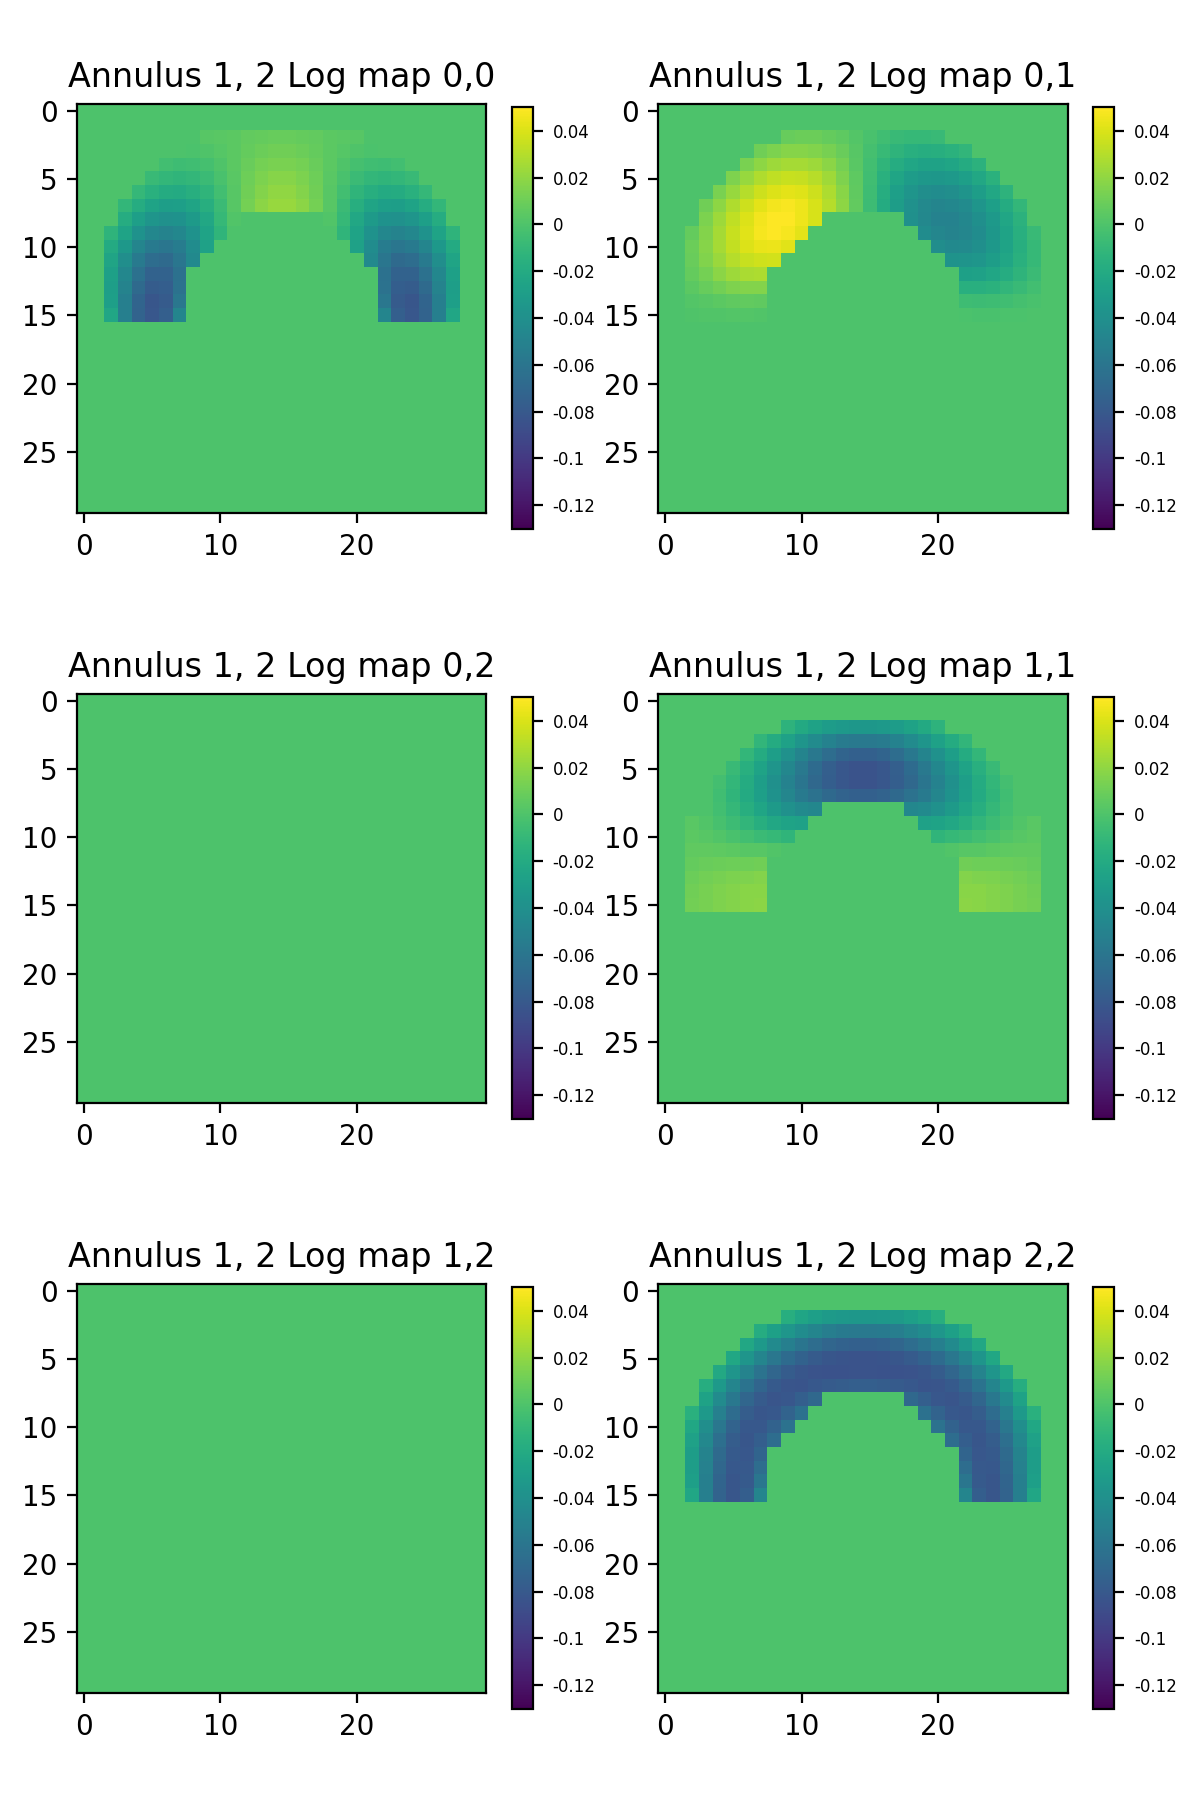

In [22]:
f, axes = plt.subplots(3, 2, figsize=(6,9))
im0=axes[0,0].imshow(ann1_ann2_logmap.cpu().detach().numpy()[2,::-1,:,0,0],vmin=-0.13,vmax=0.05)
axes[0,0].set_title('Annulus 1, 2 Log map 0,0')
im1=axes[0,1].imshow(ann1_ann2_logmap.cpu().detach().numpy()[2,::-1,:,0,1],vmin=-0.13,vmax=0.05)
axes[0,1].set_title('Annulus 1, 2 Log map 0,1')
im2=axes[1,0].imshow(ann1_ann2_logmap.cpu().detach().numpy()[2,::-1,:,0,2],vmin=-0.13,vmax=0.05)
axes[1,0].set_title('Annulus 1, 2 Log map 0,2')
im3=axes[1,1].imshow(ann1_ann2_logmap.cpu().detach().numpy()[2,::-1,:,1,1],vmin=-0.13,vmax=0.05)
axes[1,1].set_title('Annulus 1, 2 Log map 1,1')
im4=axes[2,0].imshow(ann1_ann2_logmap.cpu().detach().numpy()[2,::-1,:,1,2],vmin=-0.13,vmax=0.05)
axes[2,0].set_title('Annulus 1, 2 Log map 1,2')
im5=axes[2,1].imshow(ann1_ann2_logmap.cpu().detach().numpy()[2,::-1,:,2,2],vmin=-0.13,vmax=0.05)
axes[2,1].set_title('Annulus 1, 2 Log map 2,2')
plt.tight_layout()

cbar=f.colorbar(im0, ax=axes[0,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im1, ax=axes[0,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im2, ax=axes[1,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im3, ax=axes[1,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im4, ax=axes[2,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im5, ax=axes[2,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)

if save_figs:
  file_name = f'{figdir}/ann_1_2_logmap.png'  
  f.savefig(file_name, bbox_inches='tight', pad_inches=0, 
            dpi=400, transparent=True)


pinverse
CPU times: user 72.2 ms, sys: 13.6 ms, total: 85.8 ms
Wall time: 84.4 ms

inverse
CPU times: user 52.8 ms, sys: 23.7 ms, total: 76.5 ms
Wall time: 75.2 ms

lstsq


<IPython.core.display.Javascript object>


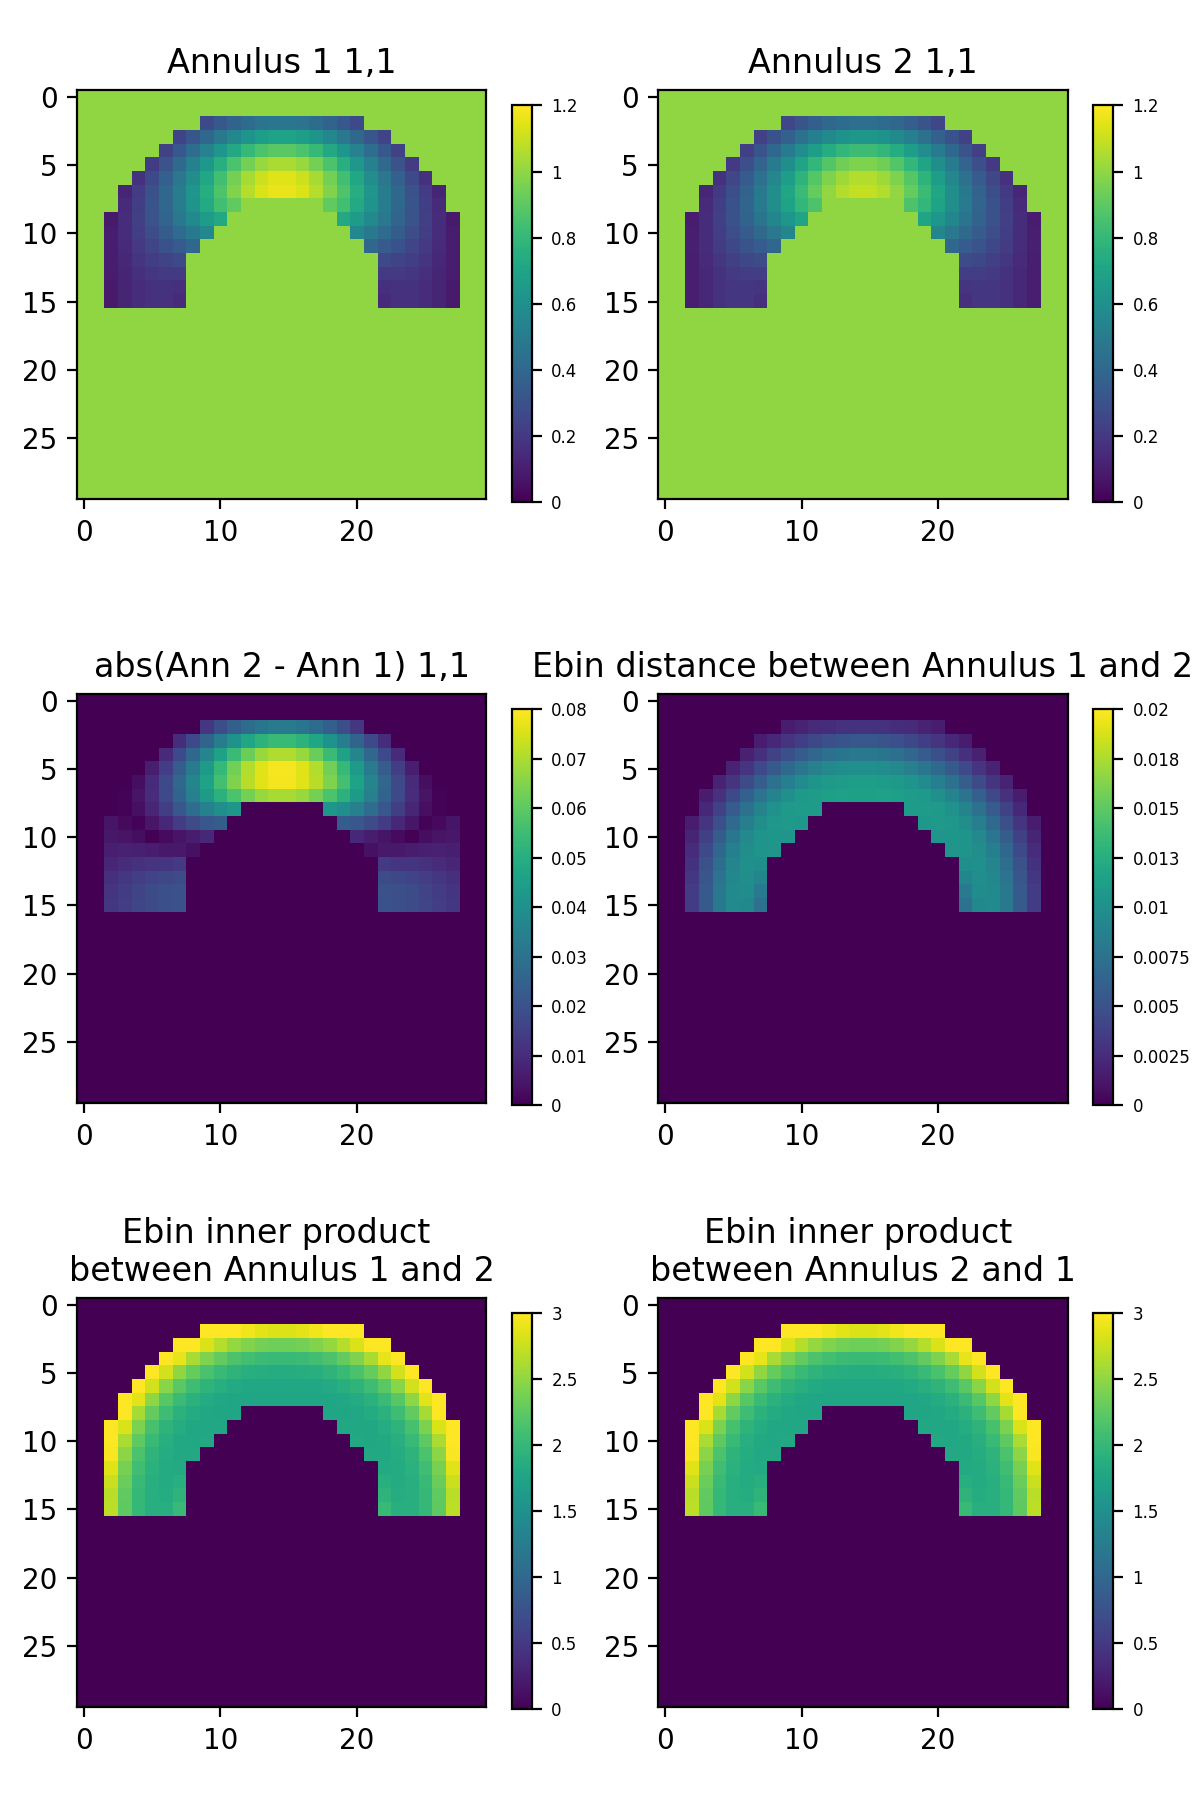

In [23]:
f, axes = plt.subplots(3, 2, figsize=(6,9))
#im0=axes[0,0].imshow(np.transpose(ann1_alpha_np,(2,1,0))[2,::-1],vmin=-0.5,vmax=0.5)
#axes[0,0].set_title('Annulus 1 Alpha')
#im1=axes[0,1].imshow(np.transpose(ann2_alpha_np,(2,1,0))[2,::-1],vmin=-0.5,vmax=0.5)
#axes[0,1].set_title('Annulus 2 Alpha')
#im2=axes[1,0].imshow(np.transpose(ann1_alpha_np - ann2_alpha_np,(2,1,0))[2,::-1],vmin=-1,vmax=1)
#axes[1,0].set_title('Annulus 1 Alpha - Annulus 2 Alpha')

xidx=1
yidx=1
im0 = axes[0,0].imshow(ann1_met.cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=1.2)
axes[0,0].set_title(f'Annulus 1 {xidx},{yidx}')

im1 = axes[0,1].imshow(ann2_met.cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=1.2)
axes[0,1].set_title(f'Annulus 2 {xidx},{yidx}')

im2 = axes[1,0].imshow(torch.abs(ann2_met-ann1_met).cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=0.08)
axes[1,0].set_title(f'abs(Ann 2 - Ann 1) {xidx},{yidx}')


im3=axes[1,1].imshow(ann1_ann2_dist.cpu().detach().numpy()[2,::-1],vmin=0,vmax=0.02)
axes[1,1].set_title('Ebin distance between Annulus 1 and 2')

im4=axes[2,0].imshow(ann1_ann2_innerprod.cpu().detach().numpy()[2,::-1],vmin=0,vmax=3)
axes[2,0].set_title('Ebin inner product \nbetween Annulus 1 and 2')

im5=axes[2,1].imshow(ann2_ann1_innerprod.cpu().detach().numpy()[2,::-1],vmin=0,vmax=3)
axes[2,1].set_title('Ebin inner product \nbetween Annulus 2 and 1')

plt.tight_layout()

cbar=f.colorbar(im0, ax=axes[0,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im1, ax=axes[0,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im2, ax=axes[1,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im3, ax=axes[1,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im4, ax=axes[2,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im5, ax=axes[2,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)

if save_figs:
  file_name = f'{figdir}/ann_1_2_distances.png'  
  f.savefig(file_name, bbox_inches='tight', pad_inches=0, 
            dpi=400, transparent=True)


<IPython.core.display.Javascript object>


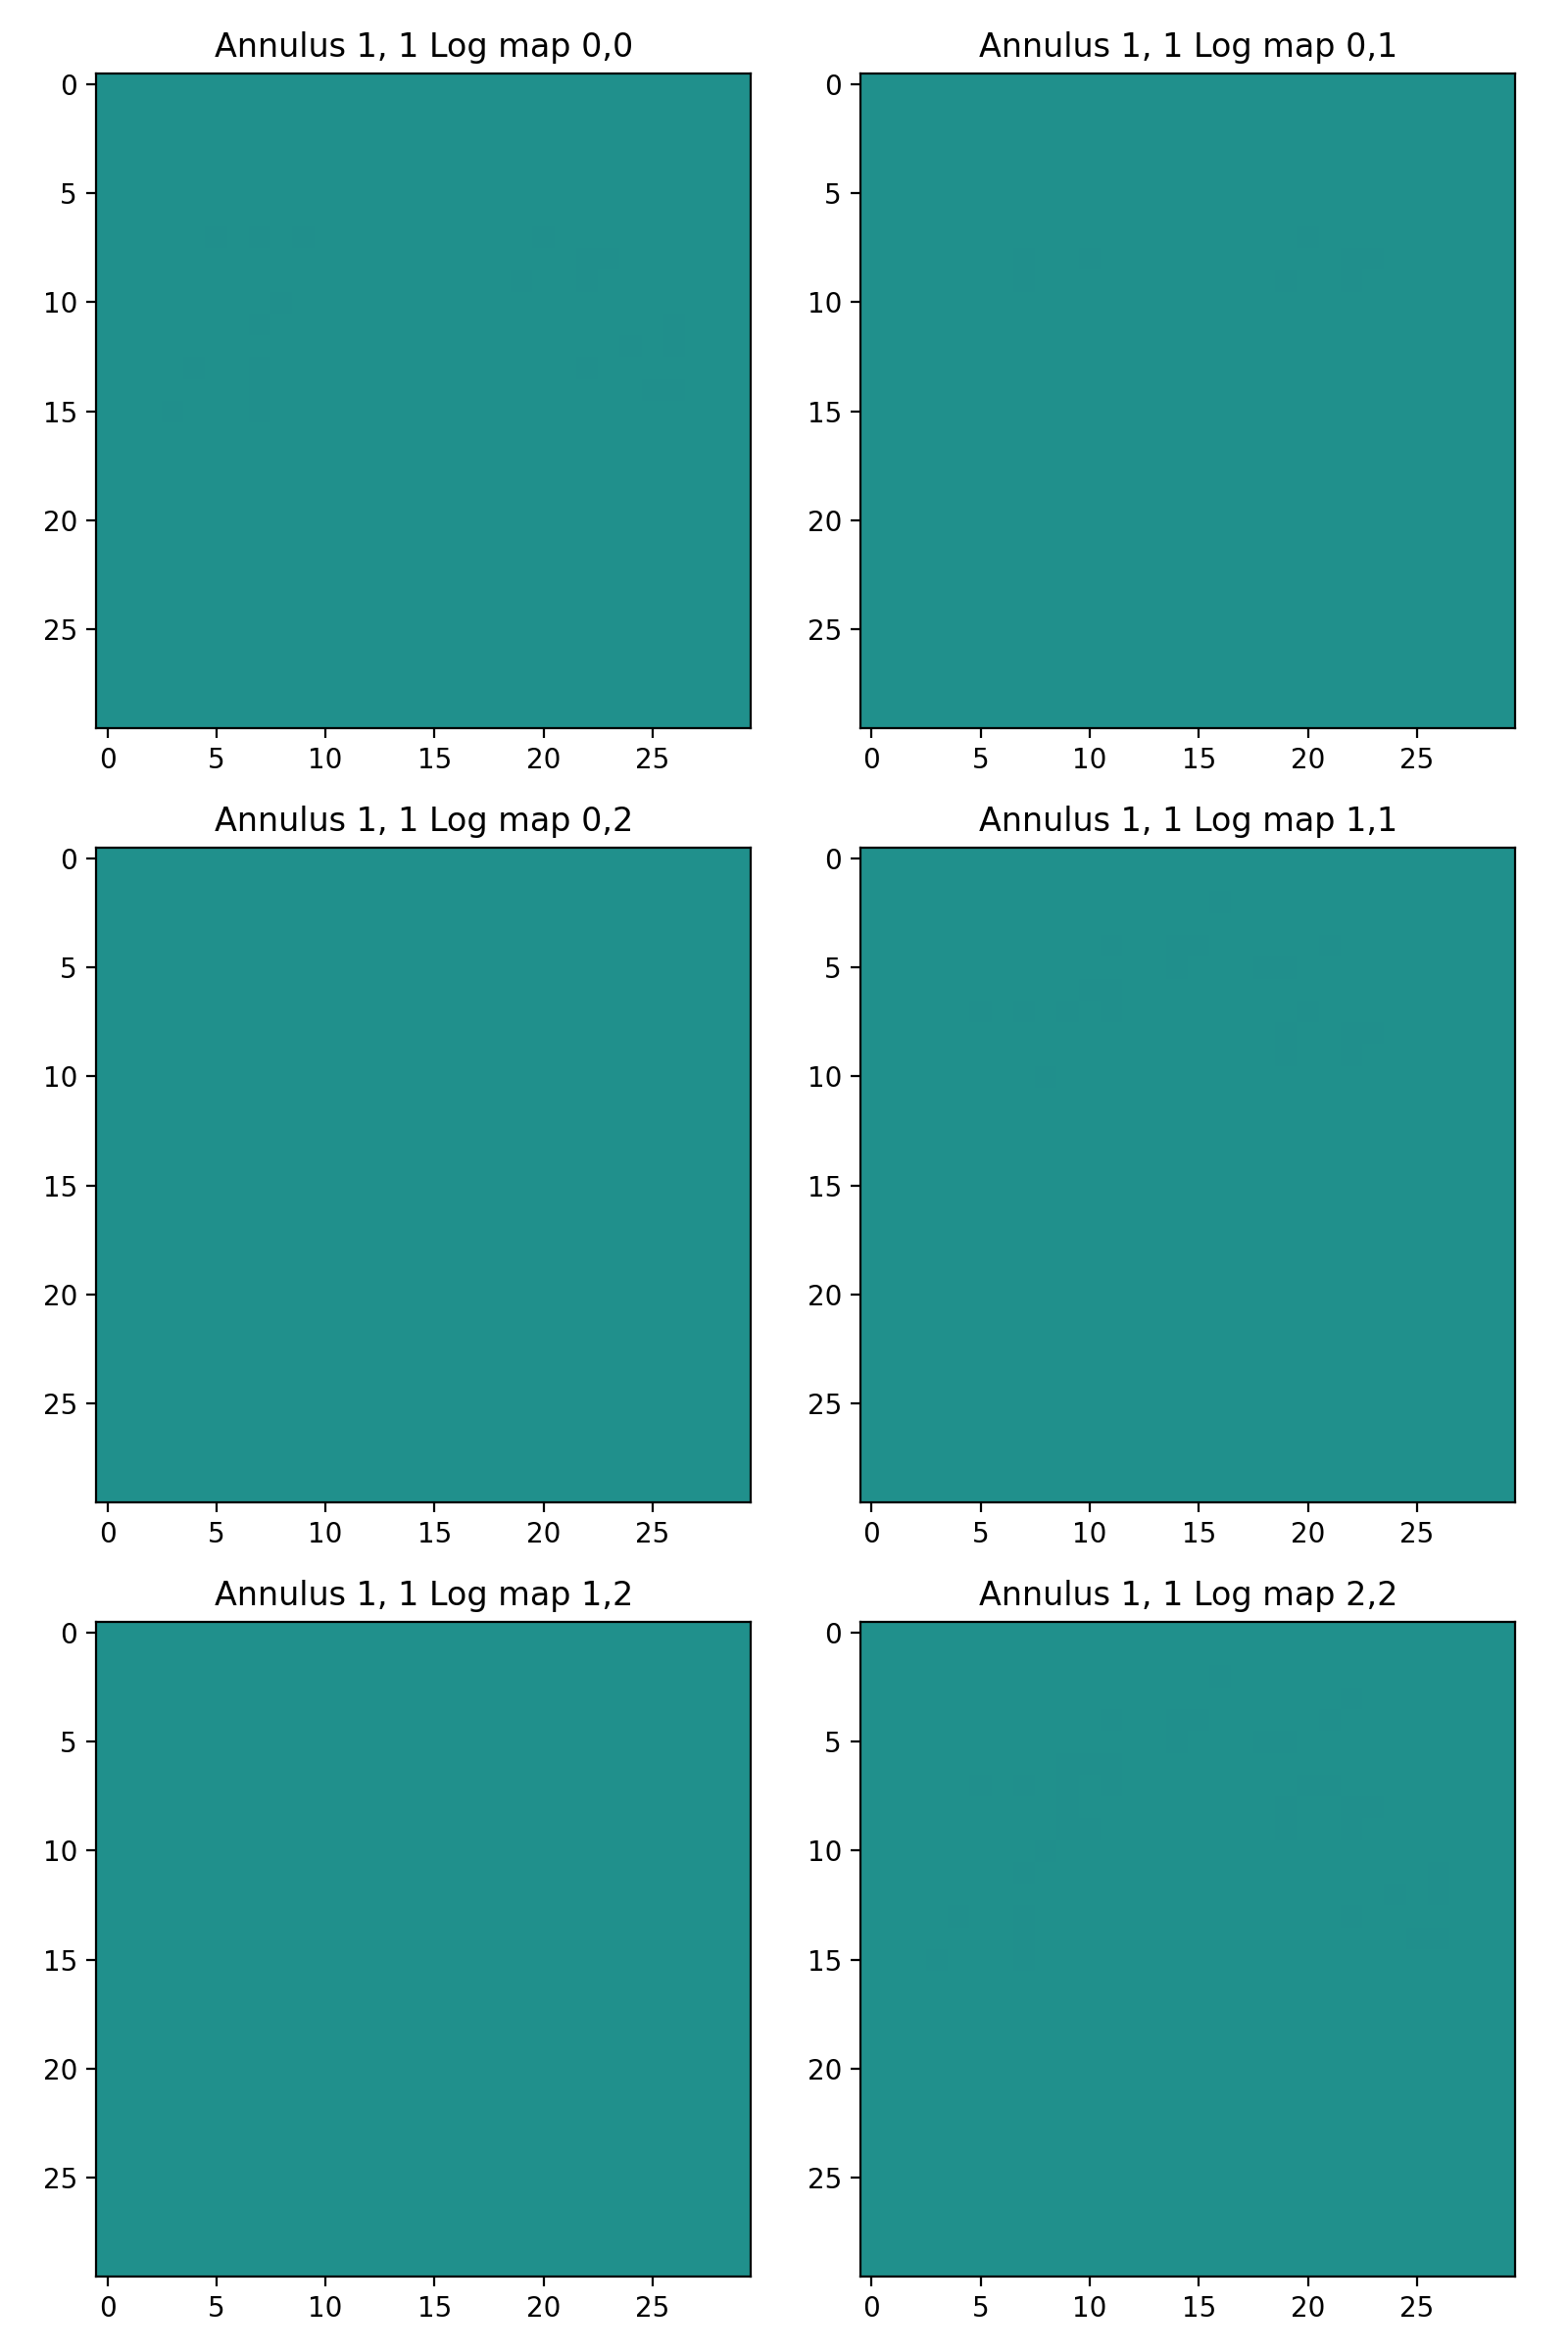

In [22]:
f, axes = plt.subplots(3, 2, figsize=(8,12))
axes[0,0].imshow(ann1_ann1_logmap.cpu().detach().numpy()[2,::-1,:,0,0],vmin=-2,vmax=2)
axes[0,0].set_title('Annulus 1, 1 Log map 0,0')
axes[0,1].imshow(ann1_ann1_logmap.cpu().detach().numpy()[2,::-1,:,0,1],vmin=-2,vmax=2)
axes[0,1].set_title('Annulus 1, 1 Log map 0,1')
axes[1,0].imshow(ann1_ann1_logmap.cpu().detach().numpy()[2,::-1,:,0,2],vmin=-2,vmax=2)
axes[1,0].set_title('Annulus 1, 1 Log map 0,2')
axes[1,1].imshow(ann1_ann1_logmap.cpu().detach().numpy()[2,::-1,:,1,1],vmin=-2,vmax=2)
axes[1,1].set_title('Annulus 1, 1 Log map 1,1')
axes[2,0].imshow(ann1_ann1_logmap.cpu().detach().numpy()[2,::-1,:,1,2],vmin=-2,vmax=2)
axes[2,0].set_title('Annulus 1, 1 Log map 1,2')
axes[2,1].imshow(ann1_ann1_logmap.cpu().detach().numpy()[2,::-1,:,2,2],vmin=-2,vmax=2)
axes[2,1].set_title('Annulus 1, 1 Log map 2,2')
plt.tight_layout()
if save_figs:
  file_name = f'{figdir}/ann_1_1_logmap.png'  
  f.savefig(file_name, bbox_inches='tight', pad_inches=0, 
            dpi=400, transparent=True)


<IPython.core.display.Javascript object>


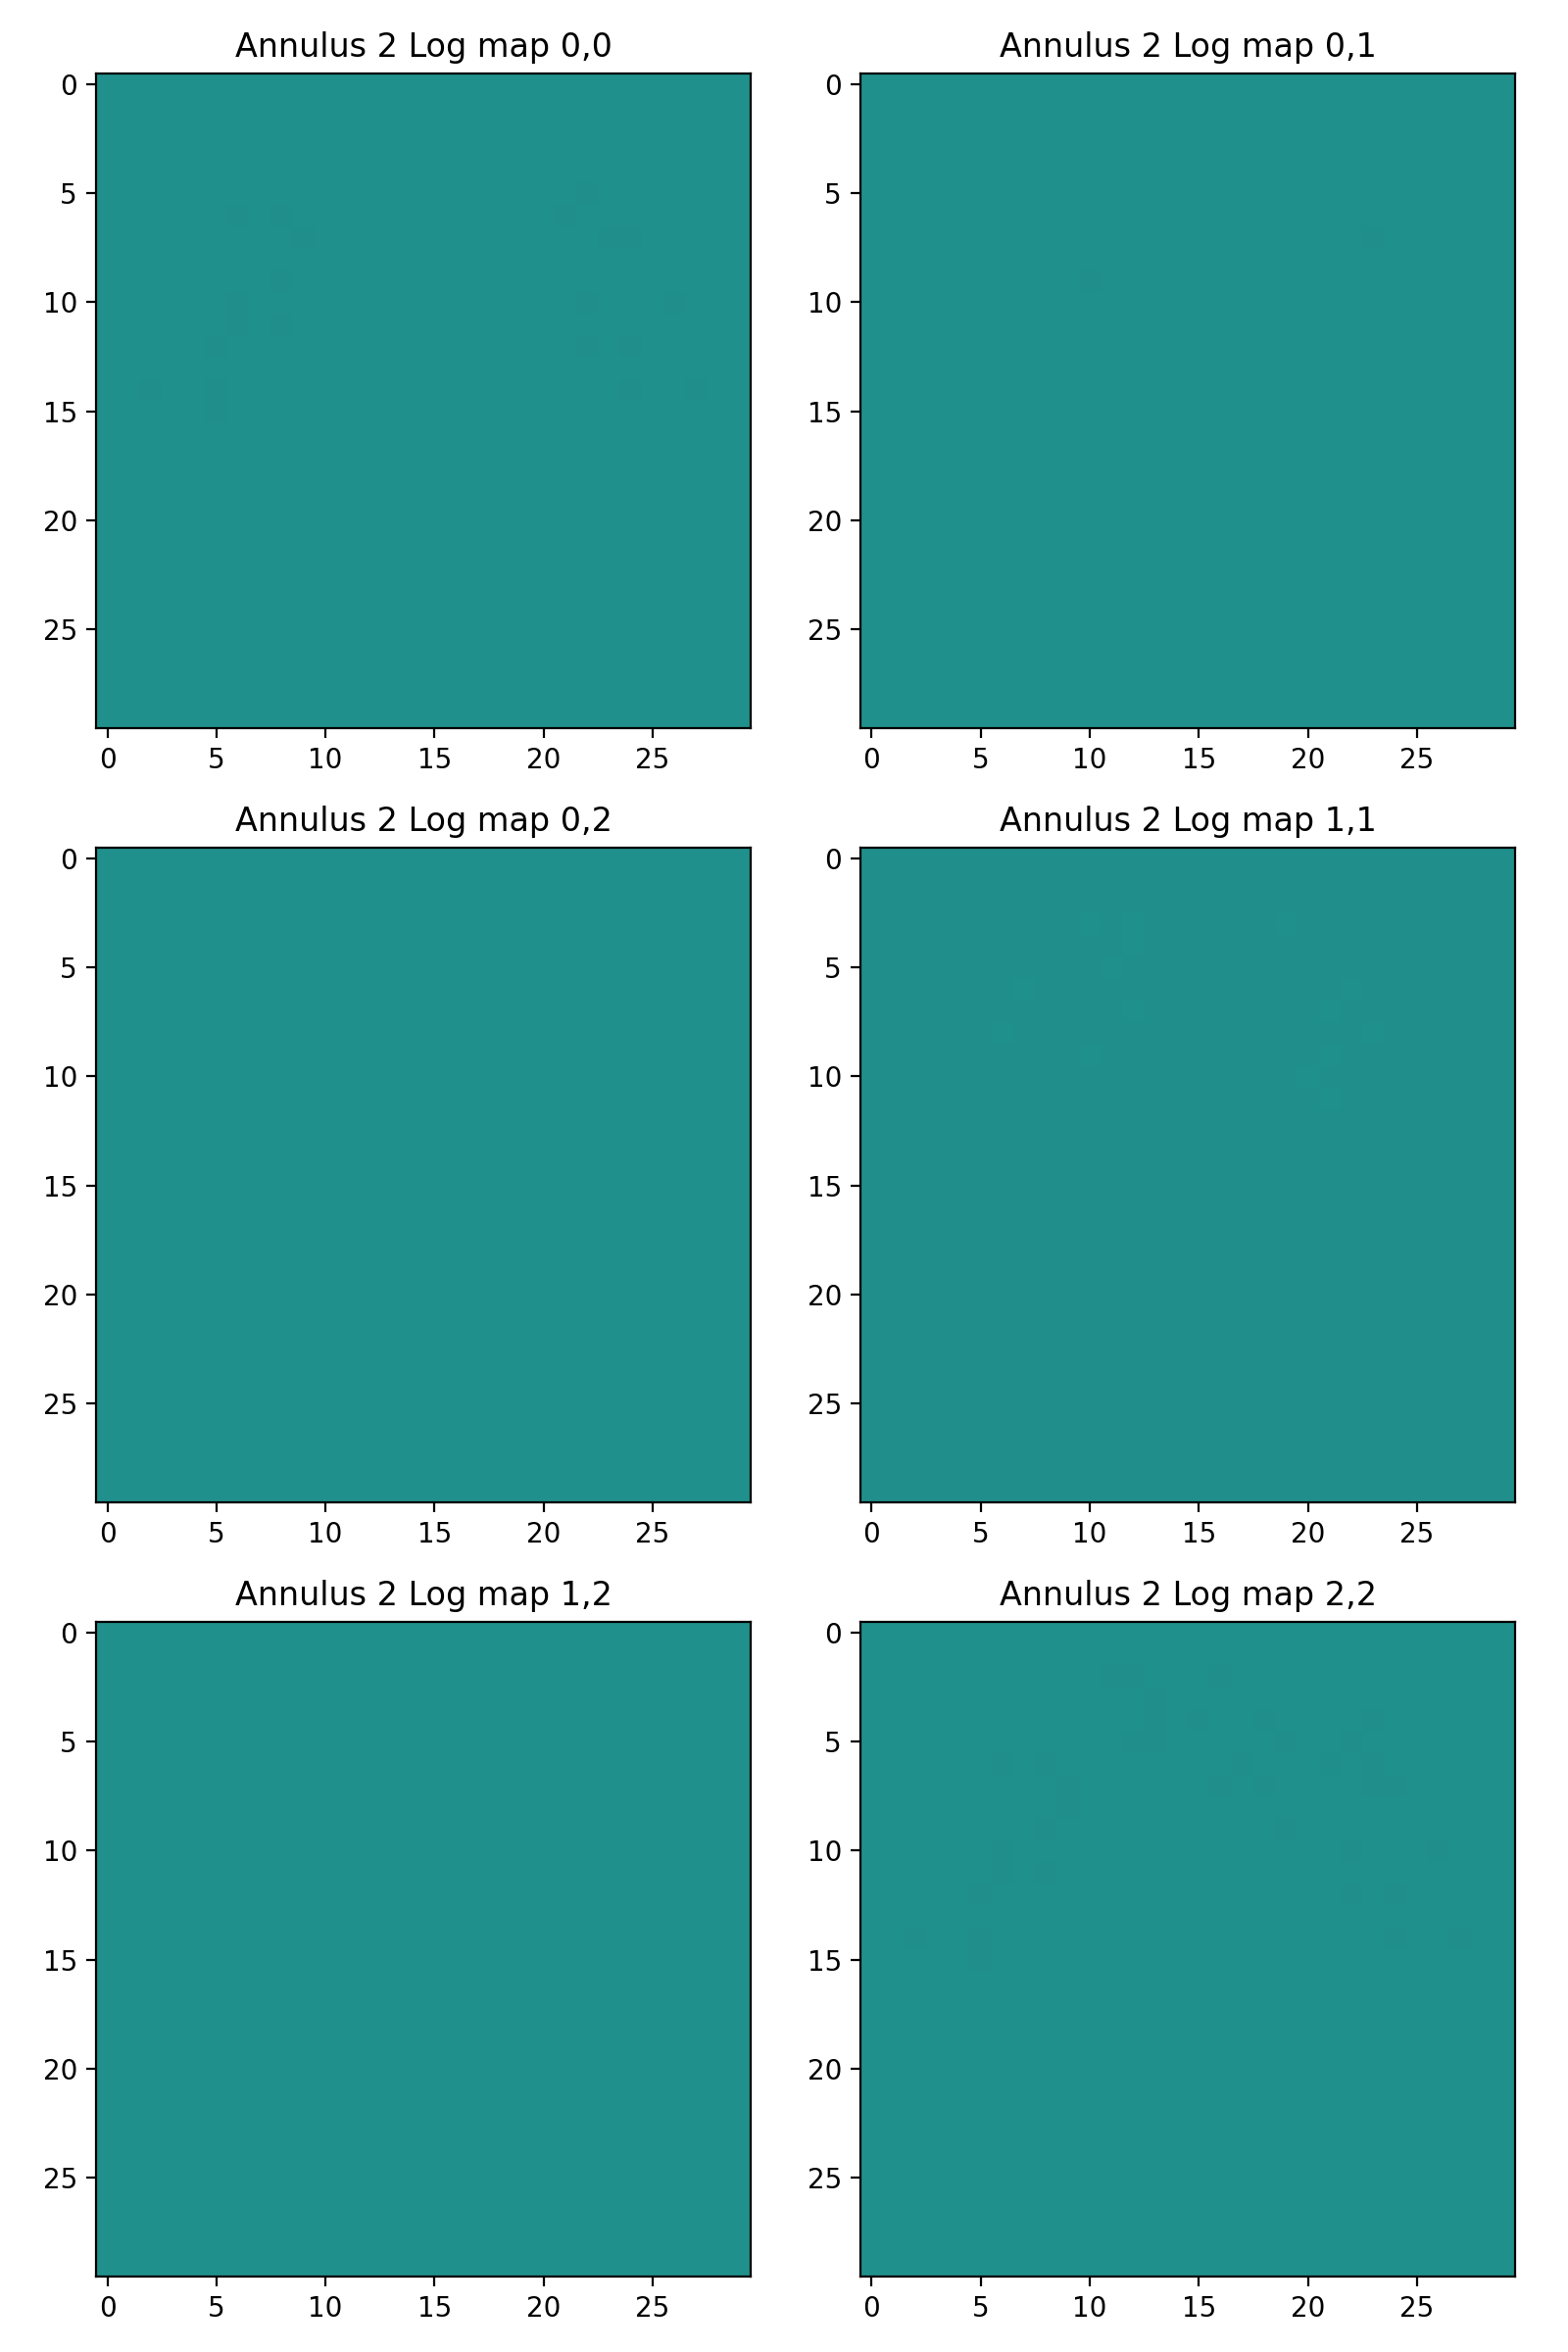

In [23]:
f, axes = plt.subplots(3, 2, figsize=(8,12))
axes[0,0].imshow(ann2_ann2_logmap.cpu().detach().numpy()[2,::-1,:,0,0],vmin=-2,vmax=2)
axes[0,0].set_title('Annulus 2 Log map 0,0')
axes[0,1].imshow(ann2_ann2_logmap.cpu().detach().numpy()[2,::-1,:,0,1],vmin=-2,vmax=2)
axes[0,1].set_title('Annulus 2 Log map 0,1')
axes[1,0].imshow(ann2_ann2_logmap.cpu().detach().numpy()[2,::-1,:,0,2],vmin=-2,vmax=2)
axes[1,0].set_title('Annulus 2 Log map 0,2')
axes[1,1].imshow(ann2_ann2_logmap.cpu().detach().numpy()[2,::-1,:,1,1],vmin=-2,vmax=2)
axes[1,1].set_title('Annulus 2 Log map 1,1')
axes[2,0].imshow(ann2_ann2_logmap.cpu().detach().numpy()[2,::-1,:,1,2],vmin=-2,vmax=2)
axes[2,0].set_title('Annulus 2 Log map 1,2')
axes[2,1].imshow(ann2_ann2_logmap.cpu().detach().numpy()[2,::-1,:,2,2],vmin=-2,vmax=2)
axes[2,1].set_title('Annulus 2 Log map 2,2')
plt.tight_layout()
if save_figs:
  file_name = f'{figdir}/ann_2_2_logmap.png'  
  f.savefig(file_name, bbox_inches='tight', pad_inches=0, 
            dpi=400, transparent=True)


<IPython.core.display.Javascript object>


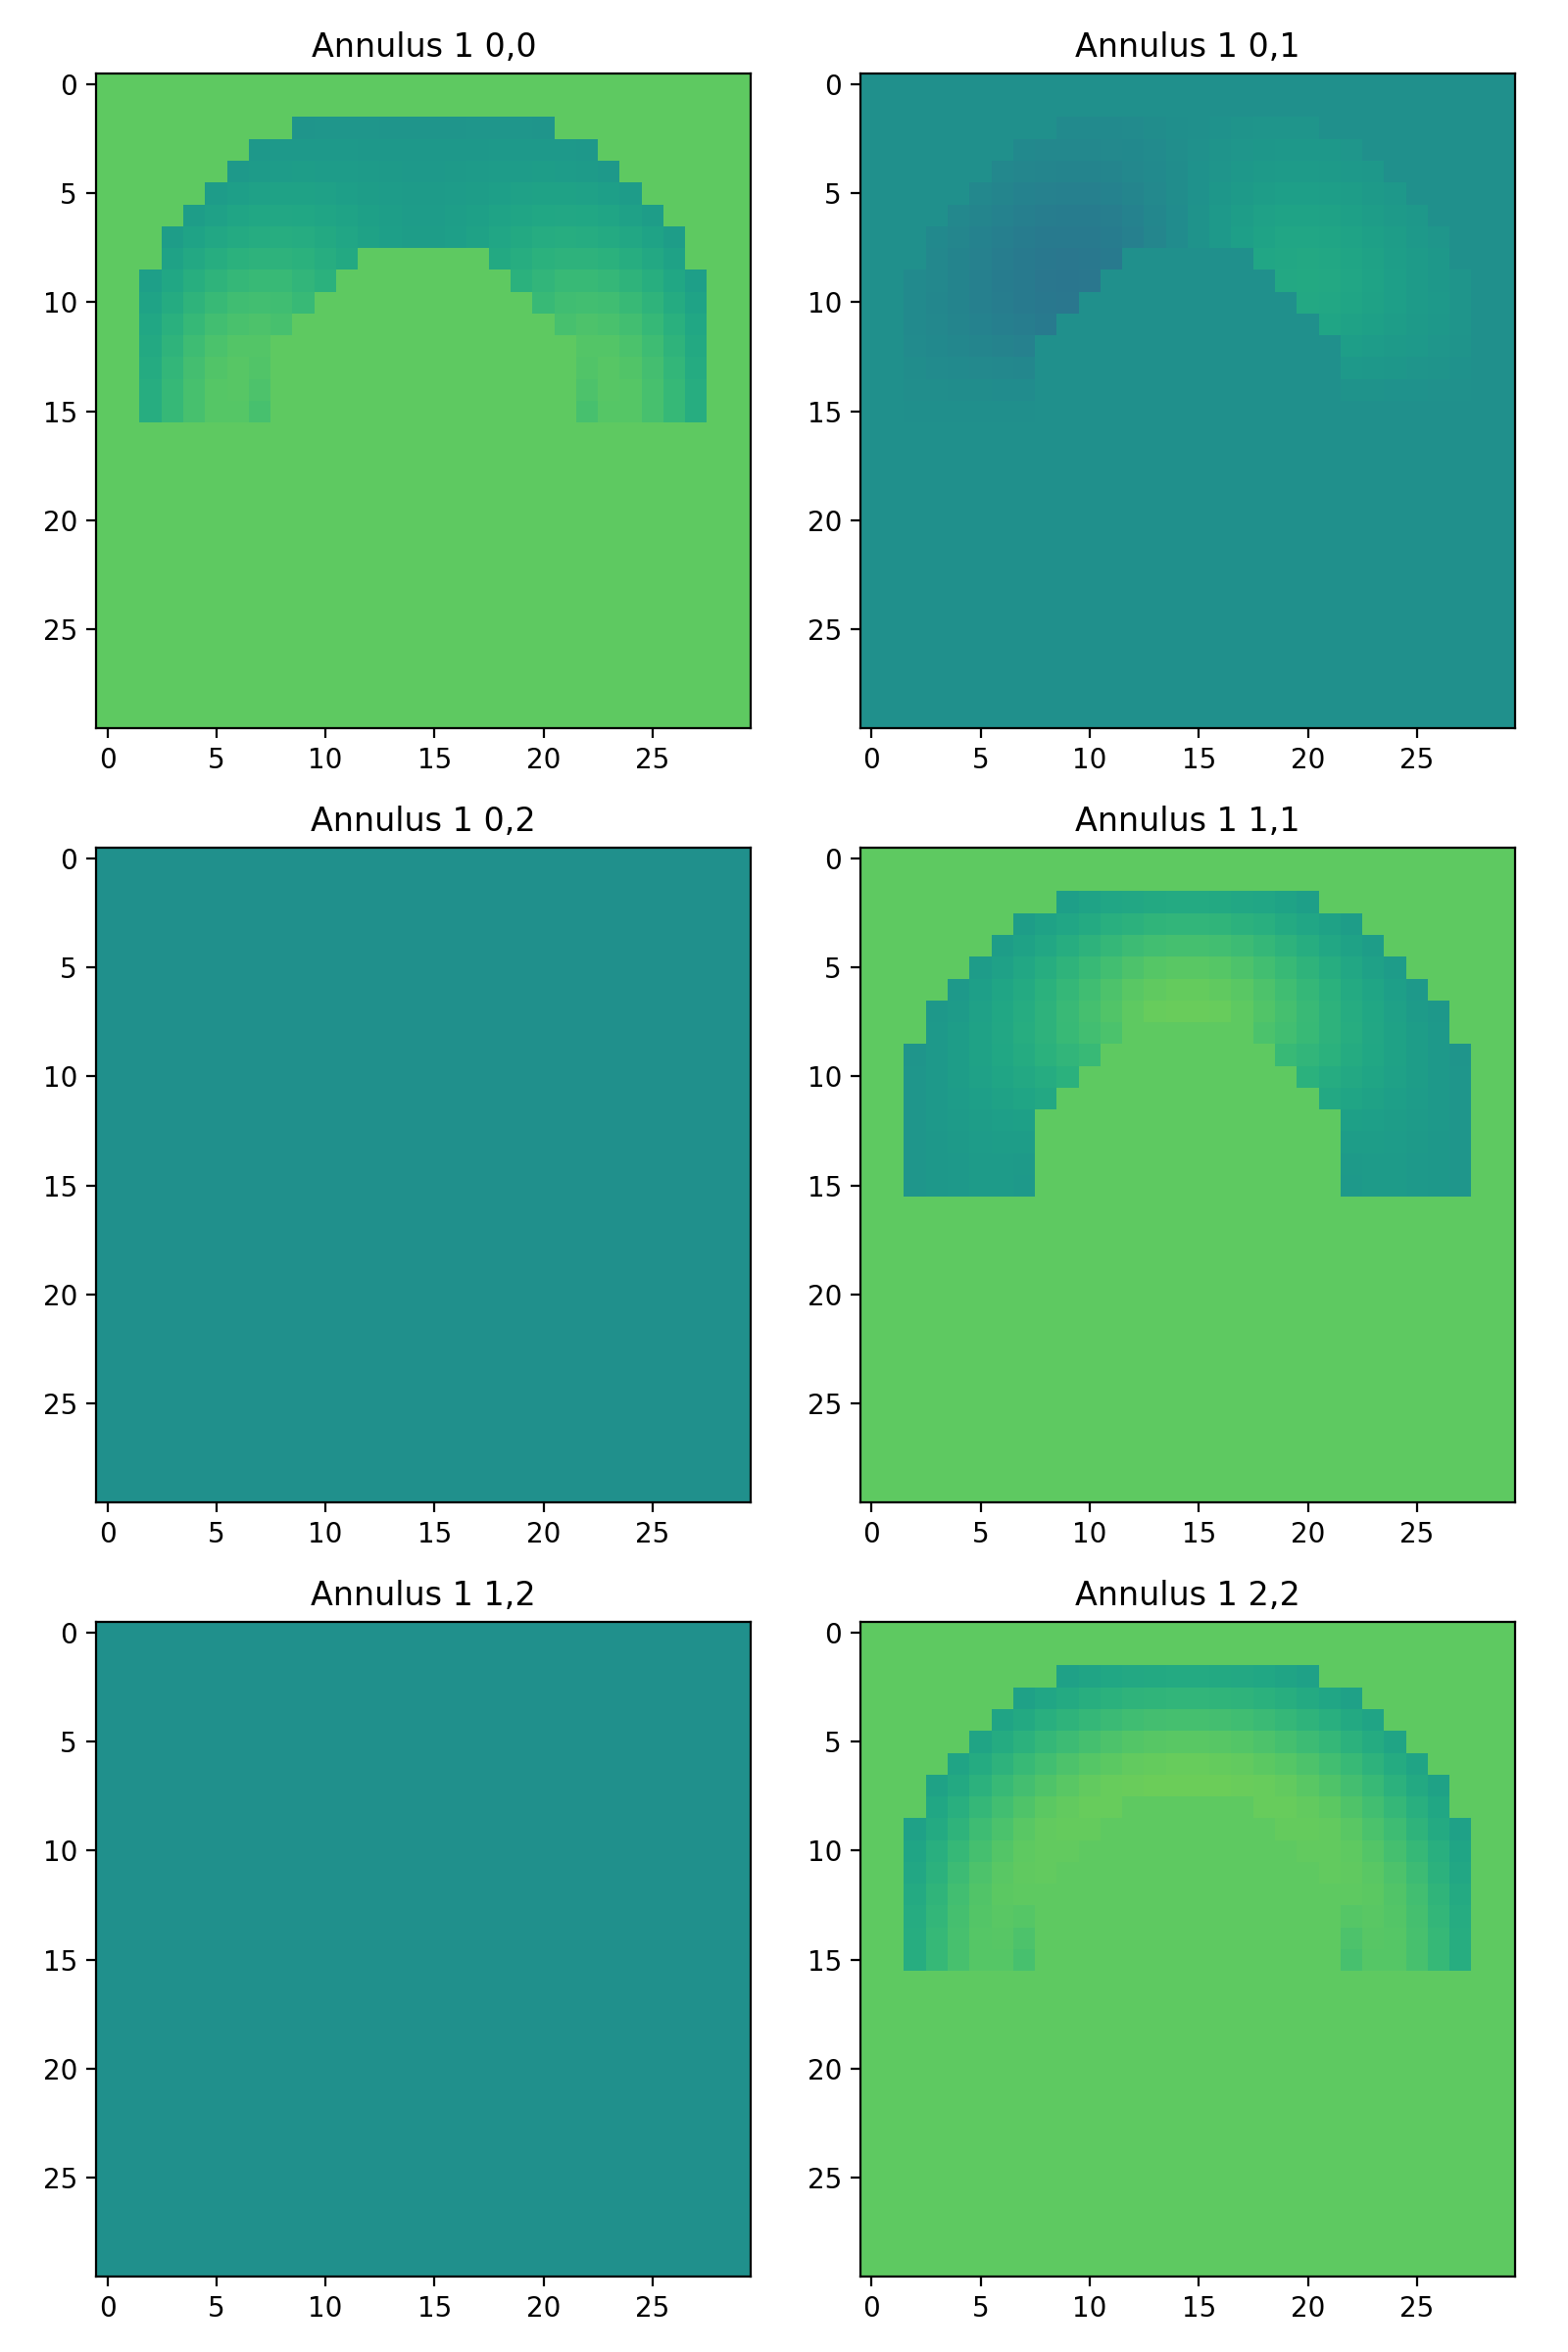

In [24]:
f, axes = plt.subplots(3, 2, figsize=(8,12))
axes[0,0].imshow(ann2_met.cpu().detach().numpy()[2,::-1,:,0,0],vmin=-2,vmax=2)
axes[0,0].set_title('Annulus 1 0,0')
axes[0,1].imshow(ann2_met.cpu().detach().numpy()[2,::-1,:,0,1],vmin=-2,vmax=2)
axes[0,1].set_title('Annulus 1 0,1')
axes[1,0].imshow(ann2_met.cpu().detach().numpy()[2,::-1,:,0,2],vmin=-2,vmax=2)
axes[1,0].set_title('Annulus 1 0,2')
axes[1,1].imshow(ann2_met.cpu().detach().numpy()[2,::-1,:,1,1],vmin=-2,vmax=2)
axes[1,1].set_title('Annulus 1 1,1')
axes[2,0].imshow(ann2_met.cpu().detach().numpy()[2,::-1,:,1,2],vmin=-2,vmax=2)
axes[2,0].set_title('Annulus 1 1,2')
axes[2,1].imshow(ann2_met.cpu().detach().numpy()[2,::-1,:,2,2],vmin=-2,vmax=2)
axes[2,1].set_title('Annulus 1 2,2')
plt.tight_layout()
if save_figs:
  file_name = f'{figdir}/ann_2_met.png'  
  f.savefig(file_name, bbox_inches='tight', pad_inches=0, 
            dpi=400, transparent=True)


<IPython.core.display.Javascript object>


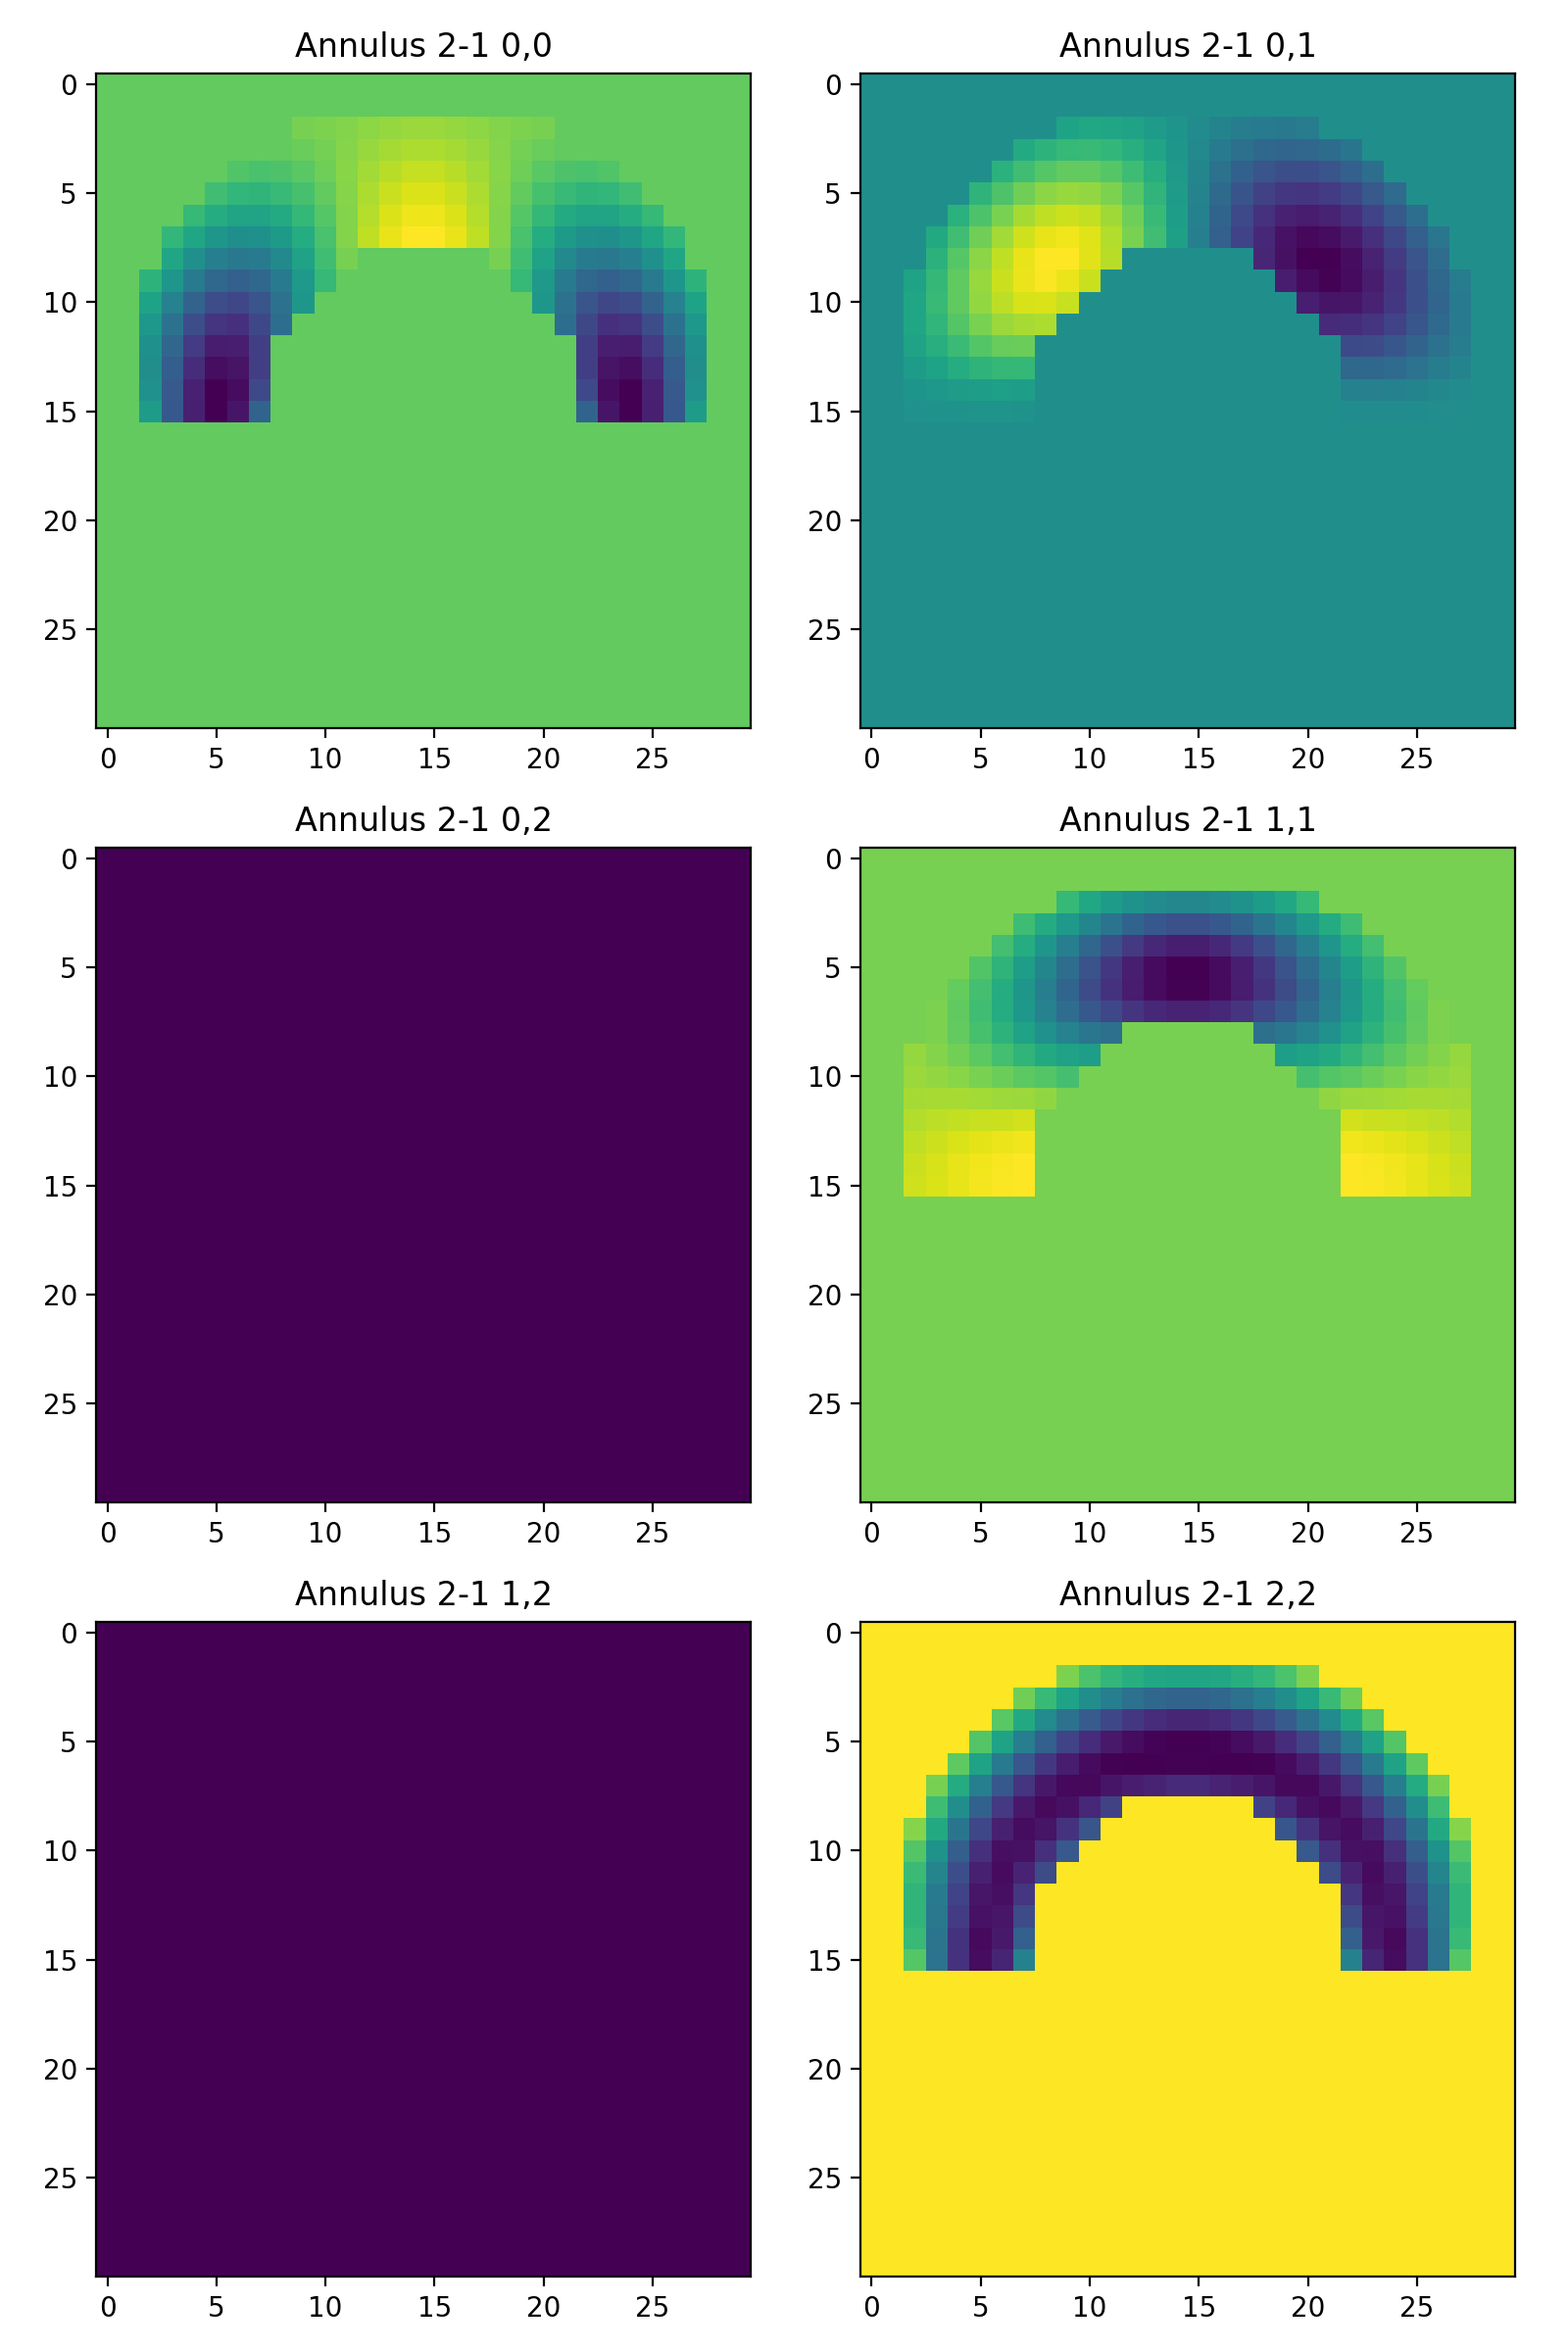

In [25]:
ann2_ann1_diff = ann2_met - ann1_met
f, axes = plt.subplots(3, 2, figsize=(8,12))
axes[0,0].imshow(ann2_ann1_diff.cpu().detach().numpy()[2,::-1,:,0,0])
axes[0,0].set_title('Annulus 2-1 0,0')
axes[0,1].imshow(ann2_ann1_diff.cpu().detach().numpy()[2,::-1,:,0,1])
axes[0,1].set_title('Annulus 2-1 0,1')
axes[1,0].imshow(ann2_ann1_diff.cpu().detach().numpy()[2,::-1,:,0,2])
axes[1,0].set_title('Annulus 2-1 0,2')
axes[1,1].imshow(ann2_ann1_diff.cpu().detach().numpy()[2,::-1,:,1,1])
axes[1,1].set_title('Annulus 2-1 1,1')
axes[2,0].imshow(ann2_ann1_diff.cpu().detach().numpy()[2,::-1,:,1,2])
axes[2,0].set_title('Annulus 2-1 1,2')
axes[2,1].imshow(ann2_ann1_diff.cpu().detach().numpy()[2,::-1,:,2,2])
axes[2,1].set_title('Annulus 2-1 2,2')
plt.tight_layout()
if save_figs:
  file_name = f'{figdir}/ann_2_minus_1.png'  
  f.savefig(file_name, bbox_inches='tight', pad_inches=0, 
            dpi=400, transparent=True)


<IPython.core.display.Javascript object>


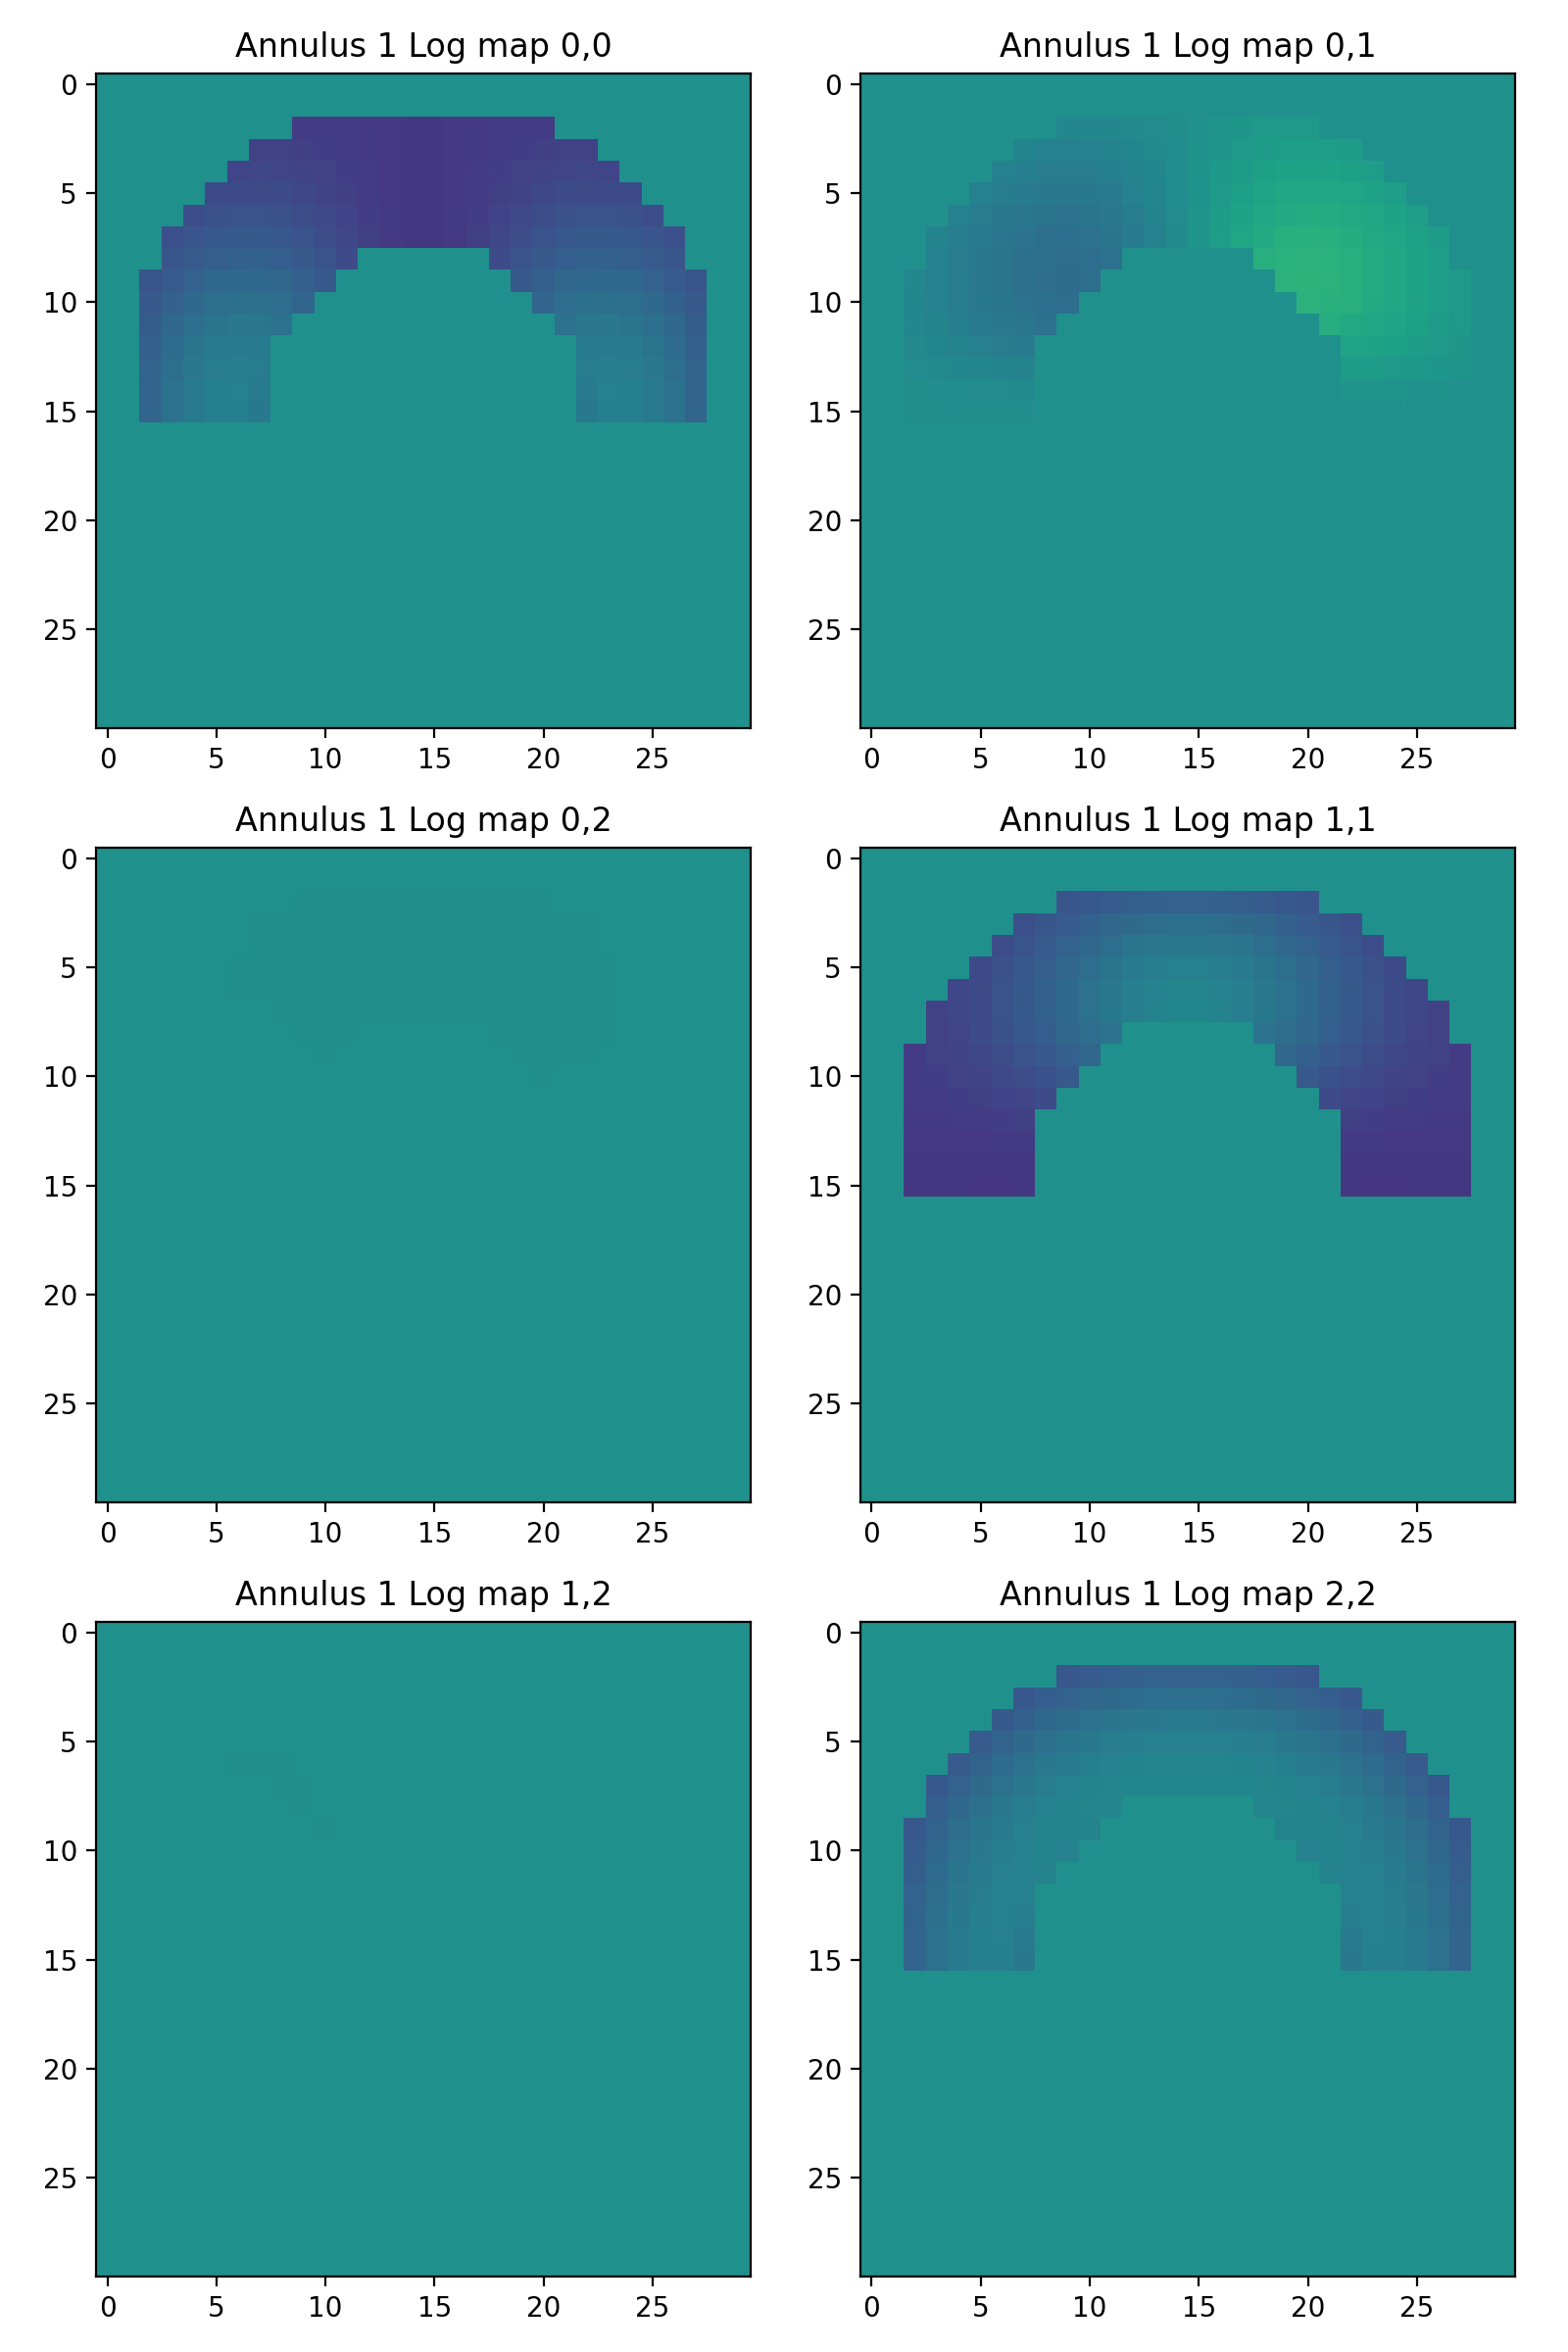

In [26]:
f, axes = plt.subplots(3, 2, figsize=(8,12))
axes[0,0].imshow(ann1_logmap.cpu().detach().numpy()[2,::-1,:,0,0],vmin=-2,vmax=2)
axes[0,0].set_title('Annulus 1 Log map 0,0')
axes[0,1].imshow(ann1_logmap.cpu().detach().numpy()[2,::-1,:,0,1],vmin=-2,vmax=2)
axes[0,1].set_title('Annulus 1 Log map 0,1')
axes[1,0].imshow(ann1_logmap.cpu().detach().numpy()[2,::-1,:,0,2],vmin=-2,vmax=2)
axes[1,0].set_title('Annulus 1 Log map 0,2')
axes[1,1].imshow(ann1_logmap.cpu().detach().numpy()[2,::-1,:,1,1],vmin=-2,vmax=2)
axes[1,1].set_title('Annulus 1 Log map 1,1')
axes[2,0].imshow(ann1_logmap.cpu().detach().numpy()[2,::-1,:,1,2],vmin=-2,vmax=2)
axes[2,0].set_title('Annulus 1 Log map 1,2')
axes[2,1].imshow(ann1_logmap.cpu().detach().numpy()[2,::-1,:,2,2],vmin=-2,vmax=2)
axes[2,1].set_title('Annulus 1 Log map 2,2')
plt.tight_layout()
if save_figs:
  file_name = f'{figdir}/m0_ann_1_logmap.png'  
  f.savefig(file_name, bbox_inches='tight', pad_inches=0, 
            dpi=400, transparent=True)


<IPython.core.display.Javascript object>


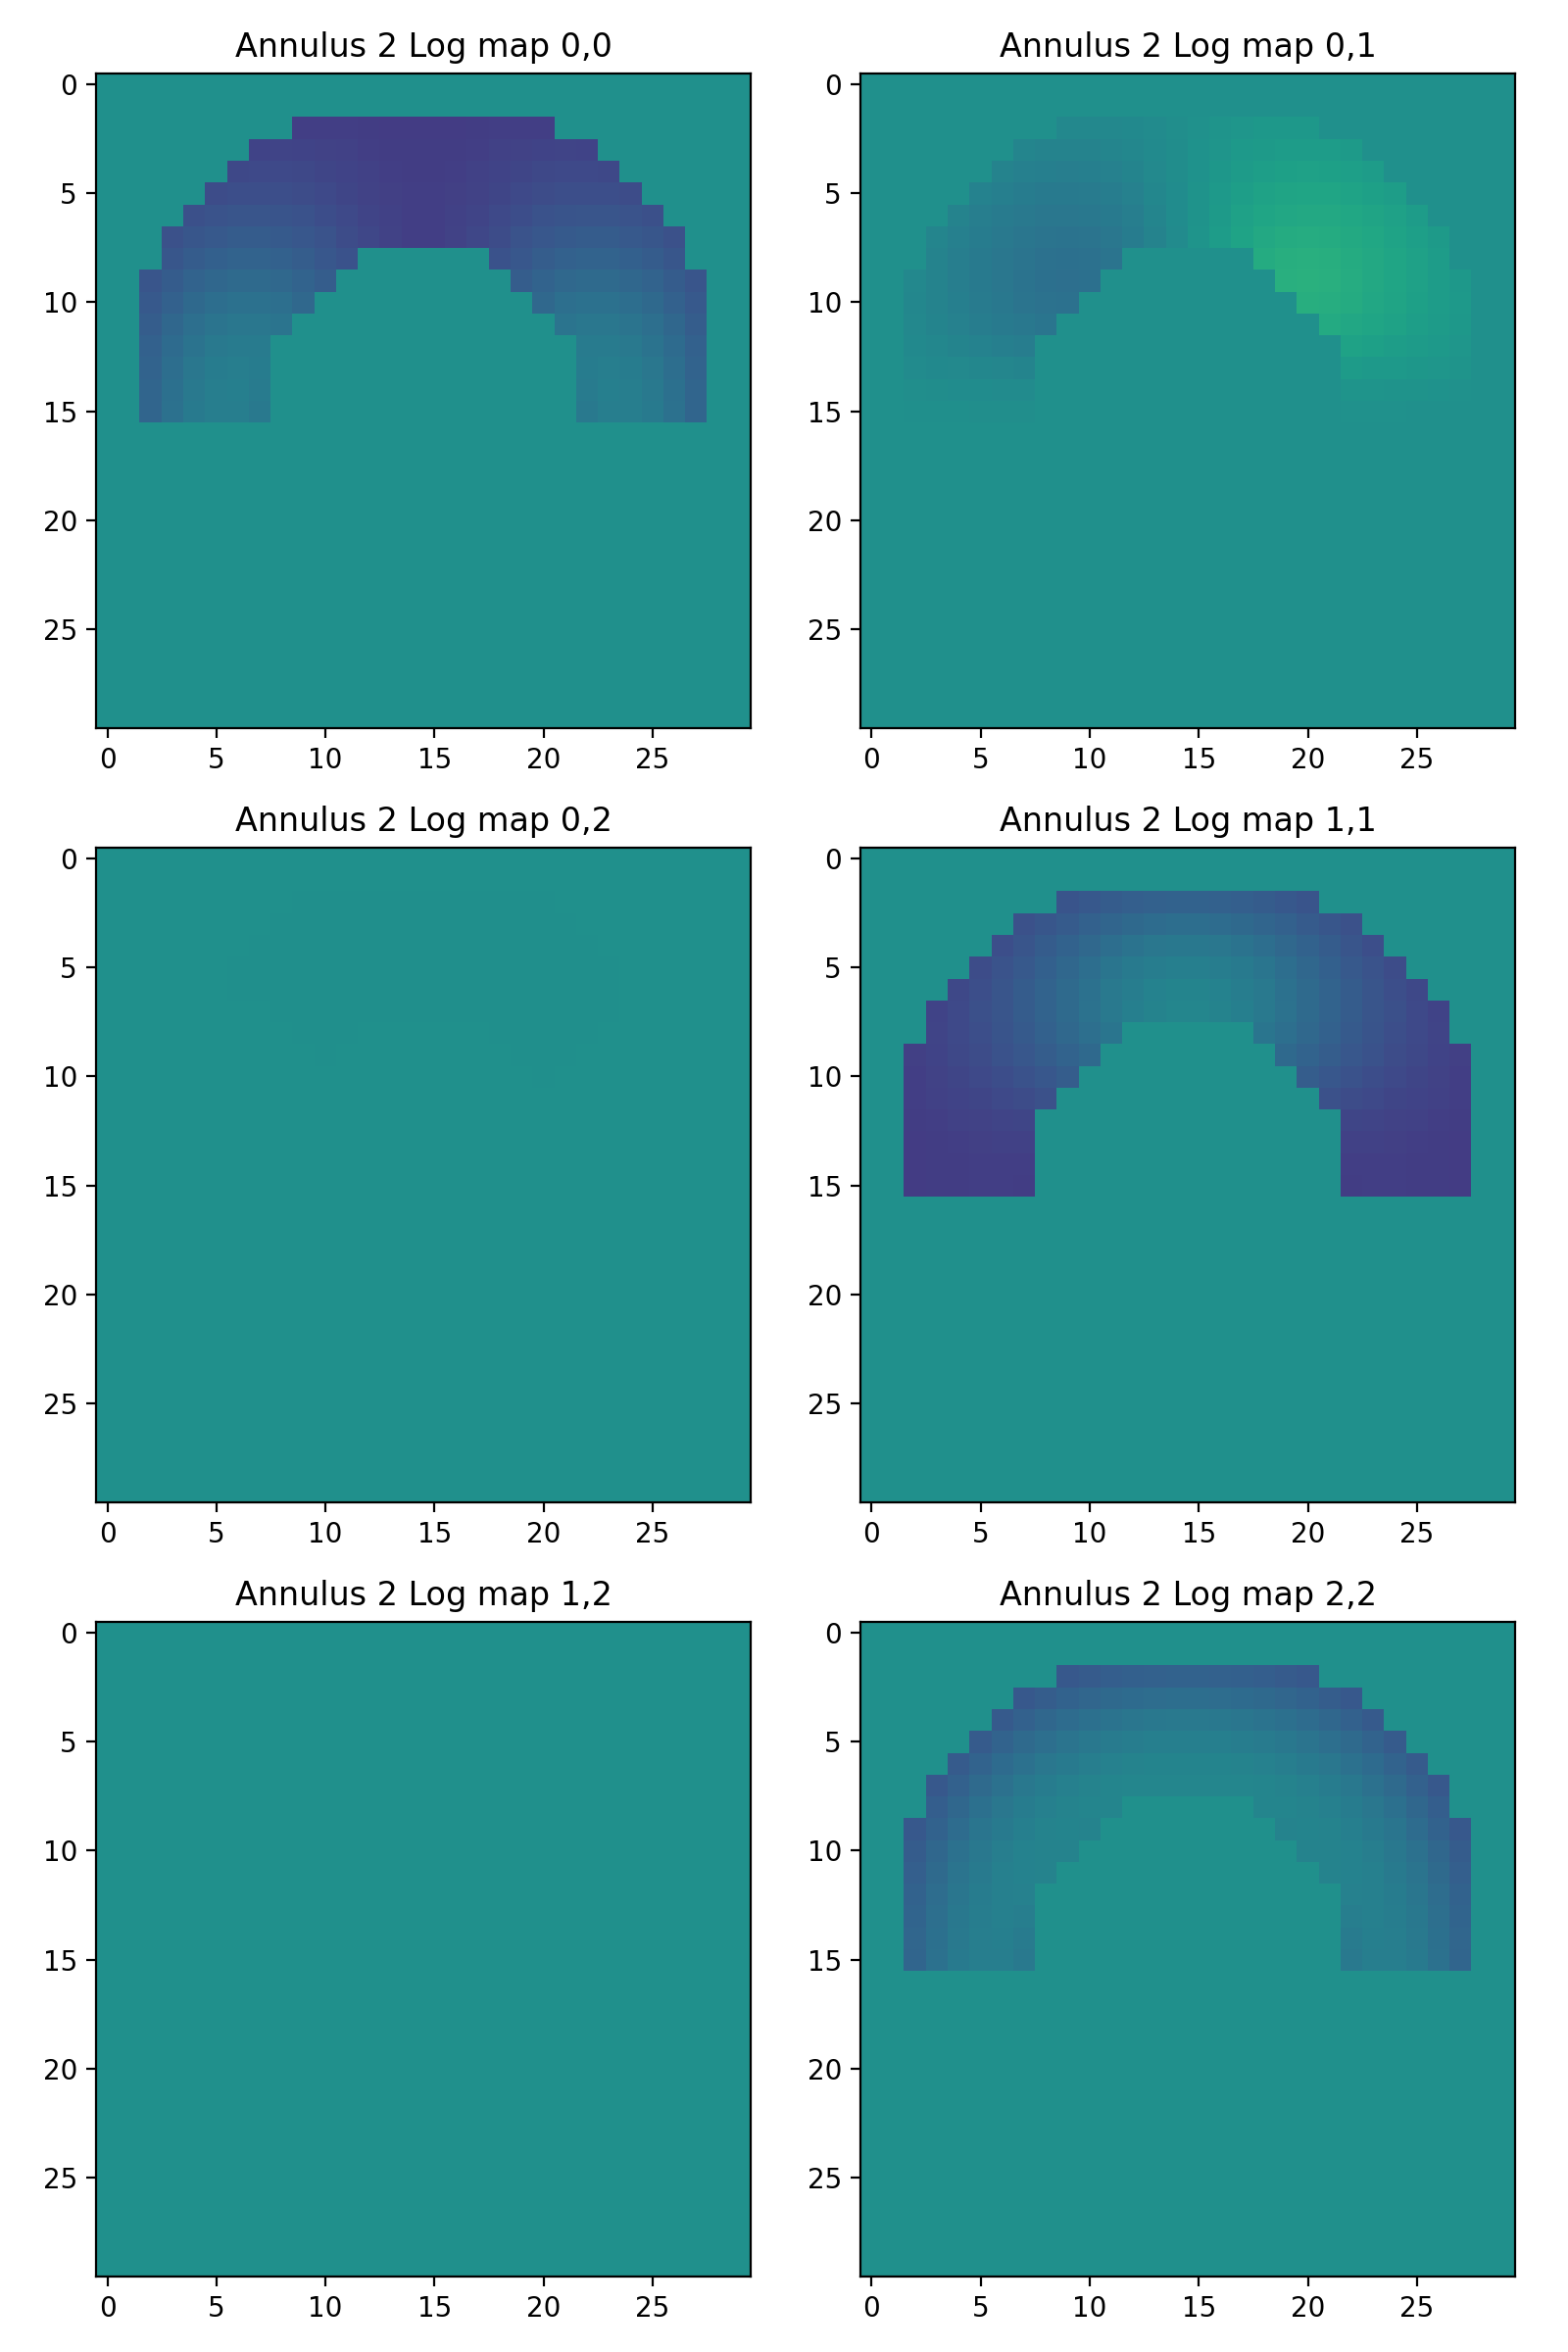

In [27]:
f, axes = plt.subplots(3, 2, figsize=(8,12))
axes[0,0].imshow(ann2_logmap.cpu().detach().numpy()[2,::-1,:,0,0],vmin=-2,vmax=2)
axes[0,0].set_title('Annulus 2 Log map 0,0')
axes[0,1].imshow(ann2_logmap.cpu().detach().numpy()[2,::-1,:,0,1],vmin=-2,vmax=2)
axes[0,1].set_title('Annulus 2 Log map 0,1')
axes[1,0].imshow(ann2_logmap.cpu().detach().numpy()[2,::-1,:,0,2],vmin=-2,vmax=2)
axes[1,0].set_title('Annulus 2 Log map 0,2')
axes[1,1].imshow(ann2_logmap.cpu().detach().numpy()[2,::-1,:,1,1],vmin=-2,vmax=2)
axes[1,1].set_title('Annulus 2 Log map 1,1')
axes[2,0].imshow(ann2_logmap.cpu().detach().numpy()[2,::-1,:,1,2],vmin=-2,vmax=2)
axes[2,0].set_title('Annulus 2 Log map 1,2')
axes[2,1].imshow(ann2_logmap.cpu().detach().numpy()[2,::-1,:,2,2],vmin=-2,vmax=2)
axes[2,1].set_title('Annulus 2 Log map 2,2')
plt.tight_layout()
if save_figs:
  file_name = f'{figdir}/m0_ann_2_logmap.png'  
  f.savefig(file_name, bbox_inches='tight', pad_inches=0, 
            dpi=400, transparent=True)


## 2. Register 2 Annuli

In [20]:
def phi_pullback(phi, g, mask=None):
#     input: phi.shape = [3, h, w, d]; g.shape = [h, w, d, 3, 3]
#     output: shape = [h, w, 2, 2]
#     torch.set_default_tensor_type('torch.cuda.DoubleTensor')
    g = g.permute(3, 4, 0, 1, 2)
    idty = get_idty(*g.shape[-3:], device=cuda_dev)
    #     four layers of scalar field, of all 1, all 0, all 1, all 0, where the shape of each layer is g.shape[-2:]?
    eye = torch.eye(3, device=cuda_dev)
    ones = torch.ones(*g.shape[-3:], device=cuda_dev)
    d_phi = get_jacobian_matrix(phi - idty) + torch.einsum("ij,mno->ijmno", eye, ones)
    g_phi = compose_function(g, phi)
    return torch.einsum("ij...,ik...,kl...->...jl", d_phi, g_phi, d_phi)
    # Problems with .backward autograd for make_pos_def
    #return(make_pos_def(torch.einsum("ij...,ik...,kl...->...jl", d_phi, g_phi, d_phi), mask))
    


def energy_ebin(phi, g0, g1, f0, f1, i0, i1, sigma, dim, mask,metWeight=None,imWeight=None): 
#     input: phi.shape = [3, h, w, d]; g0/g1/f0/f1.shape = [h, w, d, 3, 3]; sigma/dim = scalar; mask.shape = [1, h, w, d]
#     output: scalar
# the phi here is identity
    phi_star_g1 = phi_pullback(phi, g1)
    phi_star_f1 = phi_pullback(phi, f1)# the compose operation in this step uses a couple of thousands MB of memory
    phi_star_i1 = compose_function(i1.unsqueeze(0), phi, mask, 0).squeeze()# the compose operation in this step uses a couple of thousands MB of memory
    #print('energy_ebin phi NaN',phi.isnan().any(), 'g1 NaN?', g1.isnan().any(), 'phi_star_g1 NaN?', phi_star_g1.isnan().any(), 'phi_star_f1 NaN?', phi_star_f1.isnan().any())
    #print('energy_ebin phi Inf',phi.isinf().any(), 'g1 Inf?', g1.isinf().any(), 'phi_star_g1 Inf?', phi_star_g1.isinf().any(), 'phi_star_f1 Inf?', phi_star_f1.isinf().any())

    #print('\n\nenergy_ebin max phi star:',torch.max(phi_star_g1), torch.max(phi_star_f1),'\n\n')

    #E1 = sigma * Squared_distance_Ebin(f0, phi_star_f1, 1./dim, mask)
    E1 = Squared_distance_Ebin(f0, phi_star_f1, 1./dim, mask)
    E2 = Squared_distance_Ebin(g0, phi_star_g1, 1./dim, mask)
    # E3 = torch.einsum("ijk,ijk->", (i0 - phi_star_i1) ** 2, mask)
    # E3 = torch.einsum("ijk,ijk->", (i0 - phi_star_i1) ** 2, (1-mask)*brain_mask)
    E3 = torch.sum((i0 - phi_star_i1) ** 2)
    #print(E1, E2*2.5e2, E3*1.5e-9, 'DIFFERENT THAN HDAI VERSION')
    #return E1 + E2*2.5e2 + E3*1.5e-9
    # Use following when not scaling image by 255
    #print(E1, E2*2.5e2, E3*1.5e-1, 'DIFFERENT THAN HDAI VERSION')
    #return E1 + E2*2.5e2 + E3*1.5e-1
    # Use following when scaling image by 255
    #print(sigma*E1, E2*2.5e2, E3*1.5e4, 'DIFFERENT THAN HDAI VERSION')
    #return sigma*E1 + E2*2.5e2 + E3*1.5e4
    # Use following for 6 subj ABCD
    #print(sigma*E1, E2*2.5e2, E3*0.6e4, 'DIFFERENT THAN HDAI VERSION')
    #return sigma*E1 + E2*2.5e2 + E3*0.6e4
    # Use following for Cubic simulation
    print(E1, E2, E3, 'prescaled')
    #print(sigma*E1, E2*2.5e2, E3*0.3e9, 'DIFFERENT THAN HDAI VERSION')
    if metWeight is None:
      metWeight = 2.5e2
    if imWeight is None:
      imWeight = 0.3e9

    print(sigma*E1, E2*metWeight, E3*imWeight, 'DIFFERENT THAN HDAI VERSION')
    return sigma*E1 + E2*metWeight + E3*imWeight
   
    # Following was hdai version
    #return E1 + E2*2.5e2 + E3*0#1.5e-9


def energy_L2(phi, g0, g1, f0, f1, sigma, mask): 
#     input: phi.shape = [3, h, w, d]; g0/g1/f0/f1.shape = [h, w, d, 3, 3]; sigma = scalar; mask.shape = [1, h, w, d]
#     output: scalar
    phi_star_g1 = phi_pullback(phi, g1)
    phi_star_f1 = phi_pullback(phi, f1)
    E1 = sigma * torch.einsum("ijk...,lijk->", (f0 - phi_star_f1) ** 2, mask.unsqueeze(0))
    E2 = torch.einsum("ijk...,lijk->", (g0 - phi_star_g1) ** 2, mask.unsqueeze(0))
    # E = E1 + E2
#     del phi_star_g1, phi_star_f1
#     torch.cuda.empty_cache()
    return E1 + E2


def laplace_inverse(u):
#     input: u.shape = [3, h, w, d]
#     output: shape = [3, h, w, d]
    '''
    this function computes the laplacian inverse of a vector field u of size 3 x size_h x size_w x size_d
    '''
    size_h, size_w, size_d = u.shape[-3:]
    pi_ten = torch.tensor(np.pi, dtype=torch.double).to(device=u.device)
    #idty = get_idty(size_h, size_w, size_d, device='cpu').cpu().numpy()
    idty = get_idty(size_h, size_w, size_d, device=u.device)
    #lap = 6. - 2. * (np.cos(2. * np.pi * idty[0] / size_h) +
    #                 np.cos(2. * np.pi * idty[1] / size_w) +
    #                 np.cos(2. * np.pi * idty[2] / size_d))
    lap = 6. - 2. * (torch.cos(2. * pi_ten * idty[0] / size_h) +
                     torch.cos(2. * pi_ten * idty[1] / size_w) +
                     torch.cos(2. * pi_ten * idty[2] / size_d))
    
    lap[0, 0] = 1.
    lapinv = 1. / lap
    lap[0, 0] = 0.
    lapinv[0, 0] = 1.

    #u = u.cpu().detach().numpy()
    #fx = np.fft.fftn(u[0])
    #fy = np.fft.fftn(u[1])
    #fz = np.fft.fftn(u[2])
    fx = torch.fft.fftn(u[0])
    fy = torch.fft.fftn(u[1])
    fz = torch.fft.fftn(u[2])
    fx *= lapinv
    fy *= lapinv
    fz *= lapinv
    #vx = torch.from_numpy(np.real(np.fft.ifftn(fx)))
    #vy = torch.from_numpy(np.real(np.fft.ifftn(fy)))
    #vz = torch.from_numpy(np.real(np.fft.ifftn(fz)))
    vx = torch.real(torch.fft.ifftn(fx))
    vy = torch.real(torch.fft.ifftn(fy))
    vz = torch.real(torch.fft.ifftn(fz))

    return torch.stack((vx, vy, vz)).to(device=torch.device(cuda_dev))

        

def metric_matching(gi, gm, ii, im, height, width, depth, ith_mask, mask, iter_num, epsilon, sigma, dim, met_weight=None, img_weight=None):
    phi_inv = get_idty(height, width, depth,device=cuda_dev)
    phi = get_idty(height, width, depth,device=cuda_dev)
    idty = get_idty(height, width, depth,device=cuda_dev)
    idty.requires_grad_()
    f0 = torch.eye(int(dim)).repeat(height, width, depth, 1, 1).to(cuda_dev)
    f1 = torch.eye(int(dim)).repeat(height, width, depth, 1, 1).to(cuda_dev)
      
    for j in range(iter_num):
        phi_actsg0 = phi_pullback(phi_inv, gi, ith_mask)
        phi_actsf0 = phi_pullback(phi_inv, f0, ith_mask) # TODO ith_mask or mask here?
        #phi_actsg0 = make_pos_def(phi_pullback(phi_inv, gi.to(cuda_dev), ith_mask), ith_mask, 1.0e-10)
        #phi_actsf0 = make_pos_def(phi_pullback(phi_inv, f0.to(cuda_dev), ith_mask), ith_mask, 1.0e-10) # TODO ith_mask or mask here?
        #print('\n\nmetric_matching, iter', j,', max phi acts:',torch.max(phi_actsg0), torch.max(phi_actsf0),'\n\n')
        phi_actsi0 = compose_function(ii.unsqueeze(0).to(cuda_dev), phi_inv, ith_mask, 0).squeeze()
        # use atlas mask for energy calculation, since in atlas space (gm, im)
        E = energy_ebin(idty, phi_actsg0, gm.to(cuda_dev), 
                        phi_actsf0, f1, phi_actsi0, im.to(cuda_dev), 
                        sigma, dim, mask.to(cuda_dev), met_weight, img_weight) 
        print(E.item())
        if torch.isnan(E):
            raise ValueError('NaN error')
        E.backward()
        v = - laplace_inverse(idty.grad)
        with torch.no_grad():
            #print('metric_matching v NaN?', v.isnan().any())

            print('metric_matching, energy is', E.item(), 'and epsilon is', epsilon)
            #epsilon = min(1.0/E.item(), epsilon)
            #print('OVERRIDING epsilon to be min of epsilon, 1/E', epsilon) 
            psi =  idty + epsilon*v  
            psi[0][psi[0] > height - 1] = height - 1
            psi[1][psi[1] > width - 1] = width - 1
            psi[2][psi[2] > depth - 1] = depth - 1
            psi[psi < 0] = 0
            psi_inv =  idty - epsilon*v
            psi_inv[0][psi_inv[0] > height - 1] = height - 1
            psi_inv[1][psi_inv[1] > width - 1] = width - 1
            psi_inv[2][psi_inv[2] > depth - 1] = depth - 1
            psi_inv[psi_inv < 0] = 0
            # No mask needed when updating phi or phi_inv
            # because mask will be applied when composing phi,phi_inv with g or i
            phi = compose_function(psi, phi) 
            phi_inv = compose_function(phi_inv, psi_inv)
            phi_actsg0 = phi_pullback(phi_inv, gi, ith_mask)
            phi_actsf0 = phi_pullback(phi_inv, f0, ith_mask) # TODO ith_mask or mask here?
            #phi_actsg0 = make_pos_def(phi_pullback(phi_inv, gi.to(cuda_dev), ith_mask), ith_mask, 1.0e-10)
            #phi_actsf0 = make_pos_def(phi_pullback(phi_inv, f0.to(cuda_dev), ith_mask), ith_mask, 1.0e-10) # TODO ith_mask or mask here?
            idty.grad.data.zero_()
            
    #gi = phi_pullback(phi_inv, gi, ith_mask)
    ith_mask = compose_function(ith_mask, phi_inv)
    ii = compose_function(ii.unsqueeze(0), phi_inv)#, ith_mask, 0)
    gi = phi_pullback(phi_inv, gi, ith_mask)
    #gi = make_pos_def(phi_pullback(phi_inv, gi.to(cuda_dev), ith_mask), ith_mask, 1.0e-10)
    #return gi, ii.squeeze(), phi, phi_inv
    return gi, ii.squeeze(), ith_mask, phi, phi_inv, v


def get_euclidean_mean(img_list):
    mean = torch.zeros_like(img_list[0])
    for i in range(len(img_list)):
        mean += img_list[i]

    return mean/len(img_list)

In [21]:
# Set up variables
ann1_mask = torch.from_numpy(ann1_mask_np).double().permute(2,1,0).to(device)
ann2_mask = torch.from_numpy(ann2_mask_np).double().permute(2,1,0).to(device)
ann1_img = torch.from_numpy(ann1_mask_np).double().permute(2,1,0).to(device)
ann2_img = torch.from_numpy(ann2_mask_np).double().permute(2,1,0).to(device)
height, width, depth = ann1_mask.shape

tensor_met_list, mask_list, img_list, fa_list = [], [], [], []
mask_union = torch.zeros(height, width, depth).double().to(device)
phi_inv_acc_list, phi_acc_list, energy_list = [], [], []
sigma_list, eps_list, iters_list = [], [], []
metweight_list, imgweight_list = [], []
resume = False

mask_incl_all = torch.ones(height,width,depth).double().to(device)

#     create union of masks
#mask_union += ann1_mask
#mask_list.append(ann1_mask)
#mask_union += ann2_mask
#mask_list.append(ann2_mask)
mask_union += mask_incl_all
mask_list.append(mask_incl_all)
mask_union += mask_incl_all
mask_list.append(mask_incl_all)

img_list.append(ann1_img)
img_list.append(ann2_img)

fa_list.append(fractional_anisotropy(ann1_met))
fa_list.append(fractional_anisotropy(ann2_met))
tensor_met_list.append(ann1_met)
tensor_met_list.append(ann2_met)
#     initialize the accumulative diffeomorphism    
if resume==False:
  print('start from identity')
  phi_inv_acc_list.append(get_idty(height, width, depth, device))
  phi_acc_list.append(get_idty(height, width, depth,device))
else:
  print('start from checkpoint')
  phi_inv_acc_list.append(torch.from_numpy(sio.loadmat(f'{output_dir}/annulus1_{start_iter-1}_phi_inv.mat')['diffeo']))
  phi_acc_list.append(torch.from_numpy(sio.loadmat(f'{output_dir}/annulus1_{start_iter-1}_phi.mat')['diffeo']).to(device))
  phi_inv_acc_list.append(torch.from_numpy(sio.loadmat(f'{output_dir}/annulus2_{start_iter-1}_phi_inv.mat')['diffeo']))
  phi_acc_list.append(torch.from_numpy(sio.loadmat(f'{output_dir}/annulus2_{start_iter-1}_phi.mat')['diffeo']).to(device))
  tensor_met_list[0] = phi_pullback(phi_inv_acc_list[0], tensor_met_list[0])
  tensor_met_list[1] = phi_pullback(phi_inv_acc_list[1], tensor_met_list[1])
energy_list.append([])    
    
mask_union[mask_union>0] = 1  



start from identity


In [30]:
%%time
# Register annulus 1 to annulus 2
registration_iters = 2400
#dim, sigma, epsilon = 3., 1., 5e-3 # epsilon = 1e-4 ok, need more iters, same with 1e-3. 5e-3 borderline, 1e-2 starts to diverge
#dim, sigma, epsilon = 3., 0., 5e-3 # epsilon = 5e-3 ok, need more iters, 5e-1 blows up, 5e-2 worse than 5e-3, 5e-4 slower than 5e-3, 1e-2 seems best when sigma=1, but blows up when sigma=0, 5e-3 starts to blow up on edges when sigma=0
#dim, sigma, epsilon = 3., 0.5, 5e-3 # epsilon = 5e-3 ok, sigma = 0.01 not enough pressure, 0.1 better
#dim, sigma, epsilon = 3., 0.5, 5e-4 # epsilon = 5e-3 ok, sigma = 0.01 not enough pressure, 0.1 better, 0.5 ok
#dim, sigma, epsilon = 3., 0, 1e-4 # epsilon = 
dim, sigma, epsilon = 3., 0.5, 5e-4 # epsilon = 
eps_list.append(epsilon)
sigma_list.append(sigma)
iters_list.append(registration_iters)
met_weight, img_weight = 1.0, 0.0
metweight_list.append(met_weight)
imgweight_list.append(img_weight)
energy_list[0].append(torch.einsum("ijk...,lijk->",[(tensor_met_list[0] - tensor_met_list[1])**2, mask_union.unsqueeze(0)]).item())
print('Energy before registration:',energy_list[0][-1])

ann1_reg_to_ann2_met, ann1_reg_to_ann2_img, ann1_reg_to_ann2_mask, phi, phi_inv, v = metric_matching(tensor_met_list[0], 
                                                                                                  tensor_met_list[1], 
                                                                                                  img_list[0], 
                                                                                                  img_list[1],
                                                                                                  height, width, depth, 
                                                                                                  mask_list[0], 
                                                                                                  mask_union,
                                                                                                  registration_iters, 
                                                                                                  epsilon, sigma,dim,
                                                                                                  met_weight, img_weight)

energy_list[0].append(torch.einsum("ijk...,lijk->",[(ann1_reg_to_ann2_met - tensor_met_list[1])**2, mask_union.unsqueeze(0)]).item())

print('Energy after registration:',energy_list[0][-1])

Energy before registration: 7.602191066020213
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(5.3291e-12, grad_fn=<DotBackward>) tensor(7.1331, grad_fn=<DotBackward>) tensor(0., grad_fn=<SumBackward0>) prescaled
tensor(2.6645e-12, grad_fn=<MulBackward0>) tensor(7.1331, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
7.133141334787693
metric_matching, energy is 7.133141334787693 and epsilon is 0.0005
WARNING!!! mask ignored in compose_functi

tensor(0.0004, grad_fn=<DotBackward>) tensor(7.1038, grad_fn=<DotBackward>) tensor(9.6047e-05, grad_fn=<SumBackward0>) prescaled
tensor(0.0002, grad_fn=<MulBackward0>) tensor(7.1038, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
7.10399584303246
metric_matching, energy is 7.10399584303246 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.0014, grad_fn=<DotBackward>) tensor(7.0731, grad_fn=<DotBackward>) tensor(0.0004, grad_fn=<SumBackward0>) prescaled
tensor(0.0007, grad_fn=<MulBackward0>) tensor(7.0731, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
7.073785423160577
metric_matching, energy is 7.073785423160577 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 7.048486050107005 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.0044, grad_fn=<DotBackward>) tensor(7.0164, grad_fn=<DotBackward>) tensor(0.0012, grad_fn=<SumBackward0>) prescaled
tensor(0.0022, grad_fn=<MulBackward0>) tensor(7.0164, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
7.018645881739273
metric_matching, energy is 7.018645881739273 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.0065, grad_fn=<DotBackward>) tensor(6.9825, grad_fn=<DotBackward>) tensor(0.0016, grad_fn=<SumBackward0>) prescaled
tensor(0.0032, grad_fn=<MulBackward0>) tensor(6.9825, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.985711678945687
metric_matching, energy is 6.985711678945687 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.0088, grad_fn=<DotBackward>) tensor(6.9466, grad_fn=<DotBackw

tensor(0.0111, grad_fn=<DotBackward>) tensor(6.9173, grad_fn=<DotBackward>) tensor(0.0027, grad_fn=<SumBackward0>) prescaled
tensor(0.0056, grad_fn=<MulBackward0>) tensor(6.9173, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.922866839195174
metric_matching, energy is 6.922866839195174 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.0142, grad_fn=<DotBackward>) tensor(6.8813, grad_fn=<DotBackward>) tensor(0.0035, grad_fn=<SumBackward0>) prescaled
tensor(0.0071, grad_fn=<MulBackward0>) tensor(6.8813, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.888414879918192
metric_matching, energy is 6.888414879918192 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.8582044532021955 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
te

tensor(0.0210, grad_fn=<DotBackward>) tensor(6.8093, grad_fn=<DotBackward>) tensor(0.0054, grad_fn=<SumBackward0>) prescaled
tensor(0.0105, grad_fn=<MulBackward0>) tensor(6.8093, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.819825156078782
metric_matching, energy is 6.819825156078782 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.0252, grad_fn=<DotBackward>) tensor(6.7696, grad_fn=<DotBackward>) tensor(0.0067, grad_fn=<SumBackward0>) prescaled
tensor(0.0126, grad_fn=<MulBackward0>) tensor(6.7696, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.782160073896729
metric_matching, energy is 6.782160073896729 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.750249256072602 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.0337, grad_fn=<DotBackward>) tensor(6.6988, grad_fn=<DotBackward>) tensor(0.0095, grad_fn=<SumBackward0>) prescaled
tensor(0.0169, grad_fn=<MulBackward0>) tensor(6.6988, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.715709958594378
metric_matching, energy is 6.715709958594378 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.0386, grad_fn=<DotBackward>) tensor(6.6644, grad_fn=<DotBackward>) tensor(0.0111, grad_fn=<SumBackward0>) prescaled
tensor(0.0193, grad_fn=<MulBackward0>) tensor(6.6644, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.683666910601202
metric_matching, energy is 6.683666910601202 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.657726305254876 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.0480, grad_fn=<DotBackward>) tensor(6.6064, grad_fn=<DotBackward>) tensor(0.0143, grad_fn=<SumBackward0>) prescaled
tensor(0.0240, grad_fn=<MulBackward0>) tensor(6.6064, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.630463713914853
metric_matching, energy is 6.630463713914853 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.0530, grad_fn=<DotBackward>) tensor(6.5801, grad_fn=<DotBackward>) tensor(0.0159, grad_fn=<SumBackward0>) prescaled
tensor(0.0265, grad_fn=<MulBackward0>) tensor(6.5801, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.606667356926656
metric_matching, energy is 6.606667356926656 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.587742927501004 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.0628, grad_fn=<DotBackward>) tensor(6.5345, grad_fn=<DotBackward>) tensor(0.0189, grad_fn=<SumBackward0>) prescaled
tensor(0.0314, grad_fn=<MulBackward0>) tensor(6.5345, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.565849512910705
metric_matching, energy is 6.565849512910705 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.0681, grad_fn=<DotBackward>) tensor(6.5115, grad_fn=<DotBackward>) tensor(0.0205, grad_fn=<SumBackward0>) prescaled
tensor(0.0341, grad_fn=<MulBackward0>) tensor(6.5115, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.545596522595645
metric_matching, energy is 6.545596522595645 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.527795042761644 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.0787, grad_fn=<DotBackward>) tensor(6.4691, grad_fn=<DotBackward>) tensor(0.0238, grad_fn=<SumBackward0>) prescaled
tensor(0.0394, grad_fn=<MulBackward0>) tensor(6.4691, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.508477269966598
metric_matching, energy is 6.508477269966598 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.0845, grad_fn=<DotBackward>) tensor(6.4485, grad_fn=<DotBackward>) tensor(0.0255, grad_fn=<SumBackward0>) prescaled
tensor(0.0422, grad_fn=<MulBackward0>) tensor(6.4485, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.490707415437214
metric_matching, energy is 6.490707415437214 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.476490779235532 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.0952, grad_fn=<DotBackward>) tensor(6.4133, grad_fn=<DotBackward>) tensor(0.0285, grad_fn=<SumBackward0>) prescaled
tensor(0.0476, grad_fn=<MulBackward0>) tensor(6.4133, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.460938355056967
metric_matching, energy is 6.460938355056967 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.1011, grad_fn=<DotBackward>) tensor(6.3956, grad_fn=<DotBackward>) tensor(0.0301, grad_fn=<SumBackward0>) prescaled
tensor(0.0505, grad_fn=<MulBackward0>) tensor(6.3956, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.446105359410011
metric_matching, energy is 6.446105359410011 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.4345518103034385 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
te

tensor(0.1117, grad_fn=<DotBackward>) tensor(6.3652, grad_fn=<DotBackward>) tensor(0.0328, grad_fn=<SumBackward0>) prescaled
tensor(0.0559, grad_fn=<MulBackward0>) tensor(6.3652, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.42110949940914
metric_matching, energy is 6.42110949940914 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.1177, grad_fn=<DotBackward>) tensor(6.3490, grad_fn=<DotBackward>) tensor(0.0344, grad_fn=<SumBackward0>) prescaled
tensor(0.0588, grad_fn=<MulBackward0>) tensor(6.3490, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.407866156070507
metric_matching, energy is 6.407866156070507 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.397270975700585 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.1285, grad_fn=<DotBackward>) tensor(6.3212, grad_fn=<DotBackward>) tensor(0.0371, grad_fn=<SumBackward0>) prescaled
tensor(0.0643, grad_fn=<MulBackward0>) tensor(6.3212, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.385472666439305
metric_matching, energy is 6.385472666439305 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.1343, grad_fn=<DotBackward>) tensor(6.3072, grad_fn=<DotBackward>) tensor(0.0385, grad_fn=<SumBackward0>) prescaled
tensor(0.0671, grad_fn=<MulBackward0>) tensor(6.3072, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.374350073369547
metric_matching, energy is 6.374350073369547 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.1425, grad_fn=<DotBackward>) tensor(6.2880, grad_fn=<DotBackward>) tensor(0.0404, grad_fn=<SumBackward0>) prescaled
tensor(0.0712, grad_fn=<MulBackward0>) tensor(6.2880, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.359285658780805
metric_matching, energy is 6.359285658780805 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.350824990311093 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.1531, grad_fn=<DotBackward>) tensor(6.2645, grad_fn=<DotBackward>) tensor(0.0427, grad_fn=<SumBackward0>) prescaled
tensor(0.0766, grad_fn=<MulBackward0>) tensor(6.2645, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.341111026547872
metric_matching, energy is 6.341111026547872 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.1589, grad_fn=<DotBackward>) tensor(6.2525, grad_fn=<DotBackward>) tensor(0.0439, grad_fn=<SumBackward0>) prescaled
tensor(0.0794, grad_fn=<MulBackward0>) tensor(6.2525, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.331902396748316
metric_matching, energy is 6.331902396748316 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.1647, grad_fn=<DotBackward>) tensor(6.2406, grad_fn=<DotBackward>) tensor(0.0451, grad_fn=<SumBackward0>) prescaled
tensor(0.0824, grad_fn=<MulBackward0>) tensor(6.2406, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.322983077182137
metric_matching, energy is 6.322983077182137 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.3158775831810345 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
te

tensor(0.1755, grad_fn=<DotBackward>) tensor(6.2199, grad_fn=<DotBackward>) tensor(0.0472, grad_fn=<SumBackward0>) prescaled
tensor(0.0878, grad_fn=<MulBackward0>) tensor(6.2199, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.307685188362361
metric_matching, energy is 6.307685188362361 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.1813, grad_fn=<DotBackward>) tensor(6.2093, grad_fn=<DotBackward>) tensor(0.0483, grad_fn=<SumBackward0>) prescaled
tensor(0.0907, grad_fn=<MulBackward0>) tensor(6.2093, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.299968554447348
metric_matching, energy is 6.299968554447348 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.2937404268548685 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
te

tensor(0.1920, grad_fn=<DotBackward>) tensor(6.1908, grad_fn=<DotBackward>) tensor(0.0502, grad_fn=<SumBackward0>) prescaled
tensor(0.0960, grad_fn=<MulBackward0>) tensor(6.1908, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.286769457941276
metric_matching, energy is 6.286769457941276 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.1978, grad_fn=<DotBackward>) tensor(6.1812, grad_fn=<DotBackward>) tensor(0.0512, grad_fn=<SumBackward0>) prescaled
tensor(0.0989, grad_fn=<MulBackward0>) tensor(6.1812, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.280075663551982
metric_matching, energy is 6.280075663551982 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.274871767768406 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.2085, grad_fn=<DotBackward>) tensor(6.1647, grad_fn=<DotBackward>) tensor(0.0530, grad_fn=<SumBackward0>) prescaled
tensor(0.1042, grad_fn=<MulBackward0>) tensor(6.1647, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.268993148224524
metric_matching, energy is 6.268993148224524 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

tensor(0.2143, grad_fn=<DotBackward>) tensor(6.1560, grad_fn=<DotBackward>) tensor(0.0540, grad_fn=<SumBackward0>) prescaled
tensor(0.1072, grad_fn=<MulBackward0>) tensor(6.1560, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.263179506164604
metric_matching, energy is 6.263179506164604 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.2202, grad_fn=<DotBackward>) tensor(6.1476, grad_fn=<DotBackward>) tensor(0.0549, grad_fn=<SumBackward0>) prescaled
tensor(0.1101, grad_fn=<MulBackward0>) tensor(6.1476, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.257669334081404
metric_matching, energy is 6.257669334081404 and epsilon is 0.000

metric_matching, energy is 6.253013034802587 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.2312, grad_fn=<DotBackward>) tensor(6.1320, grad_fn=<DotBackward>) tensor(0.0568, grad_fn=<SumBackward0>) prescaled
tensor(0.1156, grad_fn=<MulBackward0>) tensor(6.1320, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.247638380772613
metric_matching, energy is 6.247638380772613 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.2372, grad_fn=<DotBackward>) tensor(6.1238, grad_fn=<DotBackward>) tensor(0.0578, grad_fn=<SumBackward0>) prescaled
tensor(0.1186, grad_fn=<MulBackward0>) tensor(6.1238, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.242417215729758
metric_matching, energy is 6.242417215729758 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

tensor(0.2424, grad_fn=<DotBackward>) tensor(6.1168, grad_fn=<DotBackward>) tensor(0.0587, grad_fn=<SumBackward0>) prescaled
tensor(0.1212, grad_fn=<MulBackward0>) tensor(6.1168, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.238050401908525
metric_matching, energy is 6.238050401908525 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.231564911438901 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.2564, grad_fn=<DotBackward>) tensor(6.0986, grad_fn=<DotBackward>) tensor(0.0611, grad_fn=<SumBackward0>) prescaled
tensor(0.1282, grad_fn=<MulBackward0>) tensor(6.0986, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.226767742210389
metric_matching, energy is 6.226767742210389 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.2652, grad_fn=<DotBackward>) tensor(6.0871, grad_fn=<DotBackward>) tensor(0.0626, grad_fn=<SumBackward0>) prescaled
tensor(0.1326, grad_fn=<MulBackward0>) tensor(6.0871, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.219675017619508
metric_matching, energy is 6.219675017619508 and epsilon is 0.000

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.2713, grad_fn=<DotBackward>) tensor(6.0796, grad_fn=<DotBackward>) tensor(0.0636, grad_fn=<SumBackward0>) prescaled
tensor(0.1357, grad_fn=<MulBackward0>) tensor(6.0796, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDA

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.2775, grad_fn=<DotBackward>) tensor(6.0724, grad_fn=<DotBackward>) tensor(0.0647, grad_fn=<SumBackward0>) prescaled
tensor(0.1387, grad_fn=<MulBackward0>) tensor(6.0724, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDA

tensor(0.2836, grad_fn=<DotBackward>) tensor(6.0654, grad_fn=<DotBackward>) tensor(0.0657, grad_fn=<SumBackward0>) prescaled
tensor(0.1418, grad_fn=<MulBackward0>) tensor(6.0654, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.207192118100421
metric_matching, energy is 6.207192118100421 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.2898, grad_fn=<DotBackward>) tensor(6.0588, grad_fn=<DotBackward>) tensor(0.0666, grad_fn=<SumBackward0>) prescaled
tensor(0.1449, grad_fn=<MulBackward0>) tensor(6.0588, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.20367215204983
metric_matching, energy is 6.20367215204983 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.2986, grad_fn=<DotBackward>) tensor(6.0494, grad_fn=<DotBackward>) tensor(0.0680, grad_fn=<SumBackward0>) prescaled
tensor(0.1493, grad_fn=<MulBackward0>) tensor(6.0494, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.198719910143993
metric_matching, energy is 6.198719910143993 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.195698454239605 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.3102, grad_fn=<DotBackward>) tensor(6.0372, grad_fn=<DotBackward>) tensor(0.0698, grad_fn=<SumBackward0>) prescaled
tensor(0.1551, grad_fn=<MulBackward0>) tensor(6.0372, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.192340021841702
metric_matching, energy is 6.192340021841702 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.3189, grad_fn=<DotBackward>) tensor(6.0284, grad_fn=<DotBackward>) tensor(0.0711, grad_fn=<SumBackward0>) prescaled
tensor(0.1595, grad_fn=<MulBackward0>) tensor(6.0284, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.187910934664319
metric_matching, energy is 6.187910934664319 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

tensor(0.3241, grad_fn=<DotBackward>) tensor(6.0234, grad_fn=<DotBackward>) tensor(0.0719, grad_fn=<SumBackward0>) prescaled
tensor(0.1620, grad_fn=<MulBackward0>) tensor(6.0234, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.185476588450293
metric_matching, energy is 6.185476588450293 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.3328, grad_fn=<DotBackward>) tensor(6.0152, grad_fn=<DotBackward>) tensor(0.0731, grad_fn=<SumBackward0>) prescaled
tensor(0.1664, grad_fn=<MulBackward0>) tensor(6.0152, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.181590014769719
metric_matching, energy is 6.181590014769719 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.3389, grad_fn=<DotBackward>) tensor(6.0095, grad_fn=<DotBackward>) tensor(0.0740, grad_fn=<SumBackward0>) prescaled
tensor(0.1695, grad_fn=<MulBackward0>) tensor(6.0095, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.178979143154352
metric_matching, energy is 6.178979143154352 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.3450, grad_fn=<DotBackward>) tensor(6.0038, grad_fn=<DotBackward>) tensor(0.0749, grad_fn=<SumBackward0>) prescaled
tensor(0.1725, grad_fn=<MulBackward0>) tensor(6.0038, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.17634262526838
metric_matching, energy is 6.17634262526838 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.3512, grad_fn=<DotBackward>) tensor(5.9983, grad_fn=<DotBackward>) tensor(0.0758, grad_fn=<SumBackward0>) prescaled
tensor(0.1756, grad_fn=<MulBackward0>) tensor(5.9983, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.173860353235349
metric_matching, energy is 6.173860353235349 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.3573, grad_fn=<DotBackward>) tensor(5.9930, grad_fn=<DotBackward>) tensor(0.0766, grad_fn=<SumBackward0>) prescaled
tensor(0.1786, grad_fn=<MulBackward0>) tensor(5.9930, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.171615216182973
metric_matching, energy is 6.171615216182973 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

tensor(0.3634, grad_fn=<DotBackward>) tensor(5.9877, grad_fn=<DotBackward>) tensor(0.0775, grad_fn=<SumBackward0>) prescaled
tensor(0.1817, grad_fn=<MulBackward0>) tensor(5.9877, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.169429319184486
metric_matching, energy is 6.169429319184486 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

tensor(0.1847, grad_fn=<MulBackward0>) tensor(5.9827, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.167441321612647
metric_matching, energy is 6.167441321612647 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in com

metric_matching, energy is 6.16569486446123 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tens

tensor(0.1908, grad_fn=<MulBackward0>) tensor(5.9730, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.163828302975856
metric_matching, energy is 6.163828302975856 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in com

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.3877, grad_fn=<DotBackward>) tensor(5.9681, grad_fn=<DotBackward>) tensor(0.0808, grad_fn=<SumBackward0>) prescaled
tensor(0.1938, grad_fn=<MulBackward0>) tensor(5.9681, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.161962833378201
metric_matching, energy is 6.161962833378201 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.160341875960687 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.3989, grad_fn=<DotBackward>) tensor(5.9592, grad_fn=<DotBackward>) tensor(0.0824, grad_fn=<SumBackward0>) prescaled
tensor(0.1995, grad_fn=<MulBackward0>) tensor(5.9592, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.158657668228928
metric_matching, energy is 6.158657668228928 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.4050, grad_fn=<DotBackward>) tensor(5.9547, grad_fn=<DotBackward>) tensor(0.0832, grad_fn=<SumBackward0>) prescaled
tensor(0.2025, grad_fn=<MulBackward0>) tensor(5.9547, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.15717505145873
metric_matching, energy is 6.15717505145873 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


metric_matching, energy is 6.1558083228955915 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
te

tensor(0.4162, grad_fn=<DotBackward>) tensor(5.9465, grad_fn=<DotBackward>) tensor(0.0847, grad_fn=<SumBackward0>) prescaled
tensor(0.2081, grad_fn=<MulBackward0>) tensor(5.9465, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.1546138572941125
metric_matching, energy is 6.1546138572941125 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.4222, grad_fn=<DotBackward>) tensor(5.9423, grad_fn=<DotBackward>) tensor(0.0854, grad_fn=<SumBackward0>) prescaled
tensor(0.2111, grad_fn=<MulBackward0>) tensor(5.9423, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.153386200617929
metric_matching, energy is 6.153386200617929 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.1524459429893685 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
te

tensor(0.4332, grad_fn=<DotBackward>) tensor(5.9349, grad_fn=<DotBackward>) tensor(0.0868, grad_fn=<SumBackward0>) prescaled
tensor(0.2166, grad_fn=<MulBackward0>) tensor(5.9349, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.1514498012380665
metric_matching, energy is 6.1514498012380665 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.4391, grad_fn=<DotBackward>) tensor(5.9311, grad_fn=<DotBackward>) tensor(0.0876, grad_fn=<SumBackward0>) prescaled
tensor(0.2196, grad_fn=<MulBackward0>) tensor(5.9311, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.150641883926272
metric_matching, energy is 6.150641883926272 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.4477, grad_fn=<DotBackward>) tensor(5.9256, grad_fn=<DotBackward>) tensor(0.0887, grad_fn=<SumBackward0>) prescaled
tensor(0.2238, grad_fn=<MulBackward0>) tensor(5.9256, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.149477018021433
metric_matching, energy is 6.149477018021433 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.1486239015799935 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
te

tensor(0.4589, grad_fn=<DotBackward>) tensor(5.9183, grad_fn=<DotBackward>) tensor(0.0901, grad_fn=<SumBackward0>) prescaled
tensor(0.2295, grad_fn=<MulBackward0>) tensor(5.9183, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.147801064095169
metric_matching, energy is 6.147801064095169 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.4649, grad_fn=<DotBackward>) tensor(5.9146, grad_fn=<DotBackward>) tensor(0.0909, grad_fn=<SumBackward0>) prescaled
tensor(0.2325, grad_fn=<MulBackward0>) tensor(5.9146, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.147094955298949
metric_matching, energy is 6.147094955298949 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.4710, grad_fn=<DotBackward>) tensor(5.9109, grad_fn=<DotBackw

tensor(0.4762, grad_fn=<DotBackward>) tensor(5.9075, grad_fn=<DotBackward>) tensor(0.0924, grad_fn=<SumBackward0>) prescaled
tensor(0.2381, grad_fn=<MulBackward0>) tensor(5.9075, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.145607534644172
metric_matching, energy is 6.145607534644172 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.4823, grad_fn=<DotBackward>) tensor(5.9037, grad_fn=<DotBackward>) tensor(0.0932, grad_fn=<SumBackward0>) prescaled
tensor(0.2412, grad_fn=<MulBackward0>) tensor(5.9037, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.144881714748672
metric_matching, energy is 6.144881714748672 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.144298364143529 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.4936, grad_fn=<DotBackward>) tensor(5.8970, grad_fn=<DotBackward>) tensor(0.0947, grad_fn=<SumBackward0>) prescaled
tensor(0.2468, grad_fn=<MulBackward0>) tensor(5.8970, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.14379798756887
metric_matching, energy is 6.14379798756887 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.4995, grad_fn=<DotBackward>) tensor(5.8937, grad_fn=<DotBackward>) tensor(0.0954, grad_fn=<SumBackward0>) prescaled
tensor(0.2497, grad_fn=<MulBackward0>) tensor(5.8937, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.143459627635269
metric_matching, energy is 6.143459627635269 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.5081, grad_fn=<DotBackward>) tensor(5.8890, grad_fn=<DotBackward>) tensor(0.0965, grad_fn=<SumBackward0>) prescaled
tensor(0.2540, grad_fn=<MulBackward0>) tensor(5.8890, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.143010846750399
metric_matching, energy is 6.143010846750399 and epsilon is 0.000

metric_matching, energy is 6.142789530279726 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.5193, grad_fn=<DotBackward>) tensor(5.8832, grad_fn=<DotBackward>) tensor(0.0979, grad_fn=<SumBackward0>) prescaled
tensor(0.2596, grad_fn=<MulBackward0>) tensor(5.8832, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.142811261453122
metric_matching, energy is 6.142811261453122 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.5253, grad_fn=<DotBackward>) tensor(5.8800, grad_fn=<DotBackward>) tensor(0.0986, grad_fn=<SumBackward0>) prescaled
tensor(0.2627, grad_fn=<MulBackward0>) tensor(5.8800, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.142661898594365
metric_matching, energy is 6.142661898594365 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.142633706503926 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.5365, grad_fn=<DotBackward>) tensor(5.8744, grad_fn=<DotBackward>) tensor(0.1000, grad_fn=<SumBackward0>) prescaled
tensor(0.2682, grad_fn=<MulBackward0>) tensor(5.8744, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.142678459963543
metric_matching, energy is 6.142678459963543 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.5424, grad_fn=<DotBackward>) tensor(5.8716, grad_fn=<DotBackward>) tensor(0.1007, grad_fn=<SumBackward0>) prescaled
tensor(0.2712, grad_fn=<MulBackward0>) tensor(5.8716, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.142840095478946
metric_matching, energy is 6.142840095478946 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.14292844521255 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tens

tensor(0.5535, grad_fn=<DotBackward>) tensor(5.8663, grad_fn=<DotBackward>) tensor(0.1021, grad_fn=<SumBackward0>) prescaled
tensor(0.2768, grad_fn=<MulBackward0>) tensor(5.8663, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.143034697418925
metric_matching, energy is 6.143034697418925 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.5595, grad_fn=<DotBackward>) tensor(5.8635, grad_fn=<DotBackward>) tensor(0.1028, grad_fn=<SumBackward0>) prescaled
tensor(0.2797, grad_fn=<MulBackward0>) tensor(5.8635, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.143233773659946
metric_matching, energy is 6.143233773659946 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.5654, grad_fn=<DotBackward>) tensor(5.8607, grad_fn=<DotBackward>) tensor(0.1035, grad_fn=<SumBackward0>) prescaled
tensor(0.2827, grad_fn=<MulBackward0>) tensor(5.8607, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.143433590375133
metric_matching, energy is 6.143433590375133 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.143810305883225 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.5763, grad_fn=<DotBackward>) tensor(5.8560, grad_fn=<DotBackward>) tensor(0.1048, grad_fn=<SumBackward0>) prescaled
tensor(0.2882, grad_fn=<MulBackward0>) tensor(5.8560, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.144153834982871
metric_matching, energy is 6.144153834982871 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.5822, grad_fn=<DotBackward>) tensor(5.8536, grad_fn=<DotBackward>) tensor(0.1055, grad_fn=<SumBackward0>) prescaled
tensor(0.2911, grad_fn=<MulBackward0>) tensor(5.8536, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.144668046222
metric_matching, energy is 6.144668046222 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARN

metric_matching, energy is 6.145207872944837 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.5932, grad_fn=<DotBackward>) tensor(5.8490, grad_fn=<DotBackward>) tensor(0.1067, grad_fn=<SumBackward0>) prescaled
tensor(0.2966, grad_fn=<MulBackward0>) tensor(5.8490, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.1456090007678945
metric_matching, energy is 6.1456090007678945 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.5991, grad_fn=<DotBackward>) tensor(5.8467, grad_fn=<DotBackward>) tensor(0.1074, grad_fn=<SumBackward0>) prescaled
tensor(0.2995, grad_fn=<MulBackward0>) tensor(5.8467, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.14625226438359
metric_matching, energy is 6.14625226438359 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.6074, grad_fn=<DotBackward>) tensor(5.8435, grad_fn=<DotBackward>) tensor(0.1084, grad_fn=<SumBackward0>) prescaled
tensor(0.3037, grad_fn=<MulBackward0>) tensor(5.8435, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.1472512270955
metric_matching, energy is 6.1472512270955 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WA

metric_matching, energy is 6.148007550904273 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.6182, grad_fn=<DotBackward>) tensor(5.8399, grad_fn=<DotBackward>) tensor(0.1096, grad_fn=<SumBackward0>) prescaled
tensor(0.3091, grad_fn=<MulBackward0>) tensor(5.8399, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.149009652814821
metric_matching, energy is 6.149009652814821 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.6239, grad_fn=<DotBackward>) tensor(5.8380, grad_fn=<DotBackward>) tensor(0.1103, grad_fn=<SumBackward0>) prescaled
tensor(0.3120, grad_fn=<MulBackward0>) tensor(5.8380, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.149976964746121
metric_matching, energy is 6.149976964746121 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.6297, grad_fn=<DotBackward>) tensor(5.8362, grad_fn=<DotBackward>) tensor(0.1109, grad_fn=<SumBackward0>) prescaled
tensor(0.3148, grad_fn=<MulBackward0>) tensor(5.8362, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.151062162134498
metric_matching, energy is 6.151062162134498 and epsilon is 0.000

metric_matching, energy is 6.151932399055918 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.6403, grad_fn=<DotBackward>) tensor(5.8329, grad_fn=<DotBackward>) tensor(0.1121, grad_fn=<SumBackward0>) prescaled
tensor(0.3202, grad_fn=<MulBackward0>) tensor(5.8329, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.153069989814538
metric_matching, energy is 6.153069989814538 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.6462, grad_fn=<DotBackward>) tensor(5.8311, grad_fn=<DotBackward>) tensor(0.1127, grad_fn=<SumBackward0>) prescaled
tensor(0.3231, grad_fn=<MulBackward0>) tensor(5.8311, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.154195419409218
metric_matching, energy is 6.154195419409218 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.155161156447996 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.6568, grad_fn=<DotBackward>) tensor(5.8280, grad_fn=<DotBackward>) tensor(0.1138, grad_fn=<SumBackward0>) prescaled
tensor(0.3284, grad_fn=<MulBackward0>) tensor(5.8280, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.156382630572659
metric_matching, energy is 6.156382630572659 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.6627, grad_fn=<DotBackward>) tensor(5.8261, grad_fn=<DotBackward>) tensor(0.1144, grad_fn=<SumBackward0>) prescaled
tensor(0.3313, grad_fn=<MulBackward0>) tensor(5.8261, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.157439800623636
metric_matching, energy is 6.157439800623636 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.158470523311178 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.6735, grad_fn=<DotBackward>) tensor(5.8230, grad_fn=<DotBackward>) tensor(0.1156, grad_fn=<SumBackward0>) prescaled
tensor(0.3367, grad_fn=<MulBackward0>) tensor(5.8230, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.159694278638029
metric_matching, energy is 6.159694278638029 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.6793, grad_fn=<DotBackward>) tensor(5.8213, grad_fn=<DotBackward>) tensor(0.1162, grad_fn=<SumBackward0>) prescaled
tensor(0.3397, grad_fn=<MulBackward0>) tensor(5.8213, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.16101714634156
metric_matching, energy is 6.16101714634156 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.6876, grad_fn=<DotBackward>) tensor(5.8191, grad_fn=<DotBackward>) tensor(0.1171, grad_fn=<SumBackward0>) prescaled
tensor(0.3438, grad_fn=<MulBackward0>) tensor(5.8191, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.162893177218892
metric_matching, energy is 6.162893177218892 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.6960, grad_fn=<DotBackward>) tensor(5.8166, grad_fn=<DotBackward>) tensor(0.1181, grad_fn=<SumBackward0>) prescaled
tensor(0.3480, grad_fn=<MulBackward0>) tensor(5.8166, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.164583120213654
metric_matching, energy is 6.164583120213654 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.165733775843552 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.7067, grad_fn=<DotBackward>) tensor(5.8136, grad_fn=<DotBackward>) tensor(0.1193, grad_fn=<SumBackward0>) prescaled
tensor(0.3534, grad_fn=<MulBackward0>) tensor(5.8136, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.1670006538945
metric_matching, energy is 6.1670006538945 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WA

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.7124, grad_fn=<DotBackward>) tensor(5.8123, grad_fn=<DotBackward>) tensor(0.1199, grad_fn=<SumBackward0>) prescaled
tensor(0.3562, grad_fn=<MulBackward0>) tensor(5.8123, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.168445036599446
metric_matching, energy is 6.168445036599446 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.7205, grad_fn=<DotBackward>) tensor(5.8102, grad_fn=<DotBackward>) tensor(0.1207, grad_fn=<SumBackward0>) prescaled
tensor(0.3603, grad_fn=<MulBackward0>) tensor(5.8102, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.170512693147315
metric_matching, energy is 6.170512693147315 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.171616740254636 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.7311, grad_fn=<DotBackward>) tensor(5.8075, grad_fn=<DotBackward>) tensor(0.1219, grad_fn=<SumBackward0>) prescaled
tensor(0.3656, grad_fn=<MulBackward0>) tensor(5.8075, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.173087080767004
metric_matching, energy is 6.173087080767004 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.7367, grad_fn=<DotBackward>) tensor(5.8063, grad_fn=<DotBackward>) tensor(0.1225, grad_fn=<SumBackward0>) prescaled
tensor(0.3684, grad_fn=<MulBackward0>) tensor(5.8063, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.174610414300326
metric_matching, energy is 6.174610414300326 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.7445, grad_fn=<DotBackward>) tensor(5.8046, grad_fn=<DotBackward>) tensor(0.1233, grad_fn=<SumBackward0>) prescaled
tensor(0.3723, grad_fn=<MulBackward0>) tensor(5.8046, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.176859150161691
metric_matching, energy is 6.176859150161691 and epsilon is 0.000

metric_matching, energy is 6.178284375045256 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.7546, grad_fn=<DotBackward>) tensor(5.8026, grad_fn=<DotBackward>) tensor(0.1244, grad_fn=<SumBackward0>) prescaled
tensor(0.3773, grad_fn=<MulBackward0>) tensor(5.8026, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.179940396048984
metric_matching, energy is 6.179940396048984 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.7601, grad_fn=<DotBackward>) tensor(5.8016, grad_fn=<DotBackward>) tensor(0.1249, grad_fn=<SumBackward0>) prescaled
tensor(0.3800, grad_fn=<MulBackward0>) tensor(5.8016, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.181605040036067
metric_matching, energy is 6.181605040036067 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.183039061050649 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.7702, grad_fn=<DotBackward>) tensor(5.7996, grad_fn=<DotBackward>) tensor(0.1261, grad_fn=<SumBackward0>) prescaled
tensor(0.3851, grad_fn=<MulBackward0>) tensor(5.7996, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.184682899430995
metric_matching, energy is 6.184682899430995 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.7757, grad_fn=<DotBackward>) tensor(5.7985, grad_fn=<DotBackward>) tensor(0.1266, grad_fn=<SumBackward0>) prescaled
tensor(0.3878, grad_fn=<MulBackward0>) tensor(5.7985, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.186307110557187
metric_matching, energy is 6.186307110557187 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.187757255456234 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.7859, grad_fn=<DotBackward>) tensor(5.7967, grad_fn=<DotBackward>) tensor(0.1277, grad_fn=<SumBackward0>) prescaled
tensor(0.3929, grad_fn=<MulBackward0>) tensor(5.7967, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.1896376242669415
metric_matching, energy is 6.1896376242669415 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.7913, grad_fn=<DotBackward>) tensor(5.7956, grad_fn=<DotBackward>) tensor(0.1283, grad_fn=<SumBackward0>) prescaled
tensor(0.3957, grad_fn=<MulBackward0>) tensor(5.7956, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.1912351471042335
metric_matching, energy is 6.1912351471042335 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass

metric_matching, energy is 6.192533801498441 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.8014, grad_fn=<DotBackward>) tensor(5.7937, grad_fn=<DotBackward>) tensor(0.1294, grad_fn=<SumBackward0>) prescaled
tensor(0.4007, grad_fn=<MulBackward0>) tensor(5.7937, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.194387571739636
metric_matching, energy is 6.194387571739636 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.8069, grad_fn=<DotBackward>) tensor(5.7927, grad_fn=<DotBackward>) tensor(0.1300, grad_fn=<SumBackward0>) prescaled
tensor(0.4035, grad_fn=<MulBackward0>) tensor(5.7927, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.196143957041723
metric_matching, energy is 6.196143957041723 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.197514619177477 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.8171, grad_fn=<DotBackward>) tensor(5.7907, grad_fn=<DotBackward>) tensor(0.1311, grad_fn=<SumBackward0>) prescaled
tensor(0.4085, grad_fn=<MulBackward0>) tensor(5.7907, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.19929316132742
metric_matching, energy is 6.19929316132742 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.8226, grad_fn=<DotBackward>) tensor(5.7897, grad_fn=<DotBackward>) tensor(0.1317, grad_fn=<SumBackward0>) prescaled
tensor(0.4113, grad_fn=<MulBackward0>) tensor(5.7897, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.201058939426192
metric_matching, energy is 6.201058939426192 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.202627330682329 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.8327, grad_fn=<DotBackward>) tensor(5.7880, grad_fn=<DotBackward>) tensor(0.1328, grad_fn=<SumBackward0>) prescaled
tensor(0.4164, grad_fn=<MulBackward0>) tensor(5.7880, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.20433708684882
metric_matching, energy is 6.20433708684882 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.8381, grad_fn=<DotBackward>) tensor(5.7871, grad_fn=<DotBackward>) tensor(0.1333, grad_fn=<SumBackward0>) prescaled
tensor(0.4191, grad_fn=<MulBackward0>) tensor(5.7871, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.206149055312735
metric_matching, energy is 6.206149055312735 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.8435, grad_fn=<DotBackward>) tensor(5.7862, grad_fn=<DotBackward>) tensor(0.1339, grad_fn=<SumBackward0>) prescaled
tensor(0.4218, grad_fn=<MulBackward0>) tensor(5.7862, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.208007969518306
metric_matching, energy is 6.208007969518306 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.209632780614662 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.8536, grad_fn=<DotBackward>) tensor(5.7848, grad_fn=<DotBackward>) tensor(0.1350, grad_fn=<SumBackward0>) prescaled
tensor(0.4268, grad_fn=<MulBackward0>) tensor(5.7848, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.211601488136817
metric_matching, energy is 6.211601488136817 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.8590, grad_fn=<DotBackward>) tensor(5.7841, grad_fn=<DotBackward>) tensor(0.1356, grad_fn=<SumBackward0>) prescaled
tensor(0.4295, grad_fn=<MulBackward0>) tensor(5.7841, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.213532860381581
metric_matching, energy is 6.213532860381581 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.215068768098418 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.8690, grad_fn=<DotBackward>) tensor(5.7826, grad_fn=<DotBackward>) tensor(0.1366, grad_fn=<SumBackward0>) prescaled
tensor(0.4345, grad_fn=<MulBackward0>) tensor(5.7826, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.217086304135874
metric_matching, energy is 6.217086304135874 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.8743, grad_fn=<DotBackward>) tensor(5.7820, grad_fn=<DotBackward>) tensor(0.1372, grad_fn=<SumBackward0>) prescaled
tensor(0.4371, grad_fn=<MulBackward0>) tensor(5.7820, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.219106364063693
metric_matching, energy is 6.219106364063693 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.220815704913229 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.8841, grad_fn=<DotBackward>) tensor(5.7806, grad_fn=<DotBackward>) tensor(0.1382, grad_fn=<SumBackward0>) prescaled
tensor(0.4420, grad_fn=<MulBackward0>) tensor(5.7806, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.22266580517166
metric_matching, energy is 6.22266580517166 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.8893, grad_fn=<DotBackward>) tensor(5.7800, grad_fn=<DotBackward>) tensor(0.1387, grad_fn=<SumBackward0>) prescaled
tensor(0.4446, grad_fn=<MulBackward0>) tensor(5.7800, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.224621873786381
metric_matching, energy is 6.224621873786381 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.226237279535026 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.8989, grad_fn=<DotBackward>) tensor(5.7788, grad_fn=<DotBackward>) tensor(0.1397, grad_fn=<SumBackward0>) prescaled
tensor(0.4495, grad_fn=<MulBackward0>) tensor(5.7788, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.228278431908957
metric_matching, energy is 6.228278431908957 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.9041, grad_fn=<DotBackward>) tensor(5.7783, grad_fn=<DotBackward>) tensor(0.1402, grad_fn=<SumBackward0>) prescaled
tensor(0.4520, grad_fn=<MulBackward0>) tensor(5.7783, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.230330732704662
metric_matching, energy is 6.230330732704662 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.2320956834507735 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
te

tensor(0.9137, grad_fn=<DotBackward>) tensor(5.7772, grad_fn=<DotBackward>) tensor(0.1411, grad_fn=<SumBackward0>) prescaled
tensor(0.4568, grad_fn=<MulBackward0>) tensor(5.7772, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.234083958310206
metric_matching, energy is 6.234083958310206 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.9188, grad_fn=<DotBackward>) tensor(5.7767, grad_fn=<DotBackward>) tensor(0.1417, grad_fn=<SumBackward0>) prescaled
tensor(0.4594, grad_fn=<MulBackward0>) tensor(5.7767, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.236050858772624
metric_matching, energy is 6.236050858772624 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.237809384978435 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

metric_matching, energy is 6.239855650048961 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.9332, grad_fn=<DotBackward>) tensor(5.7753, grad_fn=<DotBackward>) tensor(0.1430, grad_fn=<SumBackward0>) prescaled
tensor(0.4666, grad_fn=<MulBackward0>) tensor(5.7753, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.241849319062235
metric_matching, energy is 6.241849319062235 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.9403, grad_fn=<DotBackward>) tensor(5.7748, grad_fn=<DotBackward>) tensor(0.1437, grad_fn=<SumBackward0>) prescaled
tensor(0.4701, grad_fn=<MulBackward0>) tensor(5.7748, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.244926480524838
metric_matching, energy is 6.244926480524838 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.246728227430702 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.9495, grad_fn=<DotBackward>) tensor(5.7741, grad_fn=<DotBackward>) tensor(0.1445, grad_fn=<SumBackward0>) prescaled
tensor(0.4747, grad_fn=<MulBackward0>) tensor(5.7741, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.2488544442484
metric_matching, energy is 6.2488544442484 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WA

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.9544, grad_fn=<DotBackward>) tensor(5.7738, grad_fn=<DotBackward>) tensor(0.1450, grad_fn=<SumBackward0>) prescaled
tensor(0.4772, grad_fn=<MulBackward0>) tensor(5.7738, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.251006252651359
metric_matching, energy is 6.251006252651359 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.252834418633039 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

metric_matching, energy is 6.25491791213828 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tens

tensor(0.4843, grad_fn=<MulBackward0>) tensor(5.7728, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.257041327245761
metric_matching, energy is 6.257041327245761 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in com

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.9735, grad_fn=<DotBackward>) tensor(5.7723, grad_fn=<DotBackward>) tensor(0.1468, grad_fn=<SumBackward0>) prescaled
tensor(0.4867, grad_fn=<MulBackward0>) tensor(5.7723, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.259088338732643
metric_matching, energy is 6.259088338732643 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.9786, grad_fn=<DotBackward>) tensor(5.7719, grad_fn=<DotBackw

metric_matching, energy is 6.262959087825012 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(0.9878, grad_fn=<DotBackward>) tensor(5.7712, grad_fn=<DotBackward>) tensor(0.1481, grad_fn=<SumBackward0>) prescaled
tensor(0.4939, grad_fn=<MulBackward0>) tensor(5.7712, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.265136079994552
metric_matching, energy is 6.265136079994552 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(0.9929, grad_fn=<DotBackward>) tensor(5.7707, grad_fn=<DotBackward>) tensor(0.1486, grad_fn=<SumBackward0>) prescaled
tensor(0.4964, grad_fn=<MulBackward0>) tensor(5.7707, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.267136493541105
metric_matching, energy is 6.267136493541105 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.2690212072141565 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
te

metric_matching, energy is 6.271205582578583 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

metric_matching, energy is 6.273496508844522 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(1.0116, grad_fn=<DotBackward>) tensor(5.7699, grad_fn=<DotBackward>) tensor(0.1502, grad_fn=<SumBackward0>) prescaled
tensor(0.5058, grad_fn=<MulBackward0>) tensor(5.7699, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.275743210912798
metric_matching, energy is 6.275743210912798 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.0164, grad_fn=<DotBackward>) tensor(5.7697, grad_fn=<DotBackward>) tensor(0.1506, grad_fn=<SumBackward0>) prescaled
tensor(0.5082, grad_fn=<MulBackward0>) tensor(5.7697, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.27789075970756
metric_matching, energy is 6.27789075970756 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


metric_matching, energy is 6.279759254027386 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(1.0253, grad_fn=<DotBackward>) tensor(5.7692, grad_fn=<DotBackward>) tensor(0.1514, grad_fn=<SumBackward0>) prescaled
tensor(0.5127, grad_fn=<MulBackward0>) tensor(5.7692, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.281865171524745
metric_matching, energy is 6.281865171524745 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.0301, grad_fn=<DotBackward>) tensor(5.7690, grad_fn=<DotBackward>) tensor(0.1518, grad_fn=<SumBackward0>) prescaled
tensor(0.5150, grad_fn=<MulBackward0>) tensor(5.7690, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.284071732470366
metric_matching, energy is 6.284071732470366 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.285714475914344 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(1.0389, grad_fn=<DotBackward>) tensor(5.7682, grad_fn=<DotBackward>) tensor(0.1526, grad_fn=<SumBackward0>) prescaled
tensor(0.5195, grad_fn=<MulBackward0>) tensor(5.7682, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.287705515031746
metric_matching, energy is 6.287705515031746 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.0436, grad_fn=<DotBackward>) tensor(5.7679, grad_fn=<DotBackward>) tensor(0.1530, grad_fn=<SumBackward0>) prescaled
tensor(0.5218, grad_fn=<MulBackward0>) tensor(5.7679, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.289665116989676
metric_matching, energy is 6.289665116989676 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.291252179409402 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(1.0523, grad_fn=<DotBackward>) tensor(5.7671, grad_fn=<DotBackward>) tensor(0.1538, grad_fn=<SumBackward0>) prescaled
tensor(0.5262, grad_fn=<MulBackward0>) tensor(5.7671, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.293223131905664
metric_matching, energy is 6.293223131905664 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.0571, grad_fn=<DotBackward>) tensor(5.7666, grad_fn=<DotBackward>) tensor(0.1542, grad_fn=<SumBackward0>) prescaled
tensor(0.5286, grad_fn=<MulBackward0>) tensor(5.7666, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.295119123404425
metric_matching, energy is 6.295119123404425 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.0618, grad_fn=<DotBackward>) tensor(5.7661, grad_fn=<DotBackward>) tensor(0.1547, grad_fn=<SumBackward0>) prescaled
tensor(0.5309, grad_fn=<MulBackward0>) tensor(5.7661, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.297019322465319
metric_matching, energy is 6.297019322465319 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.298577398984258 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.0705, grad_fn=<DotBackward>) tensor(5.7652, grad_fn=<DotBackward>) tensor(0.1555, grad_fn=<SumBackward0>) prescaled
tensor(0.5353, grad_fn=<MulBackward0>) tensor(5.7652, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.300522714933516
metric_matching, energy is 6.300522714933516 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.0752, grad_fn=<DotBackward>) tensor(5.7651, grad_fn=<DotBackward>) tensor(0.1559, grad_fn=<SumBackward0>) prescaled
tensor(0.5376, grad_fn=<MulBackward0>) tensor(5.7651, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.30273149815652
metric_matching, energy is 6.30273149815652 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


metric_matching, energy is 6.304580513380304 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(1.0838, grad_fn=<DotBackward>) tensor(5.7649, grad_fn=<DotBackward>) tensor(0.1566, grad_fn=<SumBackward0>) prescaled
tensor(0.5419, grad_fn=<MulBackward0>) tensor(5.7649, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.306807631111888
metric_matching, energy is 6.306807631111888 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.0884, grad_fn=<DotBackward>) tensor(5.7648, grad_fn=<DotBackward>) tensor(0.1570, grad_fn=<SumBackward0>) prescaled
tensor(0.5442, grad_fn=<MulBackward0>) tensor(5.7648, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.309045080372514
metric_matching, energy is 6.309045080372514 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.3109472053607805 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
te

tensor(1.0969, grad_fn=<DotBackward>) tensor(5.7648, grad_fn=<DotBackward>) tensor(0.1577, grad_fn=<SumBackward0>) prescaled
tensor(0.5485, grad_fn=<MulBackward0>) tensor(5.7648, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.313234418705727
metric_matching, energy is 6.313234418705727 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

tensor(1.1014, grad_fn=<DotBackward>) tensor(5.7648, grad_fn=<DotBackward>) tensor(0.1580, grad_fn=<SumBackward0>) prescaled
tensor(0.5507, grad_fn=<MulBackward0>) tensor(5.7648, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.315532811681997
metric_matching, energy is 6.315532811681997 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

tensor(1.1060, grad_fn=<DotBackward>) tensor(5.7647, grad_fn=<DotBackward>) tensor(0.1584, grad_fn=<SumBackward0>) prescaled
tensor(0.5530, grad_fn=<MulBackward0>) tensor(5.7647, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.317710765213713
metric_matching, energy is 6.317710765213713 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

tensor(1.1106, grad_fn=<DotBackward>) tensor(5.7646, grad_fn=<DotBackward>) tensor(0.1588, grad_fn=<SumBackward0>) prescaled
tensor(0.5553, grad_fn=<MulBackward0>) tensor(5.7646, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.319880097765686
metric_matching, energy is 6.319880097765686 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.322183616104164 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

metric_matching, energy is 6.324329408232387 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(1.1243, grad_fn=<DotBackward>) tensor(5.7643, grad_fn=<DotBackward>) tensor(0.1601, grad_fn=<SumBackward0>) prescaled
tensor(0.5621, grad_fn=<MulBackward0>) tensor(5.7643, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.326391803307578
metric_matching, energy is 6.326391803307578 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.1287, grad_fn=<DotBackward>) tensor(5.7642, grad_fn=<DotBackward>) tensor(0.1605, grad_fn=<SumBackward0>) prescaled
tensor(0.5644, grad_fn=<MulBackward0>) tensor(5.7642, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.328578720164774
metric_matching, energy is 6.328578720164774 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.330430305843133 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

metric_matching, energy is 6.332510939367655 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.1415, grad_fn=<DotBackward>) tensor(5.7639, grad_fn=<DotBackward>) tensor(0.1616, grad_fn=<SumBackward0>) prescaled
tensor(0.5708, grad_fn=<MulBackward0>) tensor(5.7639, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.334692197924117
metric_matching, energy is 6.334692197924117 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.1479, grad_fn=<DotBackward>) tensor(5.7638, grad_fn=<DotBackward>) tensor(0.1621, grad_fn=<SumBackward0>) prescaled
tensor(0.5739, grad_fn=<MulBackward0>) tensor(5.7638, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.337750202692259
metric_matching, energy is 6.337750202692259 and epsilon is 0.000

tensor(1.1517, grad_fn=<DotBackward>) tensor(5.7637, grad_fn=<DotBackward>) tensor(0.1624, grad_fn=<SumBackward0>) prescaled
tensor(0.5759, grad_fn=<MulBackward0>) tensor(5.7637, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.339515538525702
metric_matching, energy is 6.339515538525702 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.1562, grad_fn=<DotBackward>) tensor(5.7636, grad_fn=<DotBackward>) tensor(0.1628, grad_fn=<SumBackward0>) prescaled
tensor(0.5781, grad_fn=<MulBackward0>) tensor(5.7636, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.34168203142374
metric_matching, energy is 6.34168203142374 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


metric_matching, energy is 6.343518703327243 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.1645, grad_fn=<DotBackward>) tensor(5.7636, grad_fn=<DotBackward>) tensor(0.1635, grad_fn=<SumBackward0>) prescaled
tensor(0.5822, grad_fn=<MulBackward0>) tensor(5.7636, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.3458090525765565
metric_matching, energy is 6.3458090525765565 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass

metric_matching, energy is 6.347699755738121 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.1726, grad_fn=<DotBackward>) tensor(5.7638, grad_fn=<DotBackward>) tensor(0.1642, grad_fn=<SumBackward0>) prescaled
tensor(0.5863, grad_fn=<MulBackward0>) tensor(5.7638, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.350049281635086
metric_matching, energy is 6.350049281635086 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.1787, grad_fn=<DotBackward>) tensor(5.7638, grad_fn=<DotBackward>) tensor(0.1647, grad_fn=<SumBackward0>) prescaled
tensor(0.5894, grad_fn=<MulBackward0>) tensor(5.7638, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.353135710519268
metric_matching, energy is 6.353135710519268 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.1849, grad_fn=<DotBackward>) tensor(5.7637, grad_fn=<DotBackward>) tensor(0.1653, grad_fn=<SumBackward0>) prescaled
tensor(0.5924, grad_fn=<MulBackward0>) tensor(5.7637, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.356095376272226
metric_matching, energy is 6.356095376272226 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.1910, grad_fn=<DotBackward>) tensor(5.7637, grad_fn=<DotBackward>) tensor(0.1658, grad_fn=<SumBackward0>) prescaled
tensor(0.5955, grad_fn=<MulBackward0>) tensor(5.7637, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.359232667906652
metric_matching, energy is 6.359232667906652 and epsilon is 0.000

6.361783747195844
metric_matching, energy is 6.361783747195844 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer nee

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.2003, grad_fn=<DotBackward>) tensor(5.7638, grad_fn=<DotBackward>) tensor(0.1665, grad_fn=<SumBackward0>) prescaled
tensor(0.6001, grad_fn=<MulBackward0>) tensor(5.7638, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.363967901338679
metric_matching, energy is 6.363967901338679 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

tensor(1.2046, grad_fn=<DotBackward>) tensor(5.7638, grad_fn=<DotBackward>) tensor(0.1669, grad_fn=<SumBackward0>) prescaled
tensor(0.6023, grad_fn=<MulBackward0>) tensor(5.7638, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.366100614964018
metric_matching, energy is 6.366100614964018 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

tensor(1.2090, grad_fn=<DotBackward>) tensor(5.7639, grad_fn=<DotBackward>) tensor(0.1673, grad_fn=<SumBackward0>) prescaled
tensor(0.6045, grad_fn=<MulBackward0>) tensor(5.7639, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.36837553783367
metric_matching, energy is 6.36837553783367 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.2132, grad_fn=<DotBackward>) tensor(5.7638, grad_fn=<DotBackward>) tensor(0.1676, grad_fn=<SumBackward0>) prescaled
tensor(0.6066, grad_fn=<MulBackward0>) tensor(5.7638, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.370467850608963
metric_matching, energy is 6.370467850608963 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.2193, grad_fn=<DotBackward>) tensor(5.7639, grad_fn=<DotBackward>) tensor(0.1682, grad_fn=<SumBackward0>) prescaled
tensor(0.6097, grad_fn=<MulBackward0>) tensor(5.7639, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.373536151212258
metric_matching, energy is 6.373536151212258 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.37543275348433 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tens

tensor(1.2273, grad_fn=<DotBackward>) tensor(5.7637, grad_fn=<DotBackward>) tensor(0.1689, grad_fn=<SumBackward0>) prescaled
tensor(0.6136, grad_fn=<MulBackward0>) tensor(5.7637, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.377386912252453
metric_matching, energy is 6.377386912252453 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

tensor(1.2315, grad_fn=<DotBackward>) tensor(5.7637, grad_fn=<DotBackward>) tensor(0.1693, grad_fn=<SumBackward0>) prescaled
tensor(0.6158, grad_fn=<MulBackward0>) tensor(5.7637, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.379450997718402
metric_matching, energy is 6.379450997718402 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

tensor(1.2357, grad_fn=<DotBackward>) tensor(5.7638, grad_fn=<DotBackward>) tensor(0.1696, grad_fn=<SumBackward0>) prescaled
tensor(0.6179, grad_fn=<MulBackward0>) tensor(5.7638, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.3816410666747405
metric_matching, energy is 6.3816410666747405 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.2399, grad_fn=<DotBackward>) tensor(5.7640, grad_fn=<DotBackward>) tensor(0.1700, grad_fn=<SumBackward0>) prescaled
tensor(0.6200, grad_fn=<MulBackward0>) tensor(5.7640, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.383940570542522
metric_matching, energy is 6.383940570542522 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.38579332496567 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tens

tensor(1.2477, grad_fn=<DotBackward>) tensor(5.7641, grad_fn=<DotBackward>) tensor(0.1706, grad_fn=<SumBackward0>) prescaled
tensor(0.6238, grad_fn=<MulBackward0>) tensor(5.7641, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.3879693942116935
metric_matching, energy is 6.3879693942116935 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.2517, grad_fn=<DotBackward>) tensor(5.7642, grad_fn=<DotBackward>) tensor(0.1709, grad_fn=<SumBackward0>) prescaled
tensor(0.6259, grad_fn=<MulBackward0>) tensor(5.7642, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.390107941588969
metric_matching, energy is 6.390107941588969 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.392057241930416 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

metric_matching, energy is 6.394292275797025 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

metric_matching, energy is 6.396561102332637 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.2681, grad_fn=<DotBackward>) tensor(5.7648, grad_fn=<DotBackward>) tensor(0.1723, grad_fn=<SumBackward0>) prescaled
tensor(0.6340, grad_fn=<MulBackward0>) tensor(5.7648, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.398875309313252
metric_matching, energy is 6.398875309313252 and epsilon is 0.000

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.2720, grad_fn=<DotBackward>) tensor(5.7650, grad_fn=<DotBackward>) tensor(0.1726, grad_fn=<SumBackward0>) prescaled
tensor(0.6360, grad_fn=<MulBackward0>)

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.2761, grad_fn=<DotBackward>) tensor(5.7652, grad_fn=<DotBackw

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.2801, grad_fn=<DotBackward>) tensor(5.7653, grad_fn=<DotBackward>) tensor(0.1732, grad_fn=<SumBackward0>) prescaled
tensor(0.6400, grad_fn=<MulBackward0>) tensor(5.7653, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDA

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.2840, grad_fn=<DotBackward>) tensor(5.7655, grad_fn=<DotBackward>) tensor(0.1735, grad_fn=<SumBackward0>) prescaled
tensor(0.6420, grad_fn=<MulBackward0>)

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.2880, grad_fn=<DotBackward>) tensor(5.7656, grad_fn=<DotBackward>) tensor(0.1738, grad_fn=<SumBackward0>) prescaled
tensor(0.6440, grad_fn=<MulBackward0>) tensor(5.7656, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.409636347585326
metric_matching, energy is 6.409636347585326 and epsilon is 0.000

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.2921, grad_fn=<DotBackward>) tensor(5.7657, grad_fn=<DotBackward>) tensor(0.1742, grad_fn=<SumBackward0>) prescaled
tensor(0.6461, grad_fn=<MulBackward0>) tensor(5.7657, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.411708283320004
metric_matching, energy is 6.411708283320004 and epsilon is 0.000

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.2961, grad_fn=<DotBackward>) tensor(5.7659, grad_fn=<DotBackward>) tensor(0.1746, grad_fn=<SumBackward0>) prescaled
tensor(0.6480, grad_fn=<MulBackward0>) tensor(5.7659, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDA

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.3001, grad_fn=<DotBackward>) tensor(5.7660, grad_fn=<DotBackward>) tensor(0.1749, grad_fn=<SumBackward0>) prescaled
tensor(0.6500, grad_fn=<MulBackward0>) tensor(5.7660, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDA

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.3040, grad_fn=<DotBackward>) tensor(5.7661, grad_fn=<DotBackward>) tensor(0.1752, grad_fn=<SumBackward0>) prescaled
tensor(0.6520, grad_fn=<MulBackward0>) tensor(5.7661, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDA

6.419975265500689
metric_matching, energy is 6.419975265500689 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer nee

tensor(1.3112, grad_fn=<DotBackward>) tensor(5.7666, grad_fn=<DotBackward>) tensor(0.1758, grad_fn=<SumBackward0>) prescaled
tensor(0.6556, grad_fn=<MulBackward0>) tensor(5.7666, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.422141024865391
metric_matching, energy is 6.422141024865391 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.424291115885265 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.3195, grad_fn=<DotBackward>) tensor(5.7670, grad_fn=<DotBackward>) tensor(0.1765, grad_fn=<SumBackward0>) prescaled
tensor(0.6598, grad_fn=<MulBackward0>) tensor(5.7670, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.4267542114537335
metric_matching, energy is 6.4267542114537335 and epsilon is 0.0

tensor(1.3234, grad_fn=<DotBackward>) tensor(5.7672, grad_fn=<DotBackward>) tensor(0.1768, grad_fn=<SumBackward0>) prescaled
tensor(0.6617, grad_fn=<MulBackward0>) tensor(5.7672, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.428854943843492
metric_matching, energy is 6.428854943843492 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

tensor(1.3272, grad_fn=<DotBackward>) tensor(5.7675, grad_fn=<DotBackward>) tensor(0.1771, grad_fn=<SumBackward0>) prescaled
tensor(0.6636, grad_fn=<MulBackward0>) tensor(5.7675, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.431071352232495
metric_matching, energy is 6.431071352232495 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

tensor(1.3310, grad_fn=<DotBackward>) tensor(5.7676, grad_fn=<DotBackward>) tensor(0.1774, grad_fn=<SumBackward0>) prescaled
tensor(0.6655, grad_fn=<MulBackward0>) tensor(5.7676, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.433098039428154
metric_matching, energy is 6.433098039428154 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.3348, grad_fn=<DotBackward>) tensor(5.7681, grad_fn=<DotBackward>) tensor(0.1777, grad_fn=<SumBackward0>) prescaled
tensor(0.6674, grad_fn=<MulBackward0>) tensor(5.7681, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.435497329539171
metric_matching, energy is 6.435497329539171 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.4374352569226145 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
te

tensor(1.3418, grad_fn=<DotBackward>) tensor(5.7688, grad_fn=<DotBackward>) tensor(0.1782, grad_fn=<SumBackward0>) prescaled
tensor(0.6709, grad_fn=<MulBackward0>) tensor(5.7688, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.43968078481606
metric_matching, energy is 6.43968078481606 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.3455, grad_fn=<DotBackward>) tensor(5.7690, grad_fn=<DotBackward>) tensor(0.1784, grad_fn=<SumBackward0>) prescaled
tensor(0.6727, grad_fn=<MulBackward0>) tensor(5.7690, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.441760538872763
metric_matching, energy is 6.441760538872763 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.443655166416493 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(1.3525, grad_fn=<DotBackward>) tensor(5.7695, grad_fn=<DotBackward>) tensor(0.1790, grad_fn=<SumBackward0>) prescaled
tensor(0.6763, grad_fn=<MulBackward0>) tensor(5.7695, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.44577997900277
metric_matching, energy is 6.44577997900277 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.3562, grad_fn=<DotBackward>) tensor(5.7699, grad_fn=<DotBackward>) tensor(0.1793, grad_fn=<SumBackward0>) prescaled
tensor(0.6781, grad_fn=<MulBackward0>) tensor(5.7699, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.448002376257229
metric_matching, energy is 6.448002376257229 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.449676414893106 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(1.3631, grad_fn=<DotBackward>) tensor(5.7703, grad_fn=<DotBackward>) tensor(0.1798, grad_fn=<SumBackward0>) prescaled
tensor(0.6815, grad_fn=<MulBackward0>) tensor(5.7703, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.451843505866982
metric_matching, energy is 6.451843505866982 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.3668, grad_fn=<DotBackward>) tensor(5.7705, grad_fn=<DotBackward>) tensor(0.1801, grad_fn=<SumBackward0>) prescaled
tensor(0.6834, grad_fn=<MulBackward0>) tensor(5.7705, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.453922482371229
metric_matching, energy is 6.453922482371229 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.455698979233063 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(1.3736, grad_fn=<DotBackward>) tensor(5.7709, grad_fn=<DotBackward>) tensor(0.1807, grad_fn=<SumBackward0>) prescaled
tensor(0.6868, grad_fn=<MulBackward0>) tensor(5.7709, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.457736940353353
metric_matching, energy is 6.457736940353353 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.3775, grad_fn=<DotBackward>) tensor(5.7712, grad_fn=<DotBackward>) tensor(0.1810, grad_fn=<SumBackward0>) prescaled
tensor(0.6887, grad_fn=<MulBackward0>) tensor(5.7712, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.4598835157327565
metric_matching, energy is 6.4598835157327565 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass

metric_matching, energy is 6.461694360751378 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

metric_matching, energy is 6.463898858634087 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(1.3880, grad_fn=<DotBackward>) tensor(5.7718, grad_fn=<DotBackward>) tensor(0.1818, grad_fn=<SumBackward0>) prescaled
tensor(0.6940, grad_fn=<MulBackward0>) tensor(5.7718, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.46580530258505
metric_matching, energy is 6.46580530258505 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.3916, grad_fn=<DotBackward>) tensor(5.7722, grad_fn=<DotBackward>) tensor(0.1821, grad_fn=<SumBackward0>) prescaled
tensor(0.6958, grad_fn=<MulBackward0>) tensor(5.7722, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.468036098154001
metric_matching, energy is 6.468036098154001 and epsilon is 0.000

tensor(1.3947, grad_fn=<DotBackward>) tensor(5.7726, grad_fn=<DotBackward>) tensor(0.1823, grad_fn=<SumBackward0>) prescaled
tensor(0.6974, grad_fn=<MulBackward0>) tensor(5.7726, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.469957462213502
metric_matching, energy is 6.469957462213502 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.3983, grad_fn=<DotBackward>) tensor(5.7729, grad_fn=<DotBackward>) tensor(0.1826, grad_fn=<SumBackward0>) prescaled
tensor(0.6992, grad_fn=<MulBackward0>) tensor(5.7729, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.472016368058168
metric_matching, energy is 6.472016368058168 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.473783772427182 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.4050, grad_fn=<DotBackward>) tensor(5.7733, grad_fn=<DotBackward>) tensor(0.1831, grad_fn=<SumBackward0>) prescaled
tensor(0.7025, grad_fn=<MulBackward0>) tensor(5.7733, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.475811628502949
metric_matching, energy is 6.475811628502949 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.4102, grad_fn=<DotBackward>) tensor(5.7736, grad_fn=<DotBackward>) tensor(0.1836, grad_fn=<SumBackward0>) prescaled
tensor(0.7051, grad_fn=<MulBackward0>) tensor(5.7736, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.478747625864362
metric_matching, energy is 6.478747625864362 and epsilon is 0.000

tensor(1.4133, grad_fn=<DotBackward>) tensor(5.7740, grad_fn=<DotBackward>) tensor(0.1838, grad_fn=<SumBackward0>) prescaled
tensor(0.7067, grad_fn=<MulBackward0>) tensor(5.7740, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.480642487095522
metric_matching, energy is 6.480642487095522 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.4169, grad_fn=<DotBackward>) tensor(5.7744, grad_fn=<DotBackward>) tensor(0.1841, grad_fn=<SumBackward0>) prescaled
tensor(0.7085, grad_fn=<MulBackward0>) tensor(5.7744, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.482836443222237
metric_matching, energy is 6.482836443222237 and epsilon is 0.000

tensor(1.4216, grad_fn=<DotBackward>) tensor(5.7749, grad_fn=<DotBackward>) tensor(0.1844, grad_fn=<SumBackward0>) prescaled
tensor(0.7108, grad_fn=<MulBackward0>) tensor(5.7749, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.485726484699043
metric_matching, energy is 6.485726484699043 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.4251, grad_fn=<DotBackward>) tensor(5.7751, grad_fn=<DotBackward>) tensor(0.1847, grad_fn=<SumBackward0>) prescaled
tensor(0.7126, grad_fn=<MulBackward0>) tensor(5.7751, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.487670350036187
metric_matching, energy is 6.487670350036187 and epsilon is 0.000

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.4282, grad_fn=<DotBackward>) tensor(5.7753, grad_fn=<DotBackward>) tensor(0.1850, grad_fn=<SumBackward0>) prescaled
tensor(0.7141, grad_fn=<MulBackward0>) tensor(5.7753, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.489351852308536
metric_matching, energy is 6.489351852308536 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.4318, grad_fn=<DotBackward>) tensor(5.7754, grad_fn=<DotBackward>) tensor(0.1853, grad_fn=<SumBackward0>) prescaled
tensor(0.7159, grad_fn=<MulBackward0>) tensor(5.7754, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.491305396577766
metric_matching, energy is 6.491305396577766 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

tensor(1.4363, grad_fn=<DotBackward>) tensor(5.7759, grad_fn=<DotBackward>) tensor(0.1857, grad_fn=<SumBackward0>) prescaled
tensor(0.7181, grad_fn=<MulBackward0>) tensor(5.7759, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.494029029561389
metric_matching, energy is 6.494029029561389 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.49679144467845 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tens

tensor(1.4441, grad_fn=<DotBackward>) tensor(5.7766, grad_fn=<DotBackward>) tensor(0.1863, grad_fn=<SumBackward0>) prescaled
tensor(0.7221, grad_fn=<MulBackward0>) tensor(5.7766, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.498700202033739
metric_matching, energy is 6.498700202033739 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.4476, grad_fn=<DotBackward>) tensor(5.7769, grad_fn=<DotBackward>) tensor(0.1866, grad_fn=<SumBackward0>) prescaled
tensor(0.7238, grad_fn=<MulBackward0>) tensor(5.7769, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.500657556420788
metric_matching, energy is 6.500657556420788 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.5024805863926085 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
te

tensor(1.4540, grad_fn=<DotBackward>) tensor(5.7775, grad_fn=<DotBackward>) tensor(0.1871, grad_fn=<SumBackward0>) prescaled
tensor(0.7270, grad_fn=<MulBackward0>) tensor(5.7775, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.504543065588452
metric_matching, energy is 6.504543065588452 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.4574, grad_fn=<DotBackward>) tensor(5.7778, grad_fn=<DotBackward>) tensor(0.1873, grad_fn=<SumBackward0>) prescaled
tensor(0.7287, grad_fn=<MulBackward0>) tensor(5.7778, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.506515223735809
metric_matching, energy is 6.506515223735809 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.508181559298507 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.4637, grad_fn=<DotBackward>) tensor(5.7785, grad_fn=<DotBackward>) tensor(0.1878, grad_fn=<SumBackward0>) prescaled
tensor(0.7319, grad_fn=<MulBackward0>) tensor(5.7785, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.510322745546781
metric_matching, energy is 6.510322745546781 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.4686, grad_fn=<DotBackward>) tensor(5.7787, grad_fn=<DotBackward>) tensor(0.1882, grad_fn=<SumBackward0>) prescaled
tensor(0.7343, grad_fn=<MulBackward0>) tensor(5.7787, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDA

tensor(1.4716, grad_fn=<DotBackward>) tensor(5.7790, grad_fn=<DotBackward>) tensor(0.1885, grad_fn=<SumBackward0>) prescaled
tensor(0.7358, grad_fn=<MulBackward0>) tensor(5.7790, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.514748464138988
metric_matching, energy is 6.514748464138988 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.4750, grad_fn=<DotBackward>) tensor(5.7792, grad_fn=<DotBackward>) tensor(0.1888, grad_fn=<SumBackward0>) prescaled
tensor(0.7375, grad_fn=<MulBackward0>) tensor(5.7792, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.516678035703843
metric_matching, energy is 6.516678035703843 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.518483051681566 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(1.4812, grad_fn=<DotBackward>) tensor(5.7798, grad_fn=<DotBackward>) tensor(0.1892, grad_fn=<SumBackward0>) prescaled
tensor(0.7406, grad_fn=<MulBackward0>) tensor(5.7798, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.5204421067931495
metric_matching, energy is 6.5204421067931495 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.4846, grad_fn=<DotBackward>) tensor(5.7801, grad_fn=<DotBackward>) tensor(0.1895, grad_fn=<SumBackward0>) prescaled
tensor(0.7423, grad_fn=<MulBackward0>) tensor(5.7801, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.522380101636248
metric_matching, energy is 6.522380101636248 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.5239775265572995 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
te

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.4908, grad_fn=<DotBackward>) tensor(5.7806, grad_fn=<DotBackward>) tensor(0.1901, grad_fn=<SumBackward0>) prescaled
tensor(0.7454, grad_fn=<MulBackward0>) tensor(5.7806, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.526066338303384
metric_matching, energy is 6.526066338303384 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.527771127823462 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.4971, grad_fn=<DotBackward>) tensor(5.7814, grad_fn=<DotBackward>) tensor(0.1906, grad_fn=<SumBackward0>) prescaled
tensor(0.7485, grad_fn=<MulBackward0>) tensor(5.7814, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.529946797079421
metric_matching, energy is 6.529946797079421 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.5019, grad_fn=<DotBackward>) tensor(5.7819, grad_fn=<DotBackward>) tensor(0.1910, grad_fn=<SumBackward0>) prescaled
tensor(0.7510, grad_fn=<MulBackward0>) tensor(5.7819, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.532821289588642
metric_matching, energy is 6.532821289588642 and epsilon is 0.000

tensor(1.5048, grad_fn=<DotBackward>) tensor(5.7821, grad_fn=<DotBackward>) tensor(0.1912, grad_fn=<SumBackward0>) prescaled
tensor(0.7524, grad_fn=<MulBackward0>) tensor(5.7821, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.534528228052178
metric_matching, energy is 6.534528228052178 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.5095, grad_fn=<DotBackward>) tensor(5.7826, grad_fn=<DotBackward>) tensor(0.1916, grad_fn=<SumBackward0>) prescaled
tensor(0.7548, grad_fn=<MulBackward0>) tensor(5.7826, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.537364715798813
metric_matching, energy is 6.537364715798813 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.538980661905939 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(1.5156, grad_fn=<DotBackward>) tensor(5.7832, grad_fn=<DotBackward>) tensor(0.1920, grad_fn=<SumBackward0>) prescaled
tensor(0.7578, grad_fn=<MulBackward0>) tensor(5.7832, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.540993001759616
metric_matching, energy is 6.540993001759616 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.5189, grad_fn=<DotBackward>) tensor(5.7836, grad_fn=<DotBackward>) tensor(0.1923, grad_fn=<SumBackward0>) prescaled
tensor(0.7594, grad_fn=<MulBackward0>) tensor(5.7836, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.543014076622699
metric_matching, energy is 6.543014076622699 and epsilon is 0.000

tensor(1.5217, grad_fn=<DotBackward>) tensor(5.7839, grad_fn=<DotBackward>) tensor(0.1925, grad_fn=<SumBackward0>) prescaled
tensor(0.7608, grad_fn=<MulBackward0>) tensor(5.7839, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.544765433272803
metric_matching, energy is 6.544765433272803 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.5263, grad_fn=<DotBackward>) tensor(5.7845, grad_fn=<DotBackward>) tensor(0.1928, grad_fn=<SumBackward0>) prescaled
tensor(0.7632, grad_fn=<MulBackward0>) tensor(5.7845, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.547634531612442
metric_matching, energy is 6.547634531612442 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.549194464169585 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.5338, grad_fn=<DotBackward>) tensor(5.7851, grad_fn=<DotBackward>) tensor(0.1934, grad_fn=<SumBackward0>) prescaled
tensor(0.7669, grad_fn=<MulBackward0>) tensor(5.7851, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.551991935763393
metric_matching, energy is 6.551991935763393 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

tensor(1.5378, grad_fn=<DotBackward>) tensor(5.7855, grad_fn=<DotBackward>) tensor(0.1937, grad_fn=<SumBackward0>) prescaled
tensor(0.7689, grad_fn=<MulBackward0>) tensor(5.7855, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.554444323764642
metric_matching, energy is 6.554444323764642 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.5411, grad_fn=<DotBackward>) tensor(5.7858, grad_fn=<DotBackward>) tensor(0.1940, grad_fn=<SumBackward0>) prescaled
tensor(0.7705, grad_fn=<MulBackward0>) tensor(5.7858, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.55632279490651
metric_matching, energy is 6.55632279490651 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


tensor(1.5438, grad_fn=<DotBackward>) tensor(5.7860, grad_fn=<DotBackward>) tensor(0.1942, grad_fn=<SumBackward0>) prescaled
tensor(0.7719, grad_fn=<MulBackward0>) tensor(5.7860, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.557912897526526
metric_matching, energy is 6.557912897526526 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.5469, grad_fn=<DotBackward>) tensor(5.7861, grad_fn=<DotBackward>) tensor(0.1945, grad_fn=<SumBackward0>) prescaled
tensor(0.7735, grad_fn=<MulBackward0>) tensor(5.7861, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDA

tensor(1.5497, grad_fn=<DotBackward>) tensor(5.7864, grad_fn=<DotBackward>) tensor(0.1947, grad_fn=<SumBackward0>) prescaled
tensor(0.7749, grad_fn=<MulBackward0>) tensor(5.7864, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.5612651829391595
metric_matching, energy is 6.5612651829391595 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.5528, grad_fn=<DotBackward>) tensor(5.7866, grad_fn=<DotBackward>) tensor(0.1949, grad_fn=<SumBackward0>) prescaled
tensor(0.7764, grad_fn=<MulBackward0>) tensor(5.7866, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.563051863921043
metric_matching, energy is 6.563051863921043 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.565464563768366 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(1.5601, grad_fn=<DotBackward>) tensor(5.7873, grad_fn=<DotBackward>) tensor(0.1955, grad_fn=<SumBackward0>) prescaled
tensor(0.7800, grad_fn=<MulBackward0>) tensor(5.7873, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.567280203106894
metric_matching, energy is 6.567280203106894 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.5632, grad_fn=<DotBackward>) tensor(5.7875, grad_fn=<DotBackward>) tensor(0.1957, grad_fn=<SumBackward0>) prescaled
tensor(0.7816, grad_fn=<MulBackward0>) tensor(5.7875, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDA

tensor(1.5659, grad_fn=<DotBackward>) tensor(5.7877, grad_fn=<DotBackward>) tensor(0.1959, grad_fn=<SumBackward0>) prescaled
tensor(0.7829, grad_fn=<MulBackward0>) tensor(5.7877, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.570684884953472
metric_matching, energy is 6.570684884953472 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

tensor(1.5691, grad_fn=<DotBackward>) tensor(5.7879, grad_fn=<DotBackward>) tensor(0.1962, grad_fn=<SumBackward0>) prescaled
tensor(0.7845, grad_fn=<MulBackward0>) tensor(5.7879, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.572446916113334
metric_matching, energy is 6.572446916113334 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

tensor(1.5722, grad_fn=<DotBackward>) tensor(5.7881, grad_fn=<DotBackward>) tensor(0.1964, grad_fn=<SumBackward0>) prescaled
tensor(0.7861, grad_fn=<MulBackward0>) tensor(5.7881, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.574188714823133
metric_matching, energy is 6.574188714823133 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.5753, grad_fn=<DotBackward>) tensor(5.7885, grad_fn=<DotBackward>) tensor(0.1967, grad_fn=<SumBackward0>) prescaled
tensor(0.7876, grad_fn=<MulBackward0>) tensor(5.7885, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.576103855030157
metric_matching, energy is 6.576103855030157 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

tensor(1.5783, grad_fn=<DotBackward>) tensor(5.7888, grad_fn=<DotBackward>) tensor(0.1969, grad_fn=<SumBackward0>) prescaled
tensor(0.7891, grad_fn=<MulBackward0>) tensor(5.7888, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.577903876448383
metric_matching, energy is 6.577903876448383 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

tensor(1.5812, grad_fn=<DotBackward>) tensor(5.7890, grad_fn=<DotBackward>) tensor(0.1971, grad_fn=<SumBackward0>) prescaled
tensor(0.7906, grad_fn=<MulBackward0>) tensor(5.7890, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.579615254966352
metric_matching, energy is 6.579615254966352 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.5842, grad_fn=<DotBackward>) tensor(5.7894, grad_fn=<DotBackward>) tensor(0.1973, grad_fn=<SumBackward0>) prescaled
tensor(0.7921, grad_fn=<MulBackward0>) tensor(5.7894, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.581545511100067
metric_matching, energy is 6.581545511100067 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.5886, grad_fn=<DotBackward>) tensor(5.7897, grad_fn=<DotBackward>) tensor(0.1977, grad_fn=<SumBackward0>) prescaled
tensor(0.7943, grad_fn=<MulBackward0>) tensor(5.7897, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.584045178219724
metric_matching, energy is 6.584045178219724 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.585593916315469 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
ten

tensor(1.5943, grad_fn=<DotBackward>) tensor(5.7902, grad_fn=<DotBackward>) tensor(0.1981, grad_fn=<SumBackward0>) prescaled
tensor(0.7972, grad_fn=<MulBackward0>) tensor(5.7902, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.5874129653473315
metric_matching, energy is 6.5874129653473315 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.5974, grad_fn=<DotBackward>) tensor(5.7904, grad_fn=<DotBackward>) tensor(0.1984, grad_fn=<SumBackward0>) prescaled
tensor(0.7987, grad_fn=<MulBackward0>) tensor(5.7904, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.589095743917692
metric_matching, energy is 6.589095743917692 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.6003, grad_fn=<DotBackward>) tensor(5.7906, grad_fn=<DotBackward>) tensor(0.1986, grad_fn=<SumBackward0>) prescaled
tensor(0.8001, grad_fn=<MulBackward0>) tensor(5.7906, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.590755816415257
metric_matching, energy is 6.590755816415257 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

metric_matching, energy is 6.5921671759711735 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
te

tensor(1.6072, grad_fn=<DotBackward>) tensor(5.7910, grad_fn=<DotBackward>) tensor(0.1992, grad_fn=<SumBackward0>) prescaled
tensor(0.8036, grad_fn=<MulBackward0>) tensor(5.7910, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.59466838865379
metric_matching, energy is 6.59466838865379 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.6103, grad_fn=<DotBackward>) tensor(5.7914, grad_fn=<DotBackward>) tensor(0.1994, grad_fn=<SumBackward0>) prescaled
tensor(0.8051, grad_fn=<MulBackward0>) tensor(5.7914, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.596552123769577
metric_matching, energy is 6.596552123769577 and epsilon is 0.000

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(1.6129, grad_fn=<DotBackward>) tensor(5.7916, grad_fn=<DotBackward>) tensor(0.1996, grad_fn=<SumBackward0>) prescaled
tensor(0.8064, grad_fn=<MulBackward0>) tensor(5.7916, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
6.598054584473194
metric_matching, energy is 6.598054584473194 and epsilon is 0.0005
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass i

In [45]:
print('Energy before registration:',energy_list[0][-2])
print('Energy after registration:',energy_list[0][-1])

Energy before registration: 7.602191066020213
Energy after registration: 6.09357675233748


In [108]:
print(iters_list)
print(eps_list)
print(sigma_list)
print(energy_list[0])

[2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 4800]
[0.0005, 0.001, 0.0001, 0.0005, 0.0001, 0.0001, 0.005, 0.001, 0.001, 0.001, 0.0001, 0.0005, 0.0005, 0.0005, 0.0005]
[0.5, 1, 0.5, 0.5, 0, 0, 0.1, 0.1, 0.1, 1.0, 1.0, 0, 10, 0.5, 0.5]
[7.602191066020213, 6.186214546303045, 7.602191066020213, 6.2038209953969226, 7.602191066020213, 6.552740892794523, 7.602191066020213, 6.09357675233748, 7.602191066020213, 6.400430574484162, 7.602191066020213, 6.734904324920028, 7.602191066020213, 7.602191066020213, 4518.440565894424, 7.602191066020213, 4518.440565894424, 7.602191066020213, 1020.7978146121568, 7.602191066020213, 6.860164172836965, 7.602191066020213, 1969.5938143151152, 7.602191066020213, 7.3601053865082635, 7.602191066020213, 1894.9687720565958]


Results with old sym3eig

[0.005, 0.5, 0.05, 0.0005, 0.01, 0.01, 0.0005, 0.005, 0.005, 0.005, 0.005, 0.001, 0.0005, 0.0005]

[7.602191066020213, 6.168405198176748, 7.602191066020213, 10436.557529387888, 7.602191066020213, 7.053918864195035, 7.602191066020213, 6.394917295390672, 7.602191066020213, 6.156201676245136, 7.602191066020213, 683.0991873162659, 7.602191066020213, 6.110598572855245, 7.602191066020213, 16.841071732300904, 7.602191066020213, 15.197480280653014, 7.602191066020213, 9.569680082356907, 7.602191066020213, 6.163935019162472, 7.602191066020213, 6.45151293661808, 7.602191066020213, 6.089368320008993, 7.602191066020213, 6.186212940646511]


In [22]:
def view_3d_diffeos(diffeo, stride, interp):
    height, width, depth = diffeo.shape[1:]
    spline = []
    for i in range(1,height,stride):
        for j in range(1,width,stride):
            spline.append(pv.Spline(np.transpose(diffeo[:,i,j,:]), interp))
            
    for i in range(1,height,stride):
        for k in range(1,depth,stride):
            spline.append(pv.Spline(np.transpose(diffeo[:,i,:,k]), interp))
            
    for j in range(1,width,stride):
        for k in range(1,depth,stride):
            spline.append(pv.Spline(np.transpose(diffeo[:,:,j,k]), interp))
            
    return itkview(geometries=spline)

def view_2d_diffeos(diffeo, stride, interp, slice):
    height, width, depth = diffeo.shape[1:]
    spline = []
            
    for j in range(1,width,stride):
        for k in range(1,depth,stride):
            spline.append(pv.Spline(np.transpose(diffeo[:,slice,j,k]), interp))
            
    return itkview(geometries=spline)

def plot_diffeo_custom(diffeo, title, step_size=1, show_axis=False, ax=None, filename=''):
    #diffeo = diffeo.detach().numpy()
    #import matplotlib.pyplot as plt
    #
    print(diffeo.shape)
    if ax is None:
      plt.figure(num=None,figsize=(7.25,8.7),  dpi=100, facecolor='w', edgecolor='k')
      plt.tight_layout(pad=0)
      ax = plt.gca()

    if show_axis is False:
      ax.set_axis_off()

    ax.set_aspect('equal')
    for h in range(0, diffeo.shape[1], step_size):
        plt.plot(diffeo[1, h, :], diffeo[0, h, :], 'k', linewidth=0.5)
#         plt.plot(diffeo[0, h, :], diffeo[1, h, :], 'k', linewidth=0.5)
    for w in range(0, diffeo.shape[2], step_size):
        plt.plot(diffeo[1, :, w], diffeo[0, :, w], 'k', linewidth=0.5)
#         plt.plot(diffeo[0, :, w], diffeo[1, :, w], 'k', linewidth=0.5)
       
    if(title):
      plt.title(title)
    if filename:
      plt.savefig(filename, bbox_inches='tight')
    plt.show()

torch.Size([3, 30, 30])
(3, 30, 30)


<IPython.core.display.Javascript object>


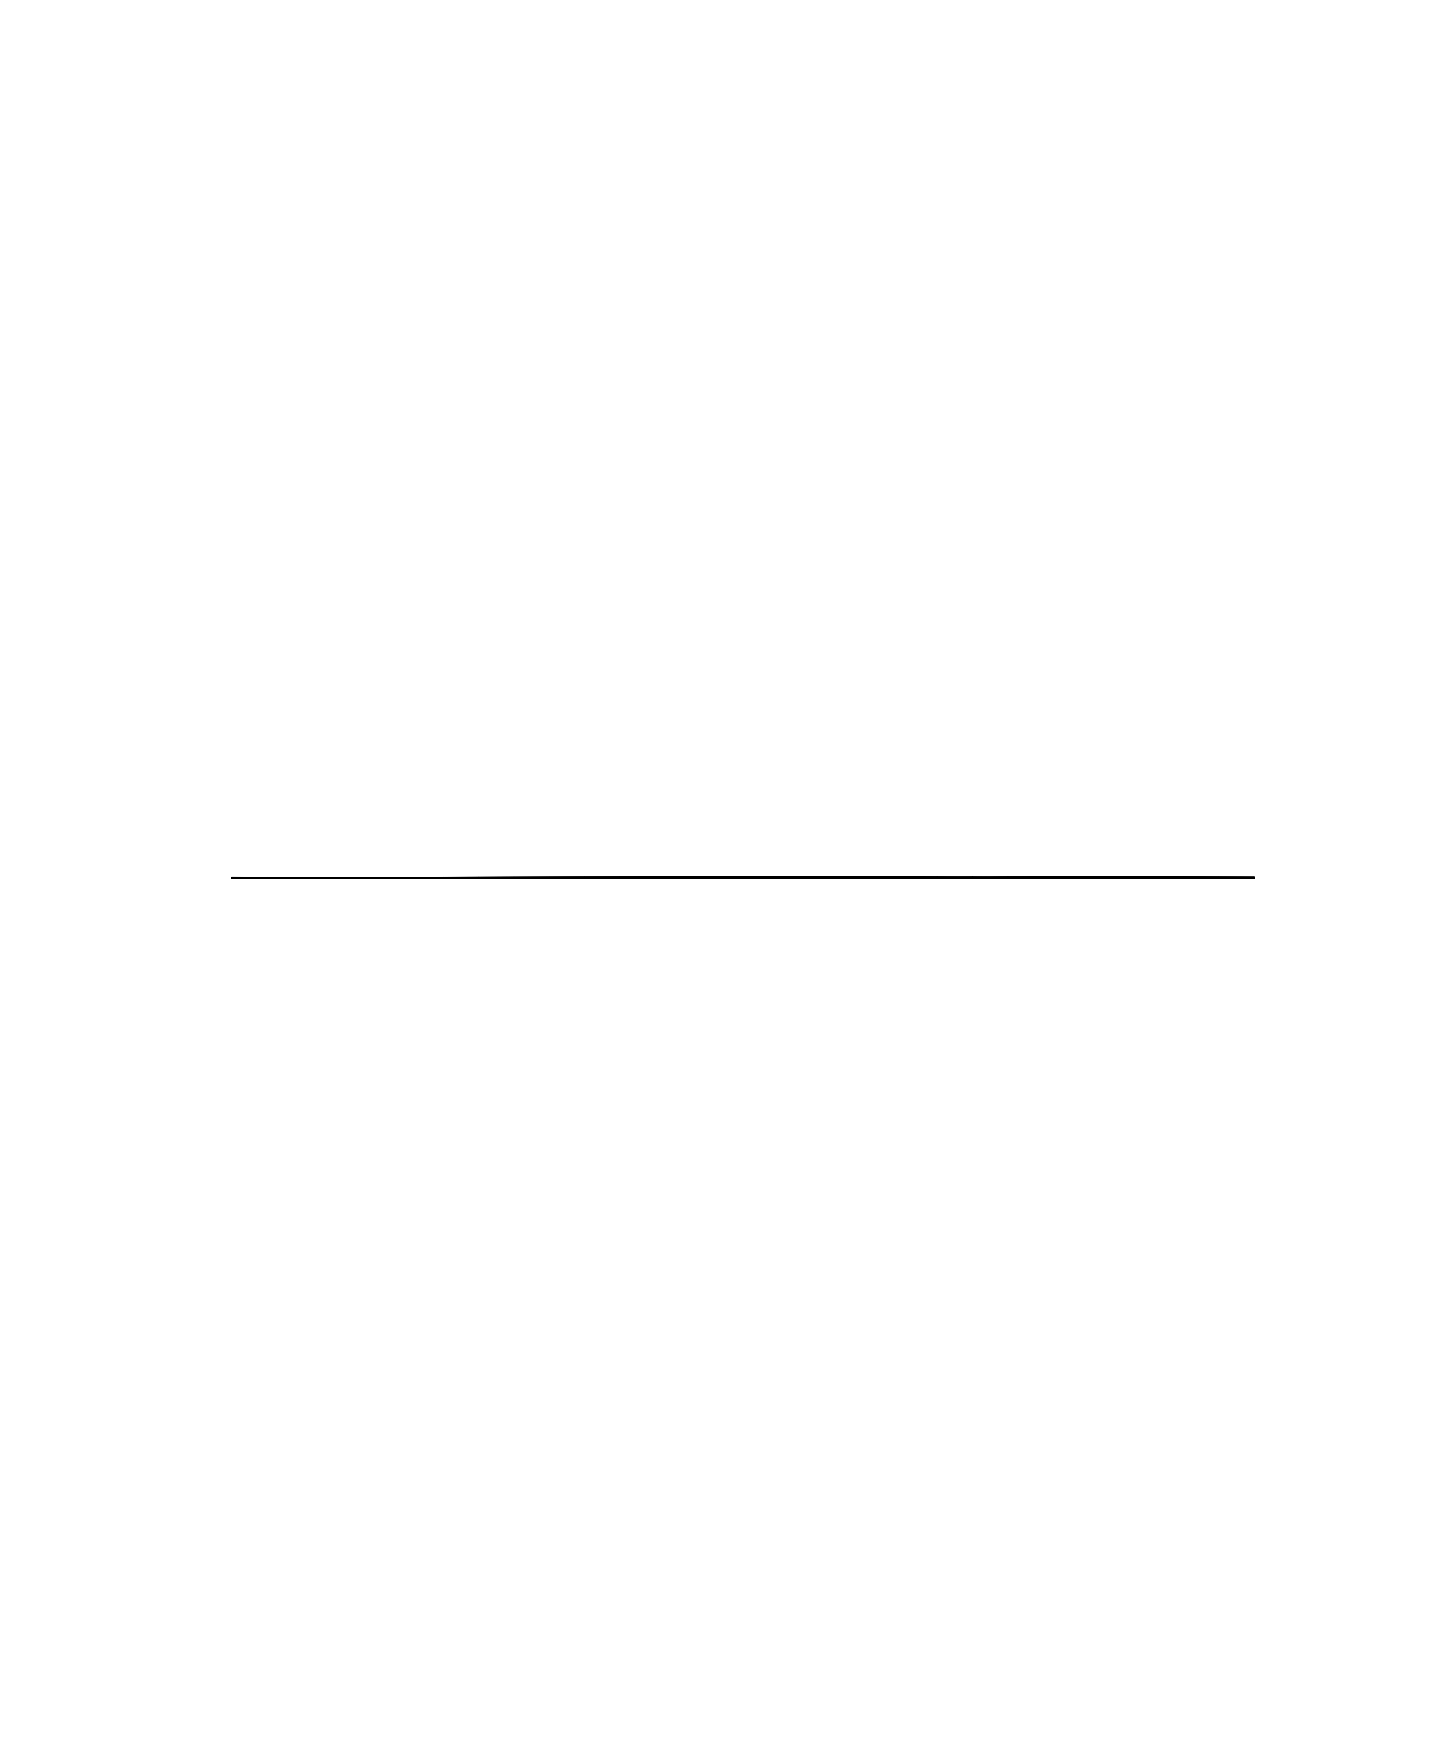

In [32]:
print(phi_inv[:,2].shape)
plot_diffeo_custom((phi_inv).cpu().numpy()[:,2],None)
#plot_diffeo_custom((phi_inv-get_idty(height,width,depth,device)).cpu().numpy()[:,2],None)

<IPython.core.display.Javascript object>


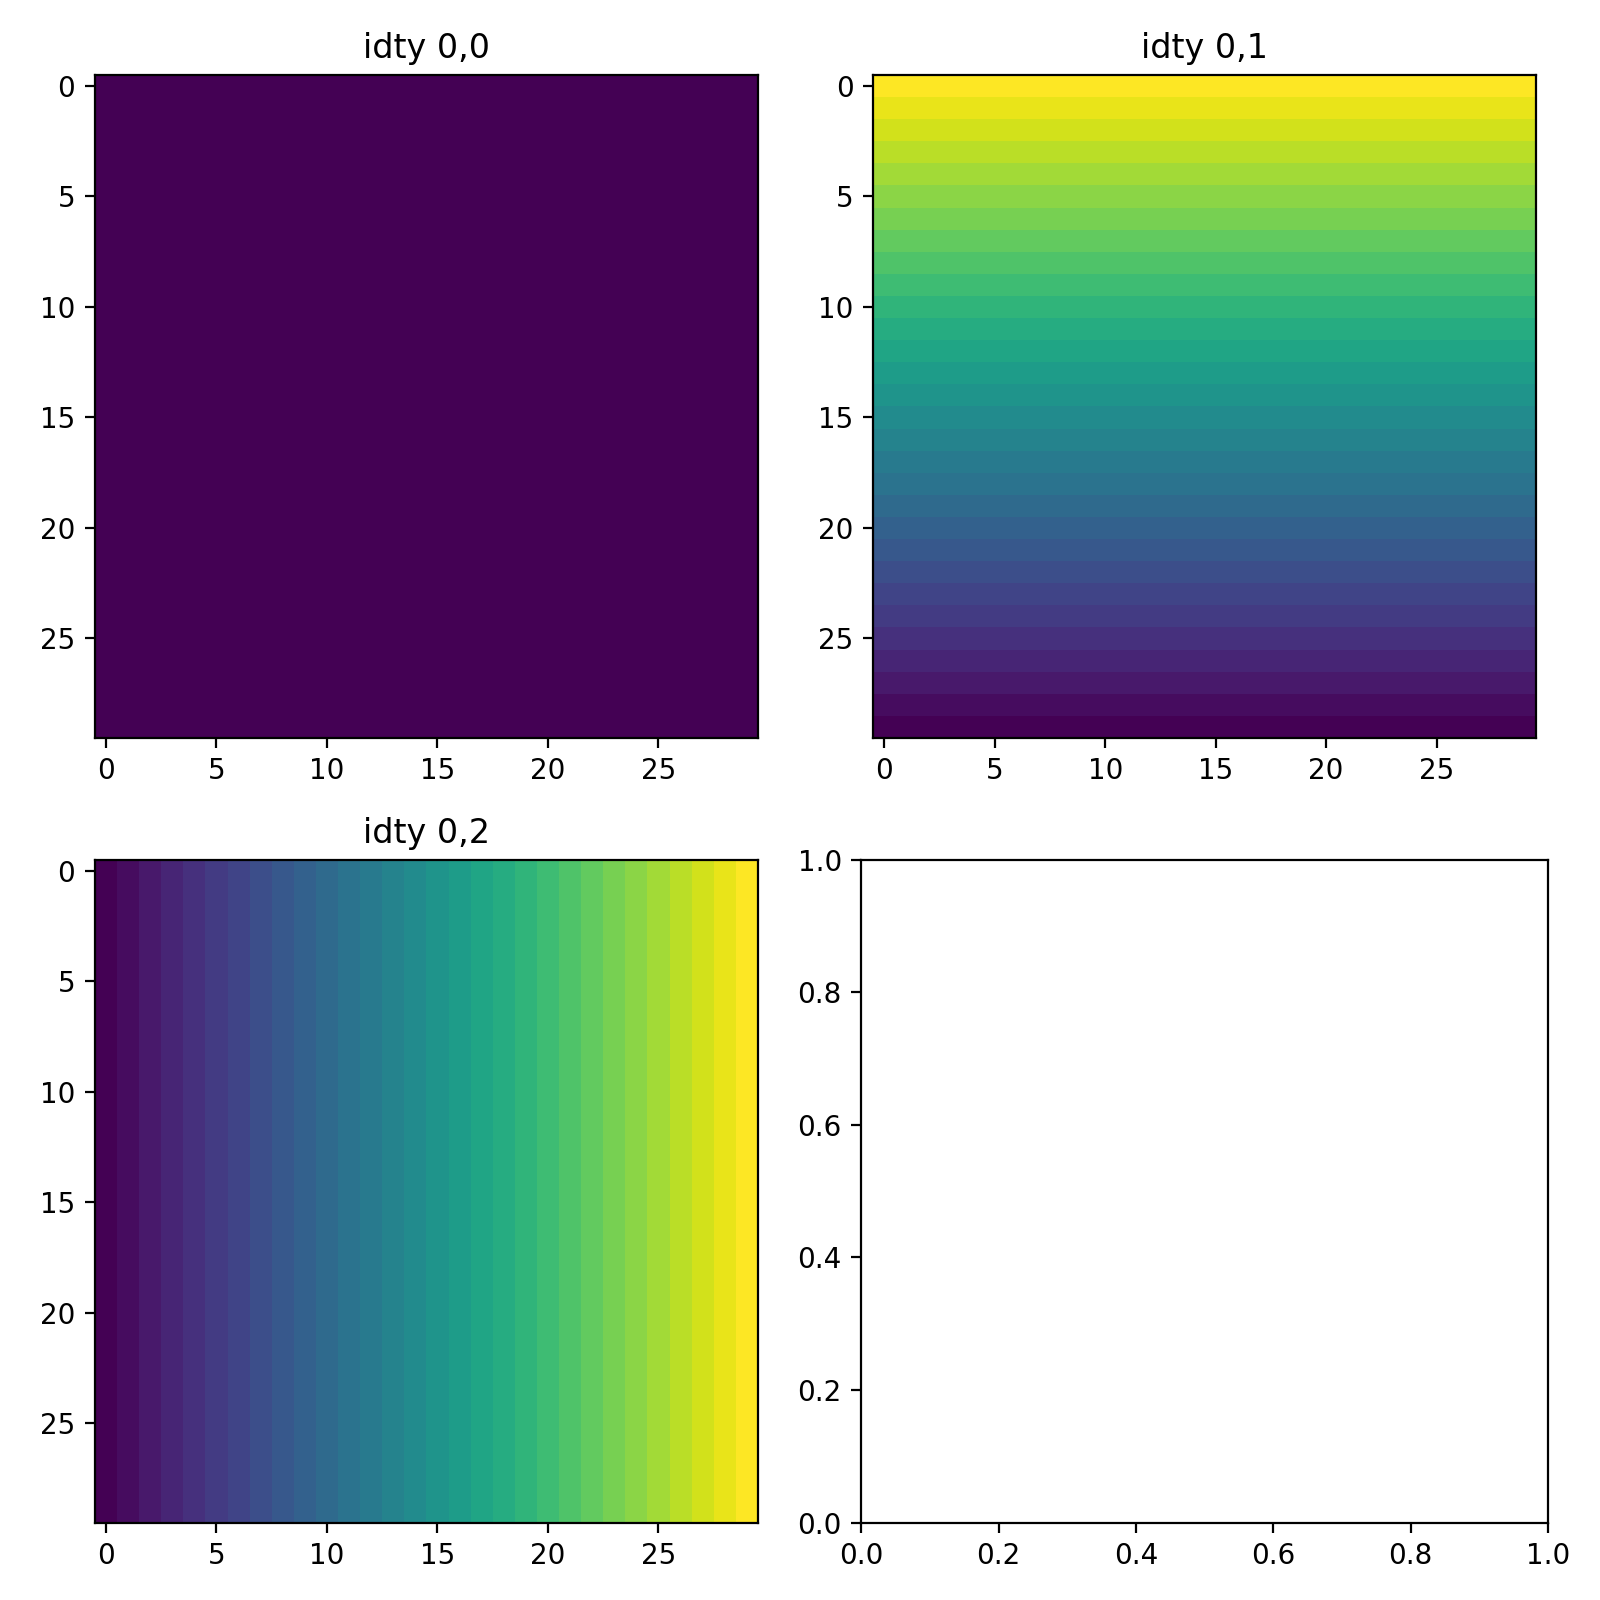

In [33]:
f, axes = plt.subplots(2, 2, figsize=(8,8))
idty = get_idty(height, width, depth, device)
axes[0,0].imshow(idty.cpu().detach().numpy()[0,2,::-1,:])
axes[0,0].set_title('idty 0,0')
axes[0,1].imshow(idty.cpu().detach().numpy()[1,2,::-1,:])
axes[0,1].set_title('idty 0,1')
axes[1,0].imshow(idty.cpu().detach().numpy()[2,2,::-1,:])
axes[1,0].set_title('idty 0,2')
plt.tight_layout()
if save_figs:
  file_name = f'{figdir}/idty.png'  
  f.savefig(file_name, bbox_inches='tight', pad_inches=0, 
            dpi=400, transparent=True)

<IPython.core.display.Javascript object>


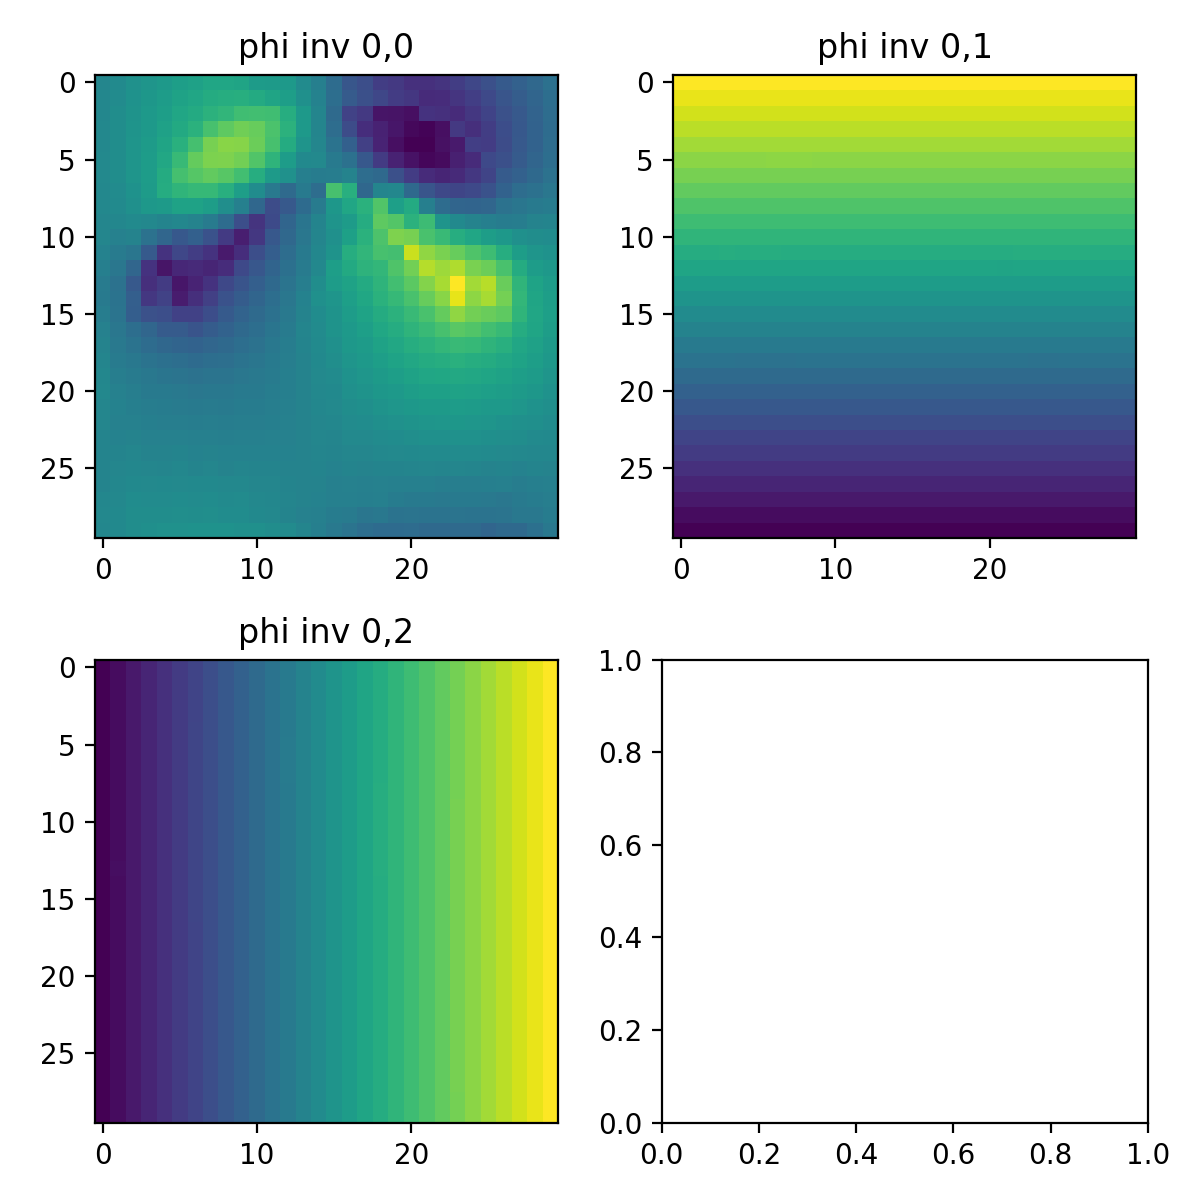

In [34]:
f, axes = plt.subplots(2, 2, figsize=(6,6))
idty = get_idty(height, width, depth, device)
axes[0,0].imshow(phi_inv.cpu().detach().numpy()[0,2,::-1,:])
axes[0,0].set_title('phi inv 0,0')
axes[0,1].imshow(phi_inv.cpu().detach().numpy()[1,2,::-1,:])
axes[0,1].set_title('phi inv 0,1')
axes[1,0].imshow(phi_inv.cpu().detach().numpy()[2,2,::-1,:])
axes[1,0].set_title('phi inv 0,2')
plt.tight_layout()
if save_figs:
  file_name = f'{figdir}/ann_1_2_phi_inv.png'  
  f.savefig(file_name, bbox_inches='tight', pad_inches=0, 
            dpi=400, transparent=True)

g0.shape torch.Size([5, 30, 30, 3, 3])
g1.shape torch.Size([5, 30, 30, 3, 3])


<IPython.core.display.Javascript object>


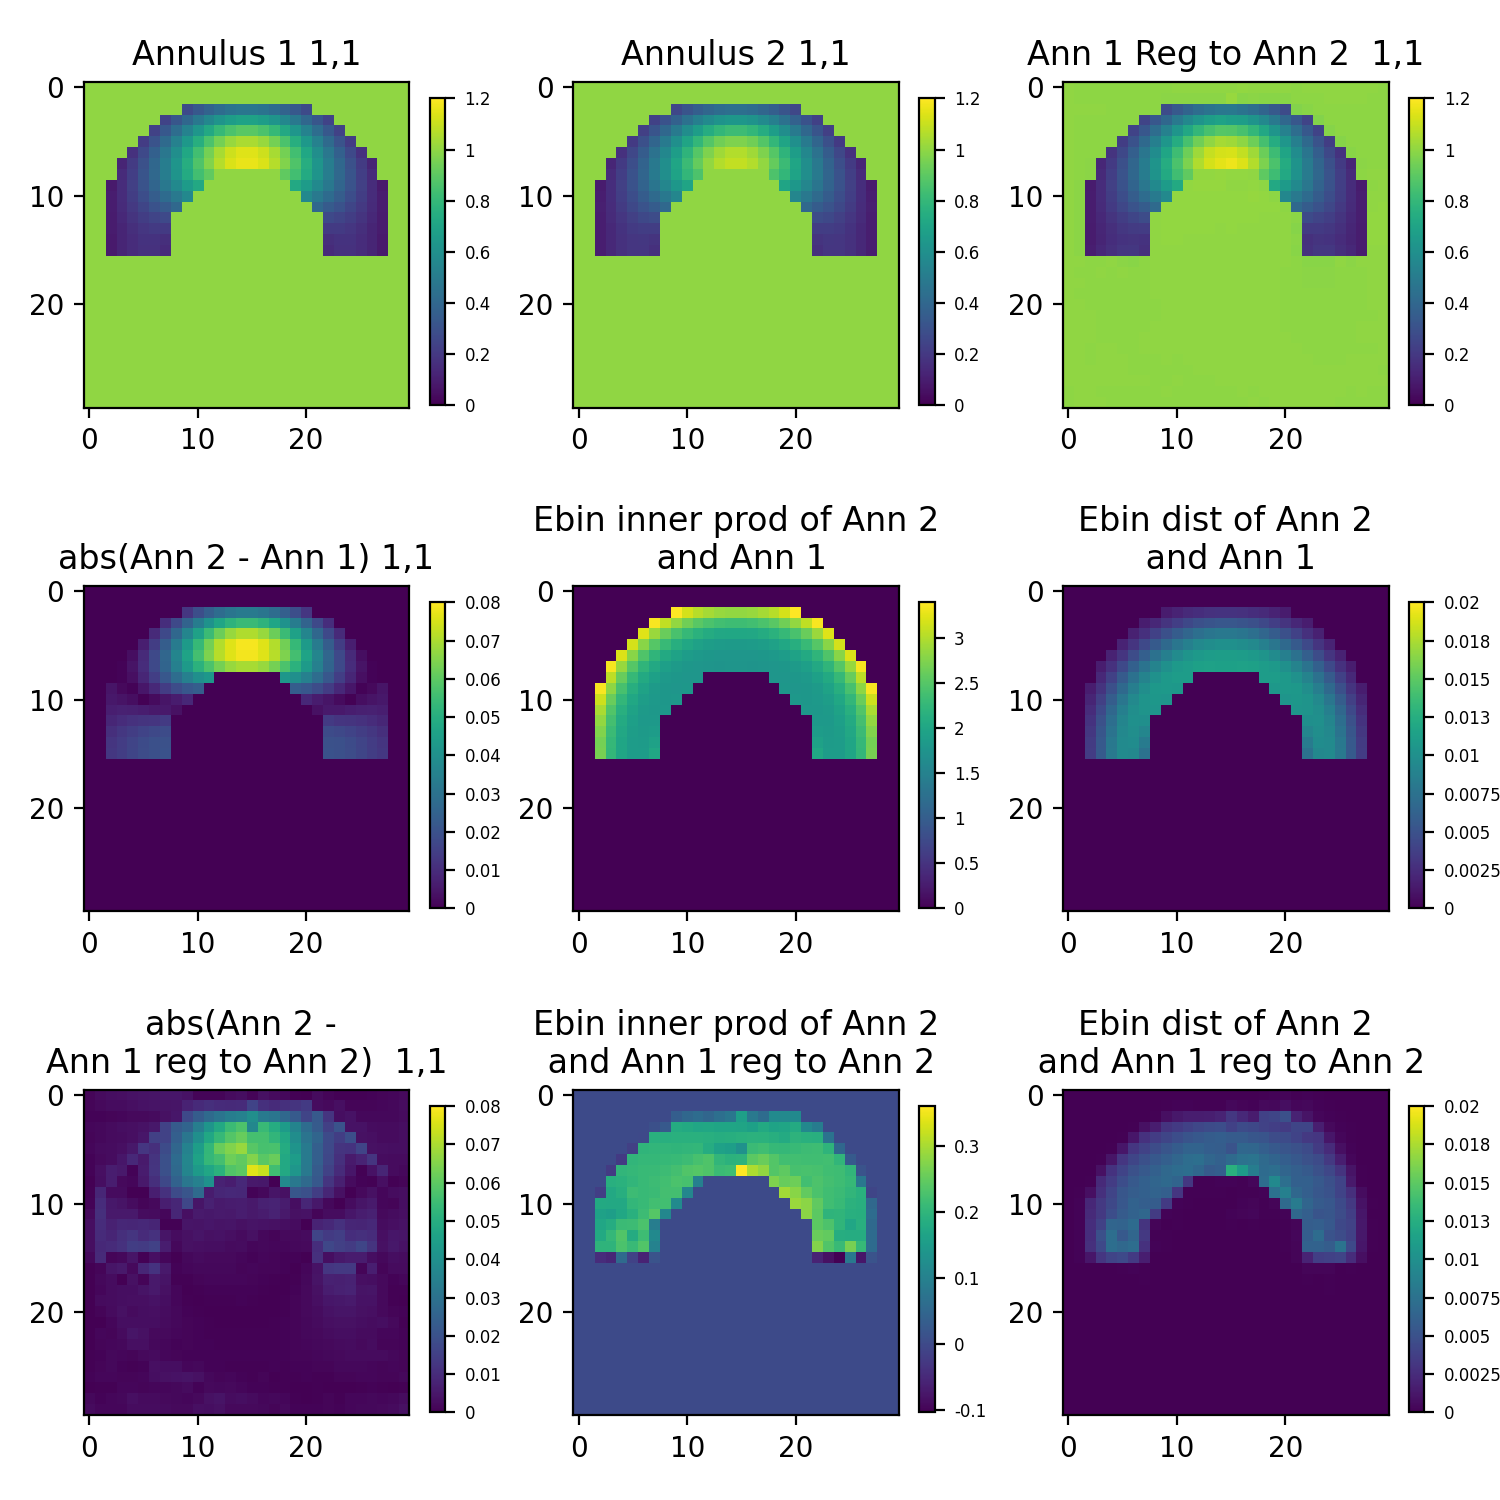

In [35]:
reg_ann1_ann2_dist = Squared_distance_Ebin_field(ann1_reg_to_ann2_met, ann2_met, 1.0/3.0, torch.from_numpy(mask_all_np).double().permute(2,1,0).to(device))
reg_ann2_ann1_logmap = inv_RieExp_extended(ann2_met, ann1_reg_to_ann2_met, 1.0/3.0)

reg_ann1_ann2_innerprod = Ebin_inner_prod(ann2_met, ann2_logmap, reg_ann2_ann1_logmap, torch.from_numpy(ann1_mask_np).double().permute(2,1,0).to(device))

xidx=1
yidx=1
f, axes = plt.subplots(3, 3, figsize=(7.5,7.5))
im0 = axes[0,0].imshow(ann1_met.cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=1.2)
axes[0,0].set_title(f'Annulus 1 {xidx},{yidx}')

im1 = axes[0,1].imshow(ann2_met.cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=1.2)
axes[0,1].set_title(f'Annulus 2 {xidx},{yidx}')

im2 = axes[0,2].imshow(ann1_reg_to_ann2_met.cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=1.2)
axes[0,2].set_title(f'Ann 1 Reg to Ann 2  {xidx},{yidx}')

im3 = axes[1,0].imshow(torch.abs(ann2_met-ann1_met).cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=0.08)
axes[1,0].set_title(f'abs(Ann 2 - Ann 1) {xidx},{yidx}')

im4 = axes[1,1].imshow(ann2_ann1_innerprod.cpu().detach().numpy()[2,::-1])
axes[1,1].set_title('Ebin inner prod of Ann 2\n and Ann 1')

im5 = axes[1,2].imshow(ann1_ann2_dist.cpu().detach().numpy()[2,::-1],vmin=0,vmax=0.02)
axes[1,2].set_title('Ebin dist of Ann 2\n and Ann 1')

im6 = axes[2,0].imshow(torch.abs(ann2_met-ann1_reg_to_ann2_met).cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=0.08)
axes[2,0].set_title(f'abs(Ann 2 - \nAnn 1 reg to Ann 2)  {xidx},{yidx}')

im7 = axes[2,1].imshow(reg_ann1_ann2_innerprod.cpu().detach().numpy()[2,::-1])
axes[2,1].set_title('Ebin inner prod of Ann 2\n and Ann 1 reg to Ann 2')

im8 = axes[2,2].imshow(reg_ann1_ann2_dist.cpu().detach().numpy()[2,::-1],vmin=0,vmax=0.02)
axes[2,2].set_title('Ebin dist of Ann 2\n and Ann 1 reg to Ann 2')

plt.tight_layout()

cbar=f.colorbar(im0, ax=axes[0,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im1, ax=axes[0,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im2, ax=axes[0,2],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im3, ax=axes[1,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im4, ax=axes[1,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im5, ax=axes[1,2],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im6, ax=axes[2,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im7, ax=axes[2,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im8, ax=axes[2,2],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)

if save_figs:
  file_name = f'{figdir}/ann_1_registered_to_ann_2_distances.png'  
  f.savefig(file_name, bbox_inches='tight', pad_inches=0, 
            dpi=400, transparent=True)


# Do Atlas Building instead
- Use metric to compute mean
- Don't use metric distance for matching, only use image term for matching

In [27]:
tensor_met_list, mask_list, img_list, fa_list = [], [], [], []
mask_union = torch.zeros(height, width, depth).double().to(device)
phi_inv_acc_list, phi_acc_list, met_energy_list, img_energy_list = [], [], [], []
sigma_list, eps_list, iters_list = [], [], []
metweight_list, imgweight_list = [], []
resume = False

mask_incl_all = torch.ones(height,width,depth).double().to(device)

#     create union of masks
#mask_union += ann1_mask
#mask_list.append(ann1_mask)
#mask_union += ann2_mask
#mask_list.append(ann2_mask)
mask_union += mask_incl_all
mask_list.append(mask_incl_all)
mask_union += mask_incl_all
mask_list.append(mask_incl_all)

img_list.append(ann1_img)
img_list.append(ann2_img)

fa_list.append(fractional_anisotropy(ann1_met))
fa_list.append(fractional_anisotropy(ann2_met))
tensor_met_list.append(ann1_met)
tensor_met_list.append(ann2_met)
#     initialize the accumulative diffeomorphism    
if resume==False:
  print('start from identity')
  phi_inv_acc_list.append(get_idty(height, width, depth, device))
  phi_inv_acc_list.append(get_idty(height, width, depth, device))
  phi_acc_list.append(get_idty(height, width, depth,device))
  phi_acc_list.append(get_idty(height, width, depth,device))
else:
  print('start from checkpoint')
  phi_inv_acc_list.append(torch.from_numpy(sio.loadmat(f'{output_dir}/annulus1_{start_iter-1}_phi_inv.mat')['diffeo']))
  phi_acc_list.append(torch.from_numpy(sio.loadmat(f'{output_dir}/annulus1_{start_iter-1}_phi.mat')['diffeo']).to(device))
  phi_inv_acc_list.append(torch.from_numpy(sio.loadmat(f'{output_dir}/annulus2_{start_iter-1}_phi_inv.mat')['diffeo']))
  phi_acc_list.append(torch.from_numpy(sio.loadmat(f'{output_dir}/annulus2_{start_iter-1}_phi.mat')['diffeo']).to(device))
  tensor_met_list[0] = phi_pullback(phi_inv_acc_list[0], tensor_met_list[0])
  tensor_met_list[1] = phi_pullback(phi_inv_acc_list[1], tensor_met_list[1])
met_energy_list.append([])    
met_energy_list.append([])    
img_energy_list.append([])    
img_energy_list.append([])    
   
mask_union[mask_union>0] = 1  



start_iter = 0
iter_num = 10
registration_iters = 2
sample_num = len(tensor_met_list)
#dim, sigma, epsilon = 3., 1., 5e-3 # epsilon = 1e-4 ok, need more iters, same with 1e-3. 5e-3 borderline, 1e-2 starts to diverge
#dim, sigma, epsilon = 3., 0., 5e-3 # epsilon = 5e-3 ok, need more iters, 5e-1 blows up, 5e-2 worse than 5e-3, 5e-4 slower than 5e-3, 1e-2 seems best when sigma=1, but blows up when sigma=0, 5e-3 starts to blow up on edges when sigma=0
#dim, sigma, epsilon = 3., 0.5, 5e-3 # epsilon = 5e-3 ok, sigma = 0.01 not enough pressure, 0.1 better
#dim, sigma, epsilon = 3., 0.5, 5e-4 # epsilon = 5e-3 ok, sigma = 0.01 not enough pressure, 0.1 better, 0.5 ok
#dim, sigma, epsilon = 3., 0, 1e-4 # epsilon = 
#dim, sigma, epsilon = 3., 0.5, 5e-4 # epsilon = 
dim, sigma, epsilon = 3., 1, 1e-3 # epsilon = 
eps_list.append(epsilon)
sigma_list.append(sigma)
iters_list.append(iter_num)
met_weight, img_weight = 1.0, 0.0
met_weight, img_weight = 0.05, 1.0
metweight_list.append(met_weight)
imgweight_list.append(img_weight)

for i in tqdm(range(start_iter, start_iter+iter_num)):
   G = torch.stack(tuple(tensor_met_list))
     
   mask_union = (sum(mask_list)/len(mask_list)).to(device)

   print('\n\n main loop, iter', i, 'max G:', torch.max(G), 'max mask_union:', torch.max(mask_union), '\n\n')

   #atlas = get_karcher_mean_shuffle(G, 1./dim, device=cuda_dev)
   print("WARNING!!! NOT SHUFFLING FOR KARCHER MEAN!!!")
   atlas = get_karcher_mean(G, 1./dim, device=cuda_dev)
   mean_img = get_euclidean_mean(img_list)
   print('\n\n main loop, iter', i, 'max atlas:', torch.max(atlas), '\n\n')

   phi_inv_list, phi_list = [], []
    
   for s in range(sample_num):
     met_energy_list[s].append(torch.einsum("ijk...,lijk->",[(tensor_met_list[s] - atlas)**2, 
                                                             mask_union.unsqueeze(0)]).item())
     img_energy_list[s].append(torch.sum((img_list[s] - mean_img)**2).item())
    
     tensor_met_list[s], img_list[s], mask_list[s], phi, phi_inv, v = metric_matching(tensor_met_list[s], atlas, 
                                                                                      img_list[s], mean_img, 
                                                                                      height, width, depth, 
                                                                                      mask_list[s], mask_union, 
                                                                                      registration_iters, 
                                                                                      epsilon, sigma, dim,
                                                                                      met_weight, img_weight)
     phi_inv_list.append(phi_inv)
     phi_list.append(phi)
     phi_inv_acc_list[s] = compose_function(phi_inv_acc_list[s], phi_inv_list[s])
     phi_acc_list[s] = compose_function(phi_list[s], phi_acc_list[s])
    
    

start from identity


  0%|                                                                                     | 0/10 [00:00<?, ?it/s]



 main loop, iter 0 max G: tensor(1.1691) max mask_union: tensor(1.) 


WARNING!!! NOT SHUFFLING FOR KARCHER MEAN!!!


 main loop, iter 0 max atlas: tensor(1.1321) 


WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
tensor(5.3291e-12, grad_fn=<DotBackward>) tensor(1.7833, grad_fn=<DotBackward>) tensor(0., grad_fn=<SumBackward0>) prescaled
tensor(5.3291e-12, grad_fn=<MulBackward0>) tensor(0.0892, grad_fn=<MulBackward0>) tensor(0., grad_fn=<MulBackward0>) DIFFERENT THAN HDAI VERSION
0.08

 10%|███████▋                                                                     | 1/10 [00:01<00:13,  1.54s/it]

metric_matching, energy is 0.08916980188095994 and epsilon is 0.001
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


 main loop, iter 1 max G: tensor(1.1691) max mask_union: tensor(1.0000) 


WARNING!!! NOT SHU

 20%|███████████████▍                                                             | 2/10 [00:03<00:12,  1.61s/it]

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


 main loop, iter 2 max G: tensor(1.1691) max mask_union: tensor(1.0000) 


WARNING!!! NOT SHUFFLING FOR KARCHER MEAN!!!


 main loop, iter 2 max atlas: tensor(1.

 30%|███████████████████████                                                      | 3/10 [00:04<00:11,  1.69s/it]

metric_matching, energy is 0.4277349400017515 and epsilon is 0.001
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


 main loop, iter 3 max G: tensor(1.1691) max mask_union: tensor(1.0000) 


WARNING!!! NOT SHUF

 40%|██████████████████████████████▊                                              | 4/10 [00:06<00:10,  1.68s/it]

metric_matching, energy is 0.4204262277114777 and epsilon is 0.001
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


 main loop, iter 4 max G: tensor(1.1691) max mask_union: tensor(1.0000) 


WARNING!!! NOT SHUF

 50%|██████████████████████████████████████▌                                      | 5/10 [00:08<00:08,  1.69s/it]

metric_matching, energy is 0.42337418506736824 and epsilon is 0.001
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


 main loop, iter 5 max G: tensor(1.1691) max mask_union: tensor(1.0000) 


WARNING!!! NOT SHU

 60%|██████████████████████████████████████████████▏                              | 6/10 [00:10<00:06,  1.69s/it]

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


 main loop, iter 6 max G: tensor(1.1691) max mask_union: tensor(1.0000) 


WARNING!!! NOT SHUFFLING FOR KARCHER MEAN!!!


 main loop, iter 6 max atlas: tensor(1.

 70%|█████████████████████████████████████████████████████▉                       | 7/10 [00:11<00:05,  1.68s/it]

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


 main loop, iter 7 max G: tensor(1.1691) max mask_union: tensor(1.0000) 


WARNING!!! NOT SHUFFLING FOR KARCHER MEAN!!!


 main loop, iter 7 max atlas: tensor(1.

 80%|█████████████████████████████████████████████████████████████▌               | 8/10 [00:13<00:03,  1.68s/it]

metric_matching, energy is 0.41901677543620014 and epsilon is 0.001
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


 main loop, iter 8 max G: tensor(1.1691) max mask_union: tensor(1.0000) 


WARNING!!! NOT SHU

 90%|█████████████████████████████████████████████████████████████████████▎       | 9/10 [00:15<00:01,  1.69s/it]

WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


 main loop, iter 9 max G: tensor(1.1691) max mask_union: tensor(1.0000) 


WARNING!!! NOT SHUFFLING FOR KARCHER MEAN!!!


 main loop, iter 9 max atlas: tensor(1.

100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]

metric_matching, energy is 0.42006885775896147 and epsilon is 0.001
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in
WARNING!!! mask ignored in compose_function, change signature so no longer needed to pass in


<IPython.core.display.Javascript object>


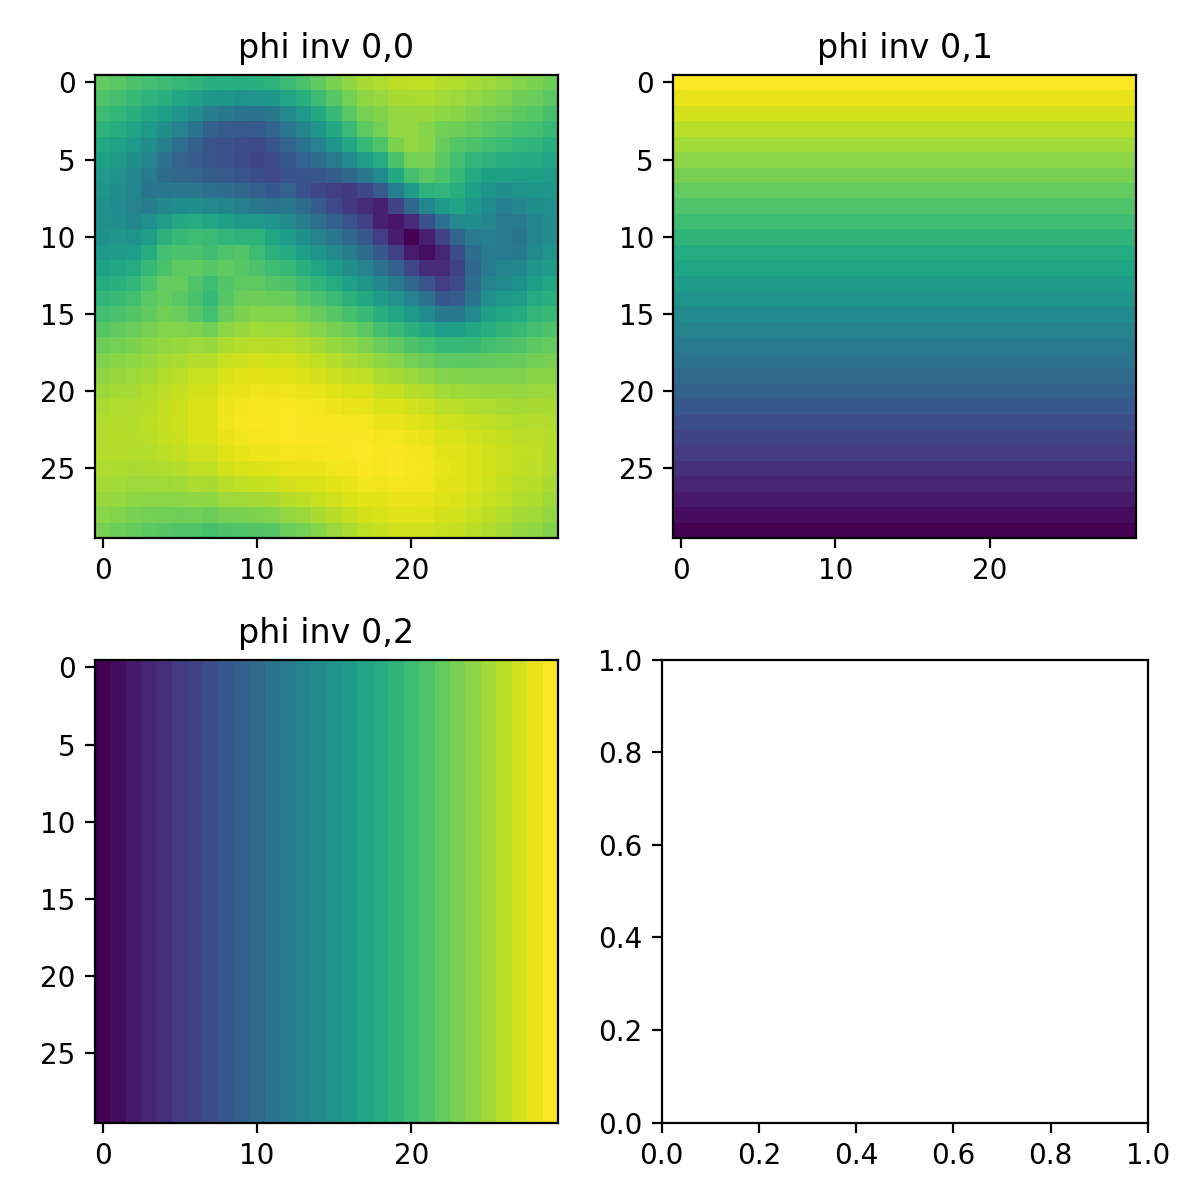

In [30]:
f, axes = plt.subplots(2, 2, figsize=(6,6))
idty = get_idty(height, width, depth, device)
axes[0,0].imshow(phi_inv.cpu().detach().numpy()[0,2,::-1,:])
axes[0,0].set_title('phi inv 0,0')
axes[0,1].imshow(phi_inv.cpu().detach().numpy()[1,2,::-1,:])
axes[0,1].set_title('phi inv 0,1')
axes[1,0].imshow(phi_inv.cpu().detach().numpy()[2,2,::-1,:])
axes[1,0].set_title('phi inv 0,2')
plt.tight_layout()
if save_figs:
  file_name = f'{figdir}/ann_1_2_phi_inv.png'  
  f.savefig(file_name, bbox_inches='tight', pad_inches=0, 
            dpi=400, transparent=True)

g0.shape torch.Size([5, 30, 30, 3, 3])
g1.shape torch.Size([5, 30, 30, 3, 3])
g0.shape torch.Size([5, 30, 30, 3, 3])
g1.shape torch.Size([5, 30, 30, 3, 3])
g0.shape torch.Size([5, 30, 30, 3, 3])
g1.shape torch.Size([5, 30, 30, 3, 3])
g0.shape torch.Size([5, 30, 30, 3, 3])
g1.shape torch.Size([5, 30, 30, 3, 3])


<IPython.core.display.Javascript object>


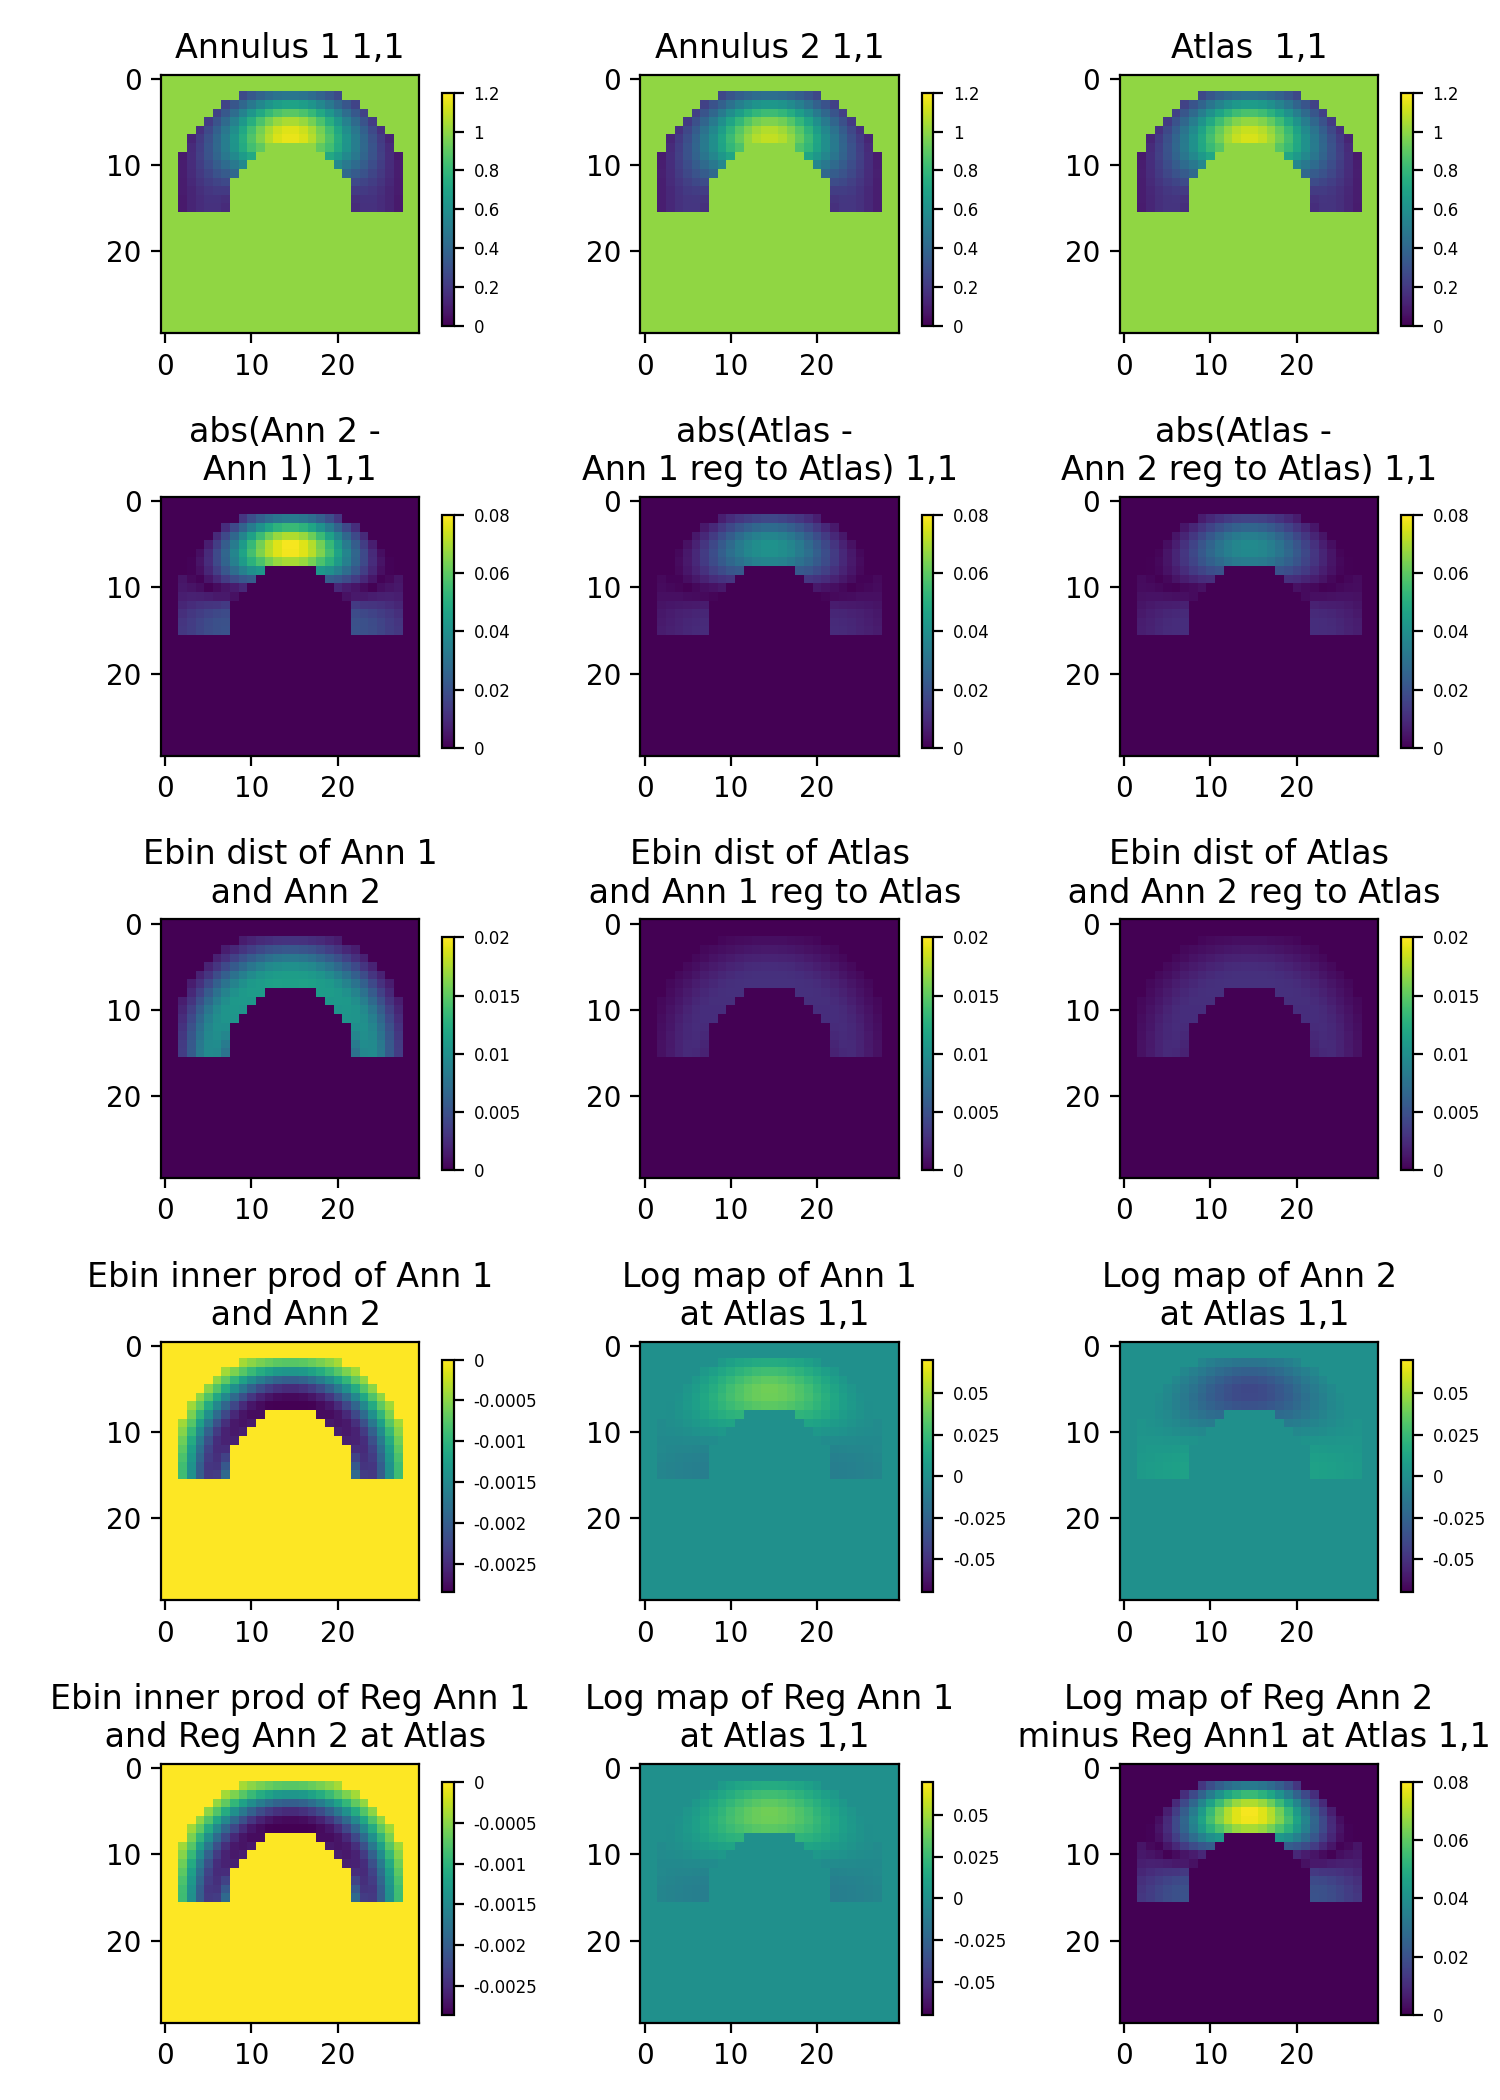

In [38]:
ann1_atlas_dist = Squared_distance_Ebin_field(atlas, ann1_met, 1.0/3.0, torch.from_numpy(mask_all_np).double().permute(2,1,0).to(device))
ann2_atlas_dist = Squared_distance_Ebin_field(atlas, ann2_met, 1.0/3.0, torch.from_numpy(mask_all_np).double().permute(2,1,0).to(device))
reg_ann1_atlas_dist = Squared_distance_Ebin_field(atlas, tensor_met_list[0], 1.0/3.0, torch.from_numpy(mask_all_np).double().permute(2,1,0).to(device))
reg_ann2_atlas_dist = Squared_distance_Ebin_field(atlas, tensor_met_list[1], 1.0/3.0, torch.from_numpy(mask_all_np).double().permute(2,1,0).to(device))
atlas_ann1_logmap = inv_RieExp_extended(atlas, ann1_met, 1.0/3.0)
atlas_ann2_logmap = inv_RieExp_extended(atlas, ann2_met, 1.0/3.0)
atlas_reg_ann1_logmap = inv_RieExp_extended(atlas, tensor_met_list[0], 1.0/3.0)
atlas_reg_ann2_logmap = inv_RieExp_extended(atlas, tensor_met_list[1], 1.0/3.0)

ann1_ann2_innerprod = Ebin_inner_prod(atlas, atlas_ann1_logmap, atlas_ann2_logmap, torch.from_numpy(ann1_mask_np).double().permute(2,1,0).to(device))
reg_ann1_ann2_innerprod = Ebin_inner_prod(atlas, atlas_reg_ann1_logmap, atlas_reg_ann2_logmap, torch.from_numpy(ann1_mask_np).double().permute(2,1,0).to(device))

xidx=1
yidx=1
f, axes = plt.subplots(5, 3, figsize=(7.5,10.5))
im0 = axes[0,0].imshow(ann1_met.cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=1.2)
axes[0,0].set_title(f'Annulus 1 {xidx},{yidx}')

im1 = axes[0,1].imshow(ann2_met.cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=1.2)
axes[0,1].set_title(f'Annulus 2 {xidx},{yidx}')

im2 = axes[0,2].imshow(atlas.cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=1.2)
axes[0,2].set_title(f'Atlas  {xidx},{yidx}')

im3 = axes[1,0].imshow(torch.abs(ann2_met-ann1_met).cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=0.08)
axes[1,0].set_title(f'abs(Ann 2 - \nAnn 1) {xidx},{yidx}')

im4 = axes[1,1].imshow(torch.abs(atlas-tensor_met_list[0]).cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=0.08)
axes[1,1].set_title(f'abs(Atlas - \nAnn 1 reg to Atlas) {xidx},{yidx}')

im5 = axes[1,2].imshow(torch.abs(atlas-tensor_met_list[1]).cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=0.08)
axes[1,2].set_title(f'abs(Atlas - \nAnn 2 reg to Atlas) {xidx},{yidx}')

im6 = axes[2,0].imshow(ann1_ann2_dist.cpu().detach().numpy()[2,::-1],vmin=0,vmax=0.02)
axes[2,0].set_title('Ebin dist of Ann 1\n and Ann 2')

im7 = axes[2,1].imshow(reg_ann1_atlas_dist.cpu().detach().numpy()[2,::-1],vmin=0,vmax=0.02)
axes[2,1].set_title('Ebin dist of Atlas\n and Ann 1 reg to Atlas')

im8 = axes[2,2].imshow(reg_ann2_atlas_dist.cpu().detach().numpy()[2,::-1],vmin=0,vmax=0.02)
axes[2,2].set_title('Ebin dist of Atlas\n and Ann 2 reg to Atlas')

im9 = axes[3,0].imshow(ann1_ann2_innerprod.cpu().detach().numpy()[2,::-1])
axes[3,0].set_title('Ebin inner prod of Ann 1\n and Ann 2')

im10 = axes[3,1].imshow(atlas_ann1_logmap.cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=-0.07,vmax=0.07)
axes[3,1].set_title(f'Log map of Ann 1\n at Atlas {xidx},{yidx}')

im11 = axes[3,2].imshow(atlas_ann2_logmap.cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=-0.07,vmax=0.07)
axes[3,2].set_title(f'Log map of Ann 2\n at Atlas {xidx},{yidx}')

im12 = axes[4,0].imshow(reg_ann1_ann2_innerprod.cpu().detach().numpy()[2,::-1])
axes[4,0].set_title('Ebin inner prod of Reg Ann 1\n and Reg Ann 2 at Atlas')

im13 = axes[4,1].imshow(atlas_reg_ann1_logmap.cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=-0.07,vmax=0.07)
axes[4,1].set_title(f'Log map of Reg Ann 1\n at Atlas {xidx},{yidx}')

#im14 = axes[4,2].imshow(atlas_reg_ann2_logmap.cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=-0.07,vmax=0.07)
#axes[4,2].set_title(f'Log map of Reg Ann 2\n at Atlas {xidx},{yidx}')
im14 = axes[4,2].imshow((torch.abs(atlas_reg_ann2_logmap-atlas_reg_ann1_logmap)).cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=0.08)
axes[4,2].set_title(f'Log map of Reg Ann 2\n minus Reg Ann1 at Atlas {xidx},{yidx}')


plt.tight_layout()

cbar=f.colorbar(im0, ax=axes[0,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im1, ax=axes[0,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im2, ax=axes[0,2],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im3, ax=axes[1,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im4, ax=axes[1,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im5, ax=axes[1,2],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im6, ax=axes[2,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im7, ax=axes[2,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im8, ax=axes[2,2],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im9, ax=axes[3,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im10, ax=axes[3,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im11, ax=axes[3,2],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im12, ax=axes[4,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im13, ax=axes[4,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im14, ax=axes[4,2],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)

if save_figs:
  file_name = f'{figdir}/ann_1_ann_2_registered_to_atlas_distances.png'  
  f.savefig(file_name, bbox_inches='tight', pad_inches=0, 
            dpi=400, transparent=True)


<IPython.core.display.Javascript object>


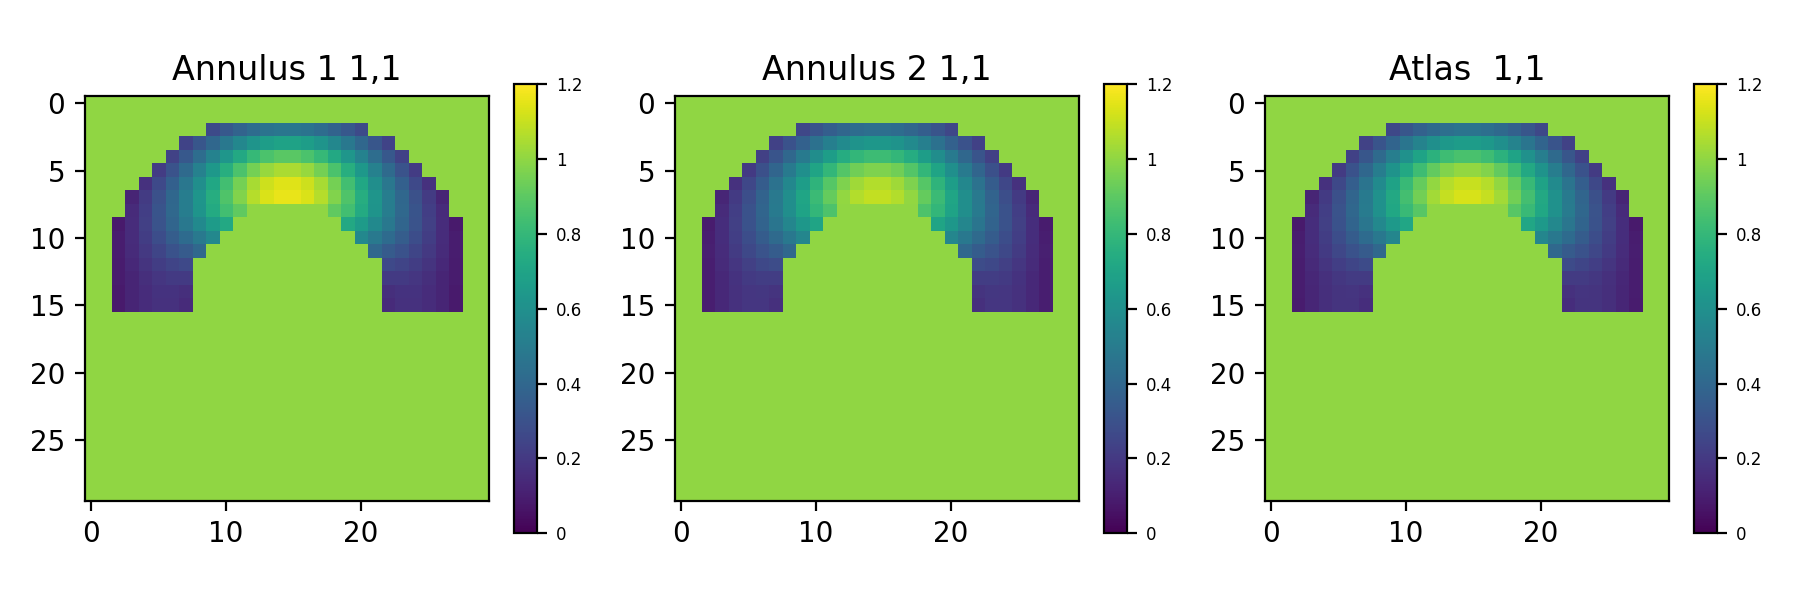

In [39]:
xidx=1
yidx=1

f, axes = plt.subplots(1, 3, figsize=(9,3))
im0 = axes[0].imshow(ann1_met.cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=1.2)
axes[0].set_title(f'Annulus 1 {xidx},{yidx}')

im1 = axes[1].imshow(ann2_met.cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=1.2)
axes[1].set_title(f'Annulus 2 {xidx},{yidx}')

im2 = axes[2].imshow(atlas.cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=1.2)
axes[2].set_title(f'Atlas  {xidx},{yidx}')

plt.tight_layout()

cbar=f.colorbar(im0, ax=axes[0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im1, ax=axes[1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im2, ax=axes[2],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)

if save_figs:
  file_name = f'{figdir}/ann_1_ann_2_atlas.png'  
  f.savefig(file_name, bbox_inches='tight', pad_inches=0, 
            dpi=400, transparent=True)


<IPython.core.display.Javascript object>


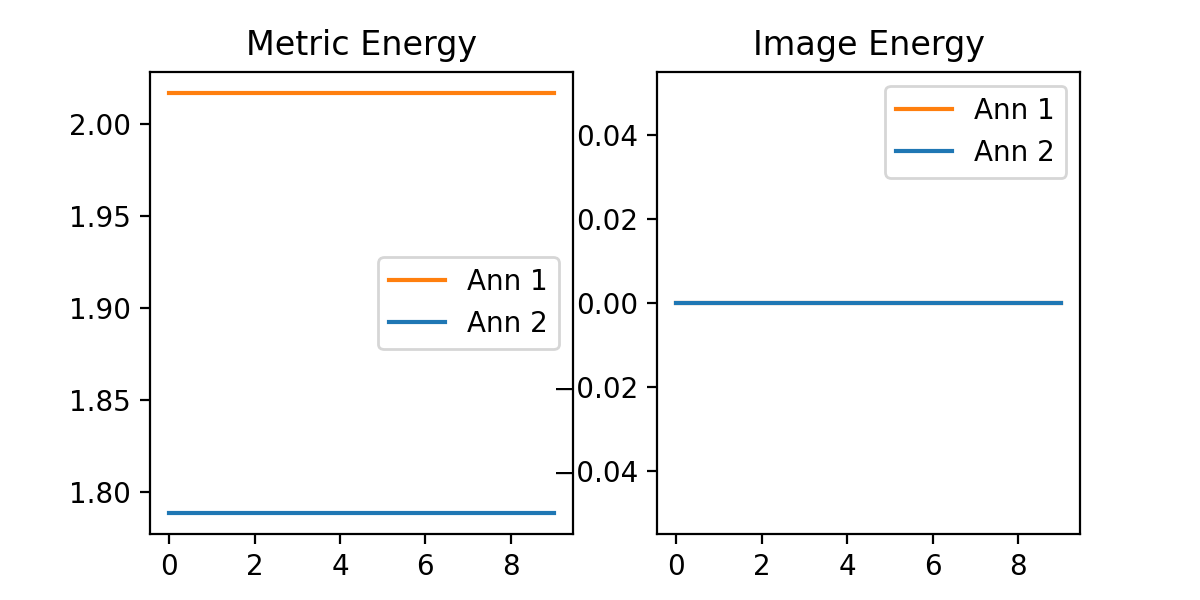

In [40]:
f, axes=plt.subplots(1,2,figsize=(6,3))
pl0 = axes[0].plot(met_energy_list[0],color=case_color, label='Ann 1')
pl0 = axes[0].plot(met_energy_list[1],color=ctrl_color, label='Ann 2')
axes[0].set_title('Metric Energy')
axes[0].legend()
pl1 = axes[1].plot(img_energy_list[0],color=case_color, label='Ann 1')
pl1 = axes[1].plot(img_energy_list[1],color=ctrl_color, label='Ann 2')
axes[1].set_title('Image Energy')
axes[1].legend()
plt.show()

In [41]:
inc = (1.161-1.092) / 2
print(inc, 1.161-inc, 1.161-2*inc)
print(ann1_met.shape)
invB = torch.inverse(ann1_met.reshape((-1,3,3))) 
invB_A = torch.einsum('...ij,...jk->...ik',invB, ann2_met.reshape((-1,3,3)))
print(invB_A.shape)
my_logm = np.vectorize(scipy.linalg.logm,signature='(m,m)->(m,m)')
my_logm_invB_A = my_logm(invB_A.cpu().detach().numpy())

0.034499999999999975 1.1265 1.092
torch.Size([5, 30, 30, 3, 3])
torch.Size([4500, 3, 3])


In [42]:
u = inv_RieExp_extended(ann1_met.reshape((-1,3,3)), ann2_met.reshape((-1,3,3)), 1.0 / 3.0).reshape((height,width,depth,3,3))
u_m0 = inv_RieExp_extended(ann1_met.reshape((-1,3,3)), m0.reshape((-1,3,3)), 1.0 / 3.0).reshape((height,width,depth,3,3))
mean = Rie_Exp_extended(ann1_met.reshape((-1,3,3)), u.reshape((-1,3,3)) / 2, 1.0/3.0).reshape((height,width,depth,3,3))
mean_m0 = Rie_Exp_extended(ann1_met.reshape((-1,3,3)), u_m0.reshape((-1,3,3)), 1.0/3.0).reshape((height,width,depth,3,3))


<IPython.core.display.Javascript object>


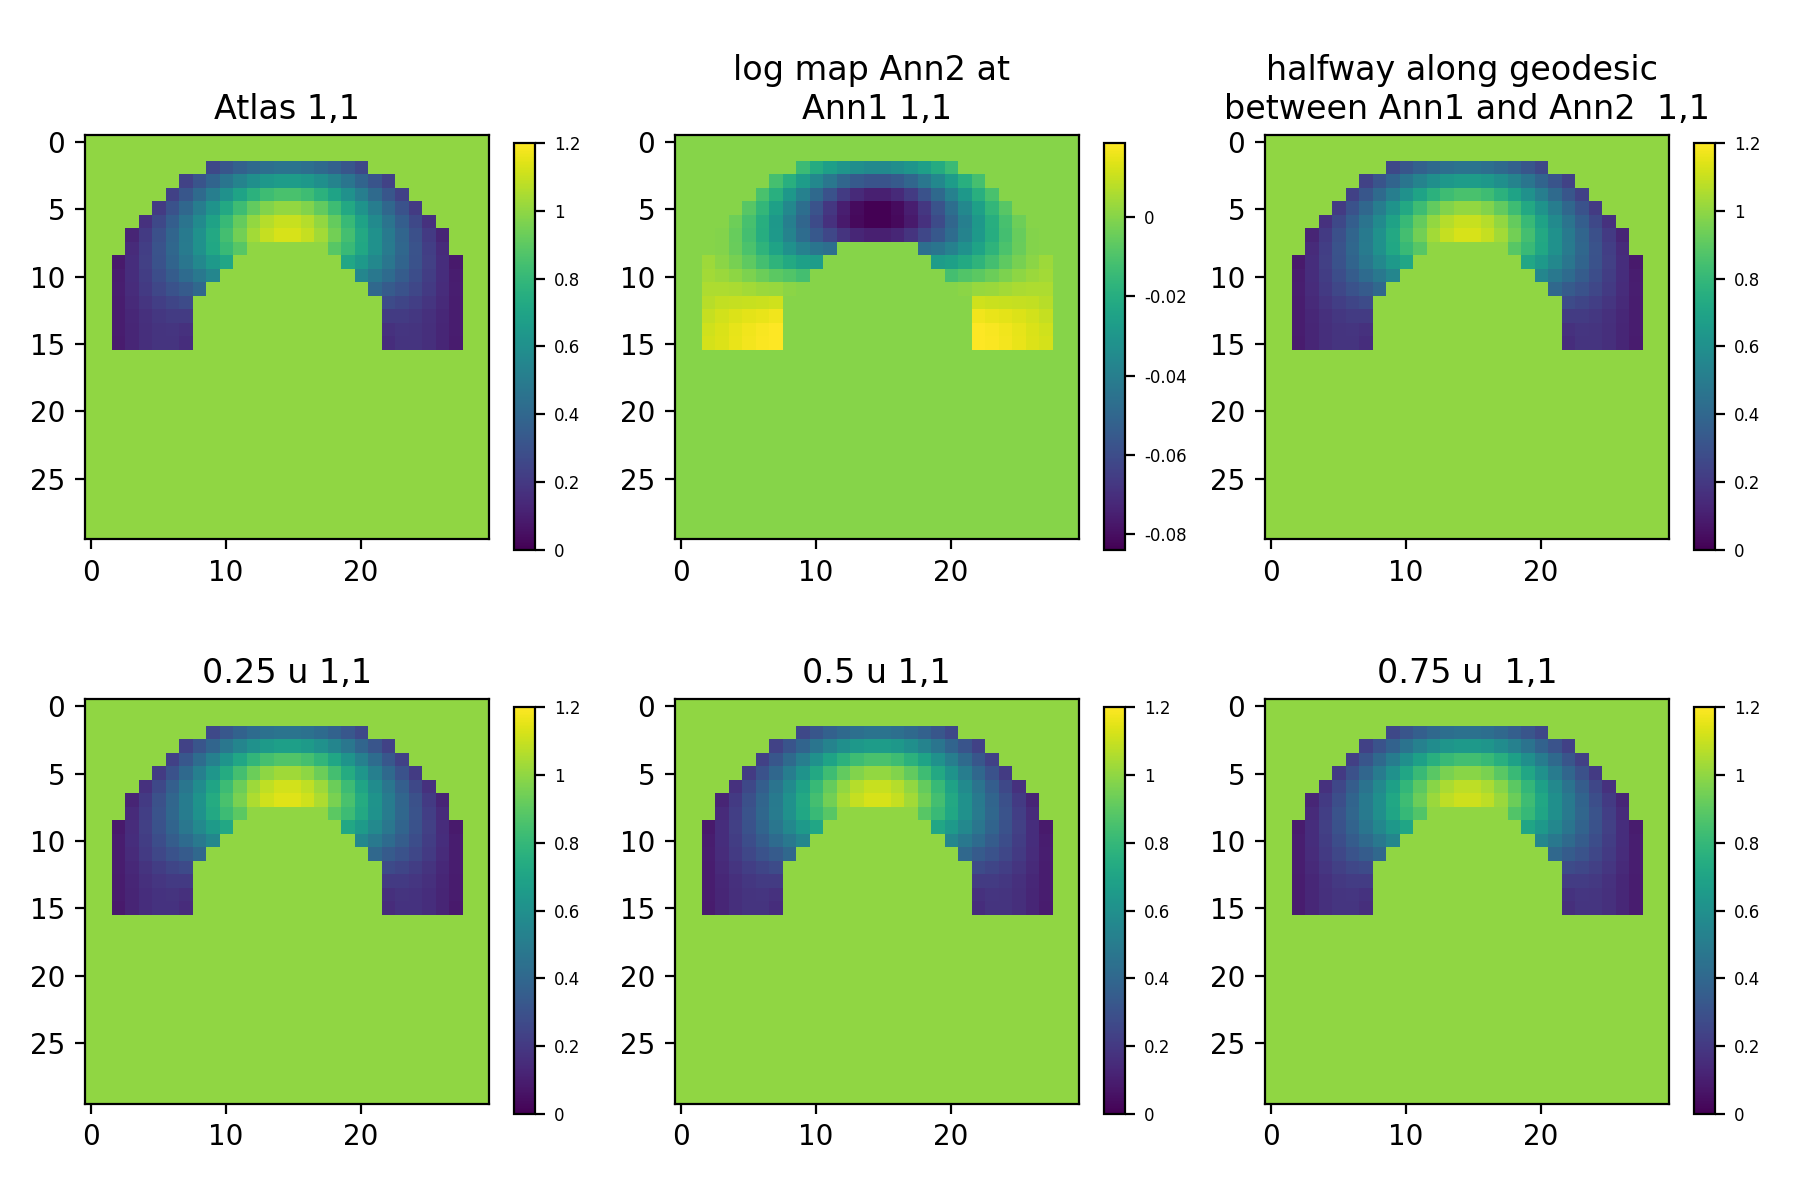

In [43]:
xidx=1
yidx=1

f, axes = plt.subplots(2, 3, figsize=(9,6))
im0 = axes[0,0].imshow(atlas.cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=1.2)
axes[0,0].set_title(f'Atlas {xidx},{yidx}')

im1 = axes[0,1].imshow(u.cpu().detach().numpy()[2,::-1,:,xidx,yidx])
axes[0,1].set_title(f'log map Ann2 at \nAnn1 {xidx},{yidx}')

im2 = axes[0,2].imshow(mean.cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=1.2)
axes[0,2].set_title(f'halfway along geodesic \nbetween Ann1 and Ann2  {xidx},{yidx}')

im3 = axes[1,0].imshow(Rie_Exp_extended(ann1_met, u / 4.0, 1.0/3.0).cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=1.2)
axes[1,0].set_title(f'0.25 u {xidx},{yidx}')

im4 = axes[1,1].imshow(Rie_Exp_extended(ann1_met, u / 2.0, 1.0/3.0).cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=1.2)
axes[1,1].set_title(f'0.5 u {xidx},{yidx}')

im5 = axes[1,2].imshow(Rie_Exp_extended(ann1_met, (3.0/4.0) * u, 1.0/3.0).cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=1.2)
axes[1,2].set_title(f'0.75 u  {xidx},{yidx}')


plt.tight_layout()

cbar=f.colorbar(im0, ax=axes[0,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im1, ax=axes[0,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im2, ax=axes[0,2],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im3, ax=axes[1,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im4, ax=axes[1,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im5, ax=axes[1,2],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)

if save_figs:
  file_name = f'{figdir}/debug_mean_calc.png'  
  f.savefig(file_name, bbox_inches='tight', pad_inches=0, 
            dpi=400, transparent=True)


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


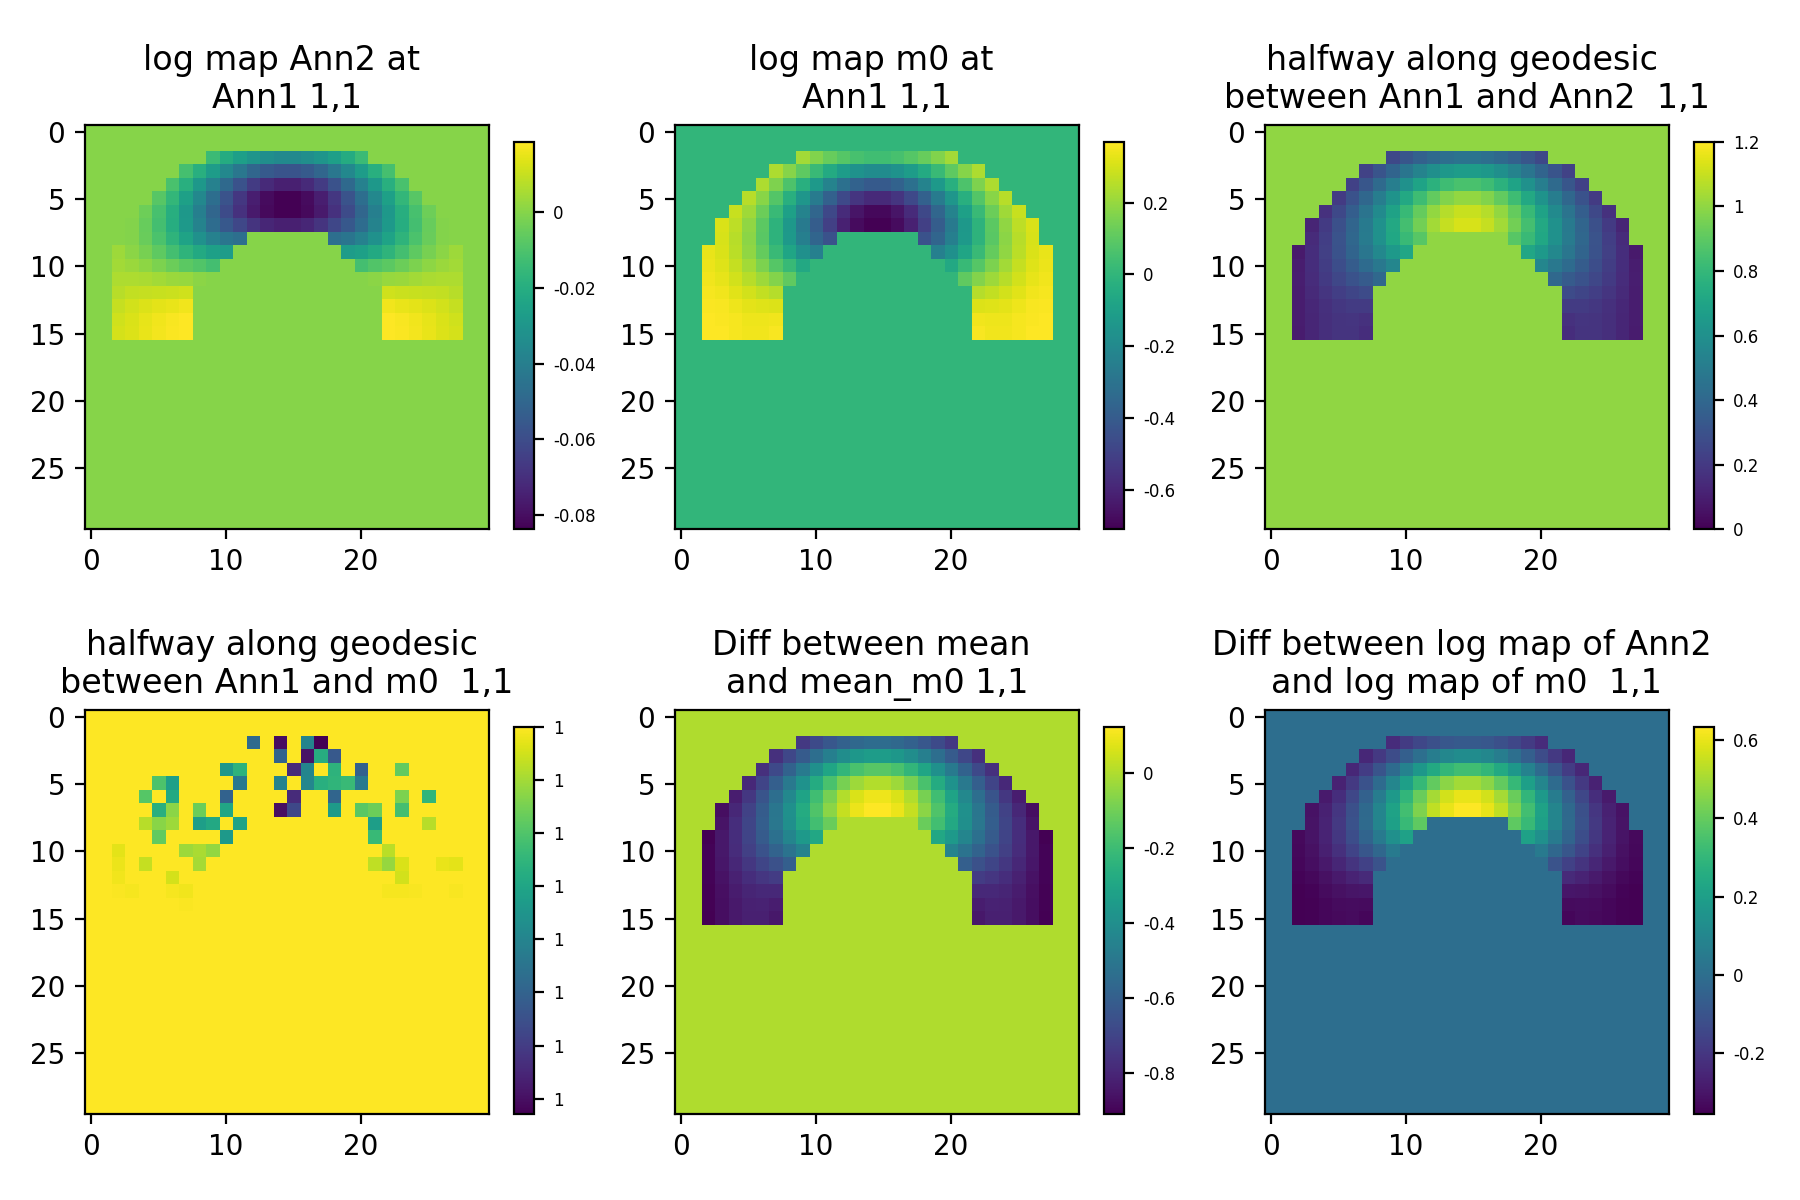

In [44]:
xidx=1
yidx=1

f, axes = plt.subplots(2, 3, figsize=(9,6))
im0 = axes[0,0].imshow(u.cpu().detach().numpy()[2,::-1,:,xidx,yidx])
axes[0,0].set_title(f'log map Ann2 at \nAnn1 {xidx},{yidx}')

im1 = axes[0,1].imshow(u_m0.cpu().detach().numpy()[2,::-1,:,xidx,yidx])
axes[0,1].set_title(f'log map m0 at \nAnn1 {xidx},{yidx}')

im2 = axes[0,2].imshow(mean.cpu().detach().numpy()[2,::-1,:,xidx,yidx],vmin=0,vmax=1.2)
axes[0,2].set_title(f'halfway along geodesic \nbetween Ann1 and Ann2  {xidx},{yidx}')

im3 = axes[1,0].imshow(mean_m0.cpu().detach().numpy()[2,::-1,:,xidx,yidx])
axes[1,0].set_title(f'halfway along geodesic \nbetween Ann1 and m0  {xidx},{yidx}')

im4 = axes[1,1].imshow((mean-mean_m0).cpu().detach().numpy()[2,::-1,:,xidx,yidx])
axes[1,1].set_title(f'Diff between mean \nand mean_m0 {xidx},{yidx}')

im5 = axes[1,2].imshow((u-u_m0).cpu().detach().numpy()[2,::-1,:,xidx,yidx])
axes[1,2].set_title(f'Diff between log map of Ann2 \nand log map of m0  {xidx},{yidx}')


plt.tight_layout()

cbar=f.colorbar(im0, ax=axes[0,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im1, ax=axes[0,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im2, ax=axes[0,2],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im3, ax=axes[1,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im4, ax=axes[1,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im5, ax=axes[1,2],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)

if save_figs:
  file_name = f'{figdir}/debug_mean_calc.png'  
  f.savefig(file_name, bbox_inches='tight', pad_inches=0, 
            dpi=400, transparent=True)


# Look at stats

In [45]:
def correct_pvals_BH_FDR(pvals, image_mask, FDR_thresh):
  # Extract the pvalues just where there is data for FDR correction
  # send in as 1-dimensional array
  # then pop results back into appropriate space for corrected pvals
  fdr_pvals = np.ones_like(pvals)
  mask_idx = np.where(image_mask > 0.5)
  #mask_pvals = pvals[mask_idx]
  #mask_shape = mask_pvals.shape
  #mask_pvals_1d = mask_pvals.ravel()
  mask_pvals_1d = pvals[mask_idx].ravel()

  # sort in ascending order
  idx_1d = np.argsort(mask_pvals_1d)

  num_tests = len(idx_1d)
  critical_vals = np.ones((num_tests,1))

  max_idx = -1
  for rank in range(1,num_tests+1):
    # critical value = (rank / num_tests) * FDR_threshold
    critical_vals[rank-1] = (rank / num_tests) * FDR_thresh
    if (mask_pvals_1d[rank-1] < critical_vals[rank-1]):
      max_idx = rank-1

  if max_idx > -1:    
    sig_pval = mask_pvals_1d[max_idx]
    print('significant p-value after FDR:', sig_pval)
    sig_idx = np.where(pvals <= sig_pval)
    fdr_pvals[sig_idx] = pvals[sig_idx]
    fdr_pvals[image_mask <= 0.5] = 1.0
  else:
    print('no significant p-values found after FDR')
  return(fdr_pvals)


In [46]:
diffmean = tens_3x3_to_tens_6((ann1_logmap - ann2_logmap).cpu().detach().numpy())
print(diffmean.shape) 
# scaling as if nx = ny = 10, p = 6
nx=10.0
ny=10.0
p=6
# simulating for more subjects, assuming identity covariance
invcov = np.zeros((diffmean.shape[0],diffmean.shape[1],diffmean.shape[2],p,p))
invcov[...,:,:] = np.eye(p)
t2 = ((nx*ny) / (nx+ny)) * np.einsum('...i,...ij,...j->...',diffmean, invcov, diffmean)
print(t2.shape)
fstat = (nx+ny-p-1) / ((nx+ny-2)*p) * t2
# dof as if nx = ny = 10, p = 6
dof = (p, nx+ny-p-1)
pvals = 2 * scipy.stats.f.sf(np.abs(fstat),dof[0],dof[1])
fdr_pvals = correct_pvals_BH_FDR(pvals, ann1_mask_np.transpose((2,1,0)), 0.05)

(5, 30, 30, 6)
(5, 30, 30)
no significant p-values found after FDR


<IPython.core.display.Javascript object>


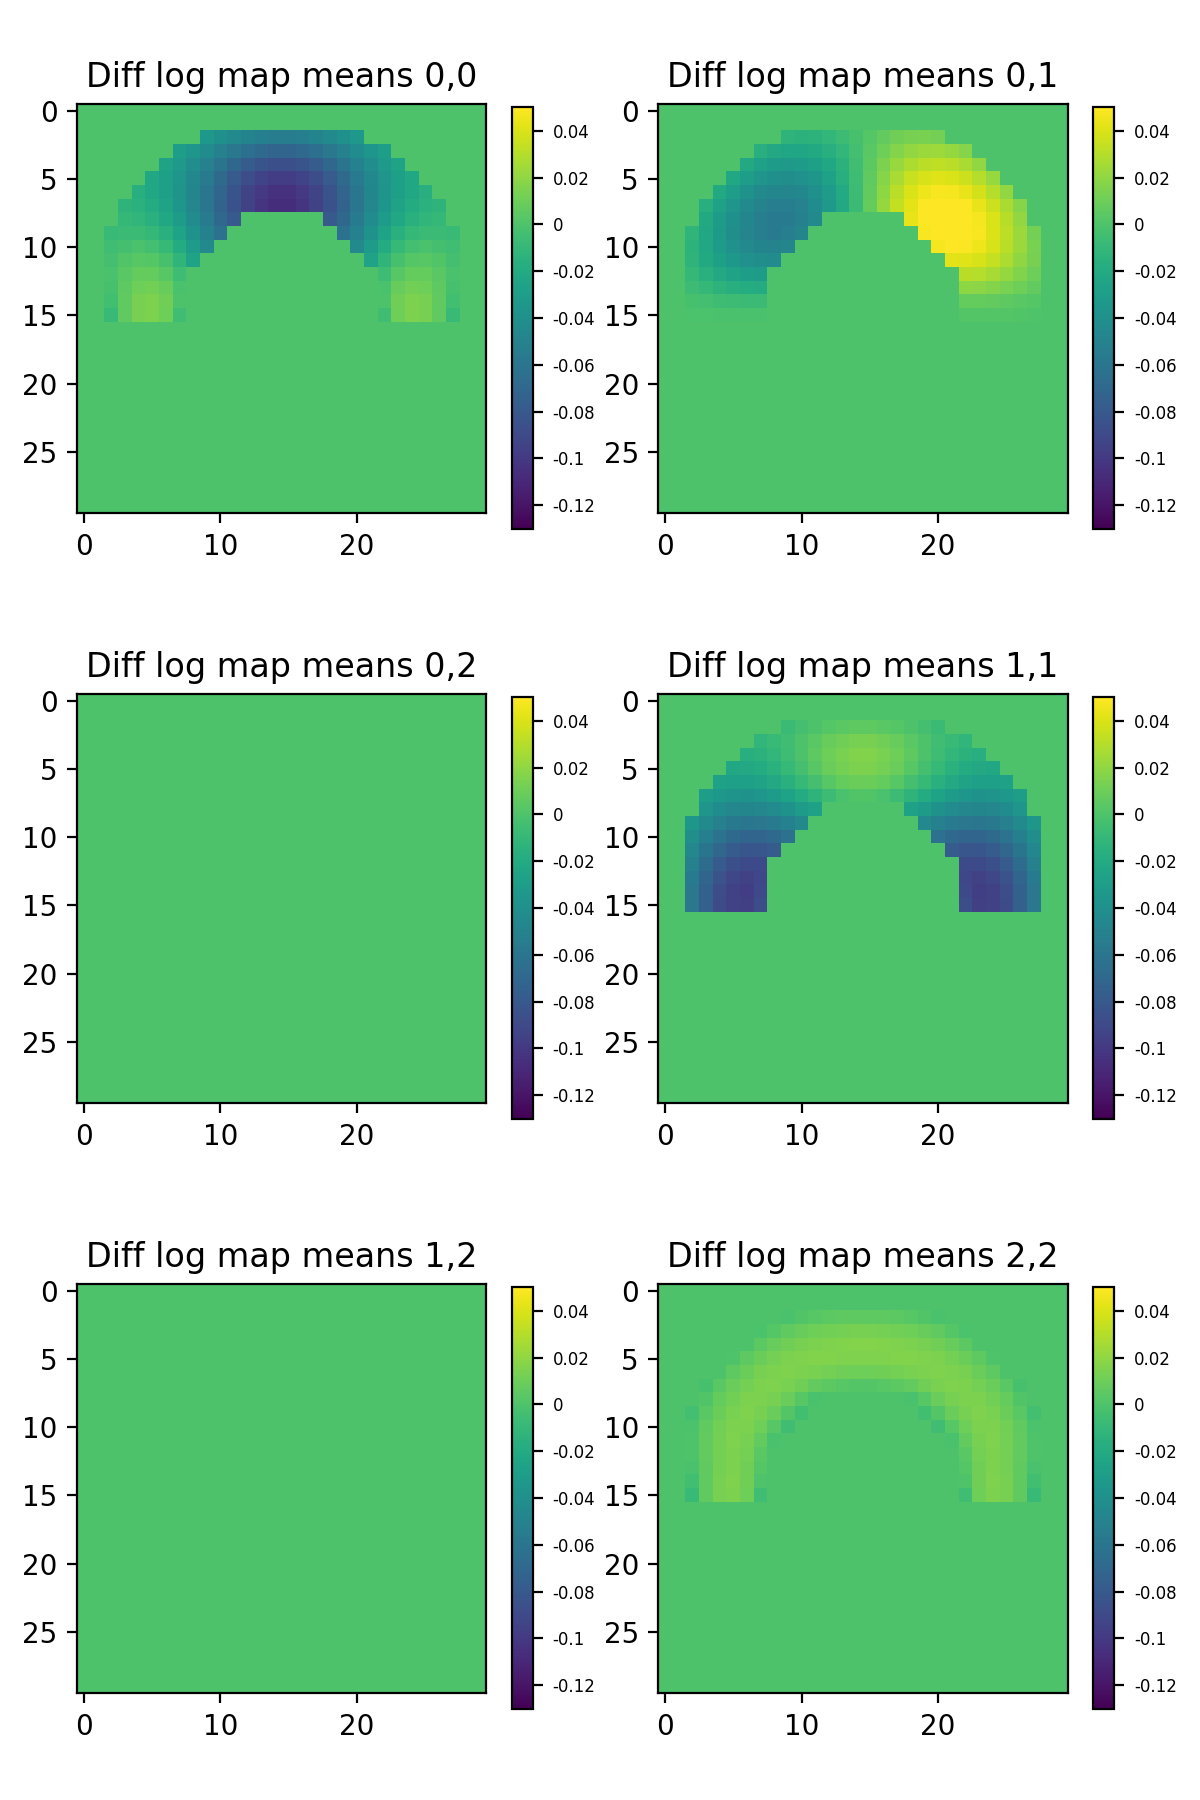

<IPython.core.display.Javascript object>


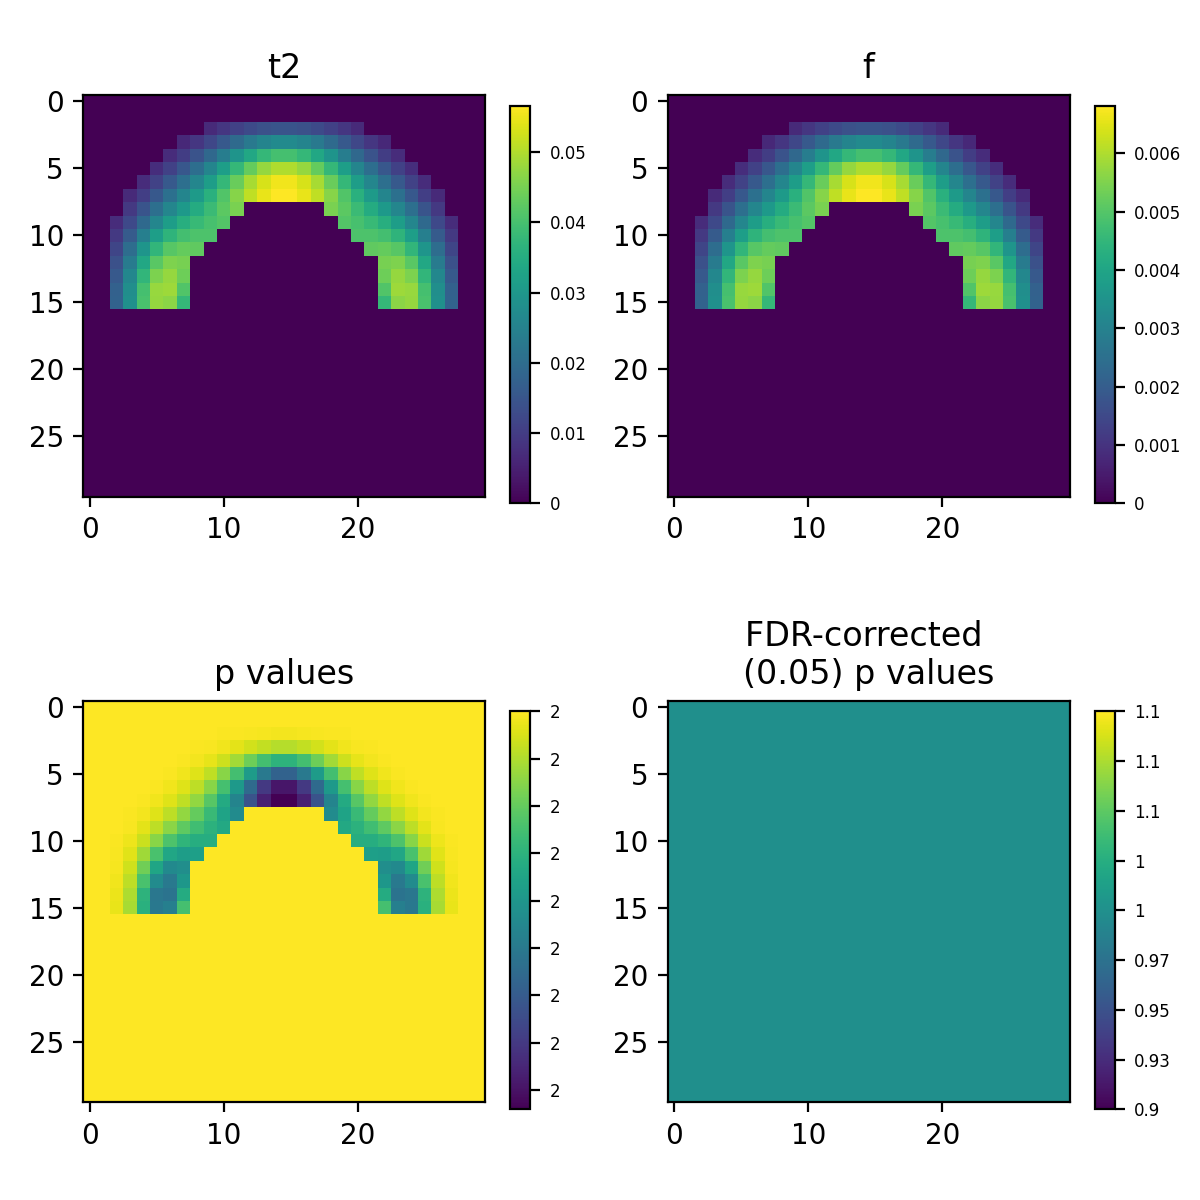

In [47]:
f, axes = plot_6_components(diffmean[2,::-1,:], 'Diff log map means',3,vmin=-0.13,vmax=0.05)


f, axes = plt.subplots(2, 2, figsize=(6,6))
im0 = axes[0,0].imshow(t2[2,::-1,:])
axes[0,0].set_title(f't2')

im1 = axes[0,1].imshow(fstat[2,::-1,:])
axes[0,1].set_title(f'f')

im2 = axes[1,0].imshow(pvals[2,::-1,:])
axes[1,0].set_title(f'p values')

im3 = axes[1,1].imshow(fdr_pvals[2,::-1,:])
axes[1,1].set_title(f'FDR-corrected \n(0.05) p values')

plt.tight_layout()

cbar=f.colorbar(im0, ax=axes[0,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im1, ax=axes[0,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im2, ax=axes[1,0],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)
cbar=f.colorbar(im3, ax=axes[1,1],anchor=(0, 0.3), shrink=0.9, format='%-.2g')
cbar.ax.tick_params(labelsize=6)

if save_figs:
  file_name = f'{figdir}/ann_1_ann_2_logmap_statistics.png'  
  f.savefig(file_name, bbox_inches='tight', pad_inches=0, 
            dpi=400, transparent=True)


# Debug nan logmap

In [21]:
def get_framework(arr):
      # return np or torch depending on type of array
    # also returns framework name as "numpy" or "torch"
    fw = None
    fw_name = ''
    if type(arr) == np.ndarray:
        fw = np
        fw_name = 'numpy'
    else:
        fw = torch
        fw_name = 'torch'
    return (fw, fw_name)

def batch_cholesky(tens):
    # from https://stackoverflow.com/questions/60230464/pytorch-torch-cholesky-ignoring-exception
    # will get NaNs instead of exception where cholesky is invalid
    fw, fw_name = get_framework(tens)
    L = fw.zeros_like(tens)

    for i in range(tens.shape[-1]):
      for j in range(i+1):
        s = 0.0
        for k in range(j):
          s = s + L[...,i,k].clone() * L[...,j,k].clone()

        L[...,i,j] = fw.sqrt((tens[...,i,i] - s).clamp(min=1.0e-15)) if (i == j) else \
                      (1.0 / L[...,j,j].clone().clamp(min=1.0e-15) * (tens[...,i,j] - s))
    return L

def make_pos_def(tens, mask, small_eval = 0.00005):
  # make any small or negative eigenvalues slightly positive and then reconstruct tensors
    #print('WARNING! Short-circuiting BrainAtlasBuilding3DUkfCudaImg.make_pos_def')
    #return(tens)

    fw, fw_name = get_framework(tens)
    det_threshold=1e-11
    tens[torch.det(tens)<=det_threshold] = fw.eye(3, dtype=tens.dtype).to(tens.device)

    if fw_name == 'numpy':
        sym_tens = (tens + tens.transpose(0,1,2,4,3))/2
        evals, evecs = np.linalg.eig(sym_tens)
    else:
        sym_tens = ((tens + torch.transpose(tens,len(tens.shape)-2,len(tens.shape)-1))/2).reshape((-1,3,3))
        # evals, evecs = torch.symeig(sym_tens,eigenvectors=True)
        #evals, evecs = se.apply(sym_tens.reshape((-1,3,3)))
        evals, evecs = se.apply(sym_tens)
    evals = evals.reshape((*tens.shape[:-2],3))
    evecs = evecs.reshape((*tens.shape[:-2],3,3))
    #cmplx_evals, cmplx_evecs = fw.linalg.eig(sym_tens)
    #evals = fw.real(cmplx_evals)""
    #evecs = fw.real(cmplx_evecs)
    #np.abs(evals, out=evals)
    idx = fw.where(evals < small_eval)
    small_map = fw.where(evals < small_eval,1,0)
    #idx = np.where(evals < 0)
    num_found = 0
    #print(len(idx[0]), 'tensors found with eigenvalues <', small_eval)
    for ee in range(len(idx[0])):
        if mask is None or mask[idx[0][ee], idx[1][ee], idx[2][ee]]:
            num_found += 1
            # If largest eigenvalue is negative, replace with identity
            eval_2 = (idx[3][ee]+1) % 3
            eval_3 = (idx[3][ee]+2) % 3
            if ((evals[idx[0][ee], idx[1][ee], idx[2][ee], eval_2] < 0) and 
             (evals[idx[0][ee], idx[1][ee], idx[2][ee], eval_3] < 0)):
                evecs[idx[0][ee], idx[1][ee], idx[2][ee]] = fw.eye(3, dtype=tens.dtype).to(tens.device)
                evals[idx[0][ee], idx[1][ee], idx[2][ee], idx[3][ee]] = small_eval
            else:
                # otherwise just set this eigenvalue to small_eval
                evals[idx[0][ee], idx[1][ee], idx[2][ee], idx[3][ee]] = small_eval

    print(num_found, 'tensors found with eigenvalues <', small_eval)
    #print(num_found, 'tensors found with eigenvalues < 0')
    mod_tens = fw.einsum('...ij,...jk,...k,...lk->...il',
                       evecs, fw.eye(3, dtype=tens.dtype).to(tens.device), evals, evecs)
    #mod_tens = fw.einsum('...ij,...j,...jk->...ik',
    #                     evecs, evals, evecs)

    print("WARNING!!!! Overriding small_eval fix in BrainAtlasBuilding3DUkfCudaImg.make_pos_def")
    mod_tens = tens.clone()
    chol = batch_cholesky(mod_tens)
    idx_nan = torch.where(torch.isnan(chol))
    nan_map = torch.where(torch.isnan(chol),1,0)
    iso_tens = small_eval * fw.eye(3, dtype=tens.dtype).to(tens.device)
    for pt in range(len(idx_nan[0])):
        mod_tens[idx_nan[0][pt],idx_nan[1][pt],idx_nan[2][pt]] = iso_tens
    # if torch.norm(torch.transpose(mod_tens,3,4)-mod_tens)>0:
    #     print('asymmetric')
    #mod_tens[:,:,:,1,0]=mod_tens[:,:,:,0,1]
    #mod_tens[:,:,:,2,0]=mod_tens[:,:,:,0,2]
    #mod_tens[:,:,:,2,1]=mod_tens[:,:,:,1,2]
    mod_sym_tens = (mod_tens + torch.transpose(mod_tens,len(mod_tens.shape)-2,len(mod_tens.shape)-1))/2
    mod_sym_tens[torch.det(mod_sym_tens)<=det_threshold] = fw.eye(3, dtype=tens.dtype).to(tens.device)
    return(mod_sym_tens)


In [22]:
aten = np.zeros((2,3,3))
aten[:,0,0] = 3.6354283
aten[:,1,0] = aten[:,0,1] = 0.8350466
aten[:,1,1] = 0.94213066
aten[:,2,2] = 0.70423984
g1ten = np.zeros((2,3,3))
g1ten[:,0,0] = 4.83940975
g1ten[:,1,0] = g1ten[:,0,1] = 1.09917246
g1ten[:,1,1] = 1.29422004
g1ten[:,2,2] = 0.9775428
print(aten,'\n',g1ten)
amet = torch.from_numpy(np.linalg.inv(aten))
g1met = torch.from_numpy(np.linalg.inv(g1ten))
print(amet.shape)
u1 = inv_RieExp_extended(g1met.reshape((-1,3,3)), amet.reshape((-1,3,3)), 1.0 / 3.0).reshape((2,3,3))


[[[3.6354283  0.8350466  0.        ]
  [0.8350466  0.94213066 0.        ]
  [0.         0.         0.70423984]]

 [[3.6354283  0.8350466  0.        ]
  [0.8350466  0.94213066 0.        ]
  [0.         0.         0.70423984]]] 
 [[[4.83940975 1.09917246 0.        ]
  [1.09917246 1.29422004 0.        ]
  [0.         0.         0.9775428 ]]

 [[4.83940975 1.09917246 0.        ]
  [1.09917246 1.29422004 0.        ]
  [0.         0.         0.9775428 ]]]
torch.Size([2, 3, 3])


In [32]:
ctens = ReadTensors(f'/usr/sci/projects/abcd/simresults/3d_cubics/noshapeImg/metpy_3D_cubic1_6_scaled_orig_tensors_v2.nhdr')
catlastens = ReadTensors(f'/usr/sci/projects/abcd/simresults/3d_cubics/noshapeImg/metpy_3D_cubic_1_2_mean_scaled_orig_tensors_v2.nhdr')
catlasmask = ReadScalars(f'/usr/sci/projects/abcd/simresults/3d_cubics/noshapeImg/metpy_3D_cubic_1_2_mean_orig_mask.nhdr')
ctens_full = tens_6_to_tens_3x3(ctens)
catlastens_full = tens_6_to_tens_3x3(catlastens)
#td='cpu'
td=device
cmet = make_pos_def(torch.pinverse(torch.from_numpy(ctens_full).to(td)),torch.from_numpy(catlasmask).double(),1e-10)
#cmet = make_pos_def(torch.from_numpy(np.linalg.inv(ctens_full)),None,1e-10)
catlasmet = make_pos_def(torch.pinverse(torch.from_numpy(catlastens_full).to(td)),torch.from_numpy(catlasmask).double(),1e-10)
print(cmet.shape,catlasmet.shape)
cheight, cwidth, cdepth = catlasmet.shape[0:3]


0 tensors found with eigenvalues < 1e-10
WARNING!!!! Overriding small_eval fix in BrainAtlasBuilding3DUkfCudaImg.make_pos_def
0 tensors found with eigenvalues < 1e-10
WARNING!!!! Overriding small_eval fix in BrainAtlasBuilding3DUkfCudaImg.make_pos_def
torch.Size([60, 60, 27, 3, 3]) torch.Size([60, 60, 27, 3, 3])


In [33]:
u1 = inv_RieExp_extended(catlasmet.reshape((-1,3,3)), cmet.reshape((-1,3,3)), 1.0 / 3.0).reshape((cheight,cwidth,cdepth,3,3))


In [34]:
print(torch.sum(torch.isnan(u1)))
idx = torch.where(torch.isnan(u1))
print(idx)
print(u1.device)

tensor(0)
(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64), tensor([], dtype=torch.int64), tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))
cuda:0


In [170]:
print(u1[23,27,14])
print(cmet[23,27,14])
print(catlasmet[23,27,14])

tensor([[-0.0765,  0.0671,  0.0000],
        [ 0.1402, -0.1070,  0.0000],
        [ 0.0000,  0.0000, -0.2325]], device='cpu')
tensor([[ 0.5829, -0.5017,  0.0000],
        [-0.5017,  1.3851,  0.0000],
        [ 0.0000,  0.0000,  1.6145]], device='cpu')
tensor([[ 0.6167, -0.5874,  0.0000],
        [-0.5874,  1.5560,  0.0000],
        [ 0.0000,  0.0000,  1.8384]], device='cpu')


In [173]:
usingle = inv_RieExp_extended(catlasmet[23,27,14].reshape((-1,3,3)), cmet[23,27,14].reshape((-1,3,3)), 1.0 / 3.0).reshape((1,1,1,3,3))
print(usingle)

tensor([[[[[nan, nan, nan],
           [nan, nan, nan],
           [nan, nan, nan]]]]], device='cpu')


In [35]:
lm = dbg_logm_invB_A(catlasmet[23,27,14].reshape((-1,3,3)), cmet[23,27,14].reshape((-1,3,3))).reshape((1,1,1,3,3))
print(lm)

W tensor([[[0.9452, 0.0682, 0.0000],
         [0.0682, 0.9616, 0.0000],
         [0.0000, 0.0000, 0.8782]]])
se.apply
evecs tensor([[[ 0.6635, -0.0000, -0.7482],
         [ 0.7482, -0.0000,  0.6635],
         [ 0.0000,  1.0000,  0.0000]]])
evals tensor([[1.0221, 0.8847, 0.8782]])
tensor([[[[[-6.6508e-03,  5.9269e-02,  7.6968e-18],
           [ 5.9269e-02, -1.0142e-01, -1.6007e-17],
           [ 7.2601e-18, -1.5099e-17, -1.2254e-01]]]]])


In [185]:
catlasmet[23,27,14].device

device(type='cuda', index=0)

In [ ]:
se.apply
evecs tensor([[[0.6635,    nan, 0.0000],
         [0.7482,    nan, 0.0000],
         [0.0000,    nan, 1.0000]]], device='cpu')
evals tensor([[1.0221, 0.8847, 0.8782]], device='cpu')
torch.symeig
evecs tensor([[[ 0.0000, -0.7482,  0.6635],
         [ 0.0000,  0.6635,  0.7482],
         [ 1.0000,  0.0000,  0.0000]]], device='cpu')
evals tensor([[0.8782, 0.8847, 1.0221]], device='cpu')
tensor([[[[[-0.0053,  0.0564,  0.0000],
           [ 0.0564, -0.0954,  0.0000],
           [ 0.0000,  0.0000, -0.1299]]]]], device='cpu')

W tensor([[[0.9452, 0.0682, 0.0000],
         [0.0682, 0.9616, 0.0000],
         [0.0000, 0.0000, 0.8782]]])
se.apply
evecs tensor([[[0.6635, -0.0000, 0.0000],
         [0.7482, -0.0000, 0.0000],
         [0.0000, 1.0000, 1.0000]]])
evals tensor([[1.0221, 0.8847, 0.8782]])
tensor([[[[[ 0.0341,  0.0000,  0.0000],
           [ 0.0164,  0.0000,  0.0000],
           [ 0.0000, -0.0904,  0.0958]]]]])

# after fix
W tensor([[[0.9452, 0.0682, 0.0000],
         [0.0682, 0.9616, 0.0000],
         [0.0000, 0.0000, 0.8782]]])
se.apply
evecs tensor([[[ 0.6635,  0.0000, -0.7482],
         [ 0.7482,  0.0000,  0.6635],
         [ 0.0000,  1.0000,  0.0000]]])
evals tensor([[1.0221, 0.8847, 0.8782]])
tensor([[[[[-6.6508e-03,  5.9269e-02,  7.6968e-18],
           [ 5.9269e-02, -1.0142e-01, -1.6007e-17],
           [ 7.2601e-18, -1.5099e-17, -1.2254e-01]]]]])

W tensor([[[ 0.5829, -0.5017,  0.0000],
         [-0.5017,  1.3851,  0.0000],
         [ 0.0000,  0.0000,  1.6145]]], device='cpu')
se.apply
evecs tensor([[[-0.4333, -0.0000,  0.9012],
         [ 0.9012, -0.0000,  0.4333],
         [-0.0000,  1.0000, -0.0000]]], device='cpu')
evals tensor([[1.6264, 1.6145, 0.3416]], device='cpu')
tensor([[[[[-0.7810, -0.6094,  0.0000],
           [-0.6094,  0.1934,  0.0000],
           [ 0.0000,  0.0000,  0.4790]]]]], device='cpu')

# after removing nan fix in cpu
W tensor([[[0.9452, 0.0682, 0.0000],
         [0.0682, 0.9616, 0.0000],
         [0.0000, 0.0000, 0.8782]]])
se.apply
evecs tensor([[[ 0.6635, -0.0000, -0.7482],
         [ 0.7482, -0.0000,  0.6635],
         [ 0.0000,  1.0000,  0.0000]]])
evals tensor([[1.0221, 0.8847, 0.8782]])
tensor([[[[[-6.6508e-03,  5.9269e-02,  7.6968e-18],
           [ 5.9269e-02, -1.0142e-01, -1.6007e-17],
           [ 7.2601e-18, -1.5099e-17, -1.2254e-01]]]]])



In [28]:
W=torch.tensor([[[0.9452, 0.0682, 0.0000],
         [0.0682, 0.9616, 0.0000],
         [0.0000, 0.0000, 0.8782]]])
torch.det(W)
torch.symeig(W,eigenvectors=True)

torch.return_types.symeig(
eigenvalues=tensor([[0.8782, 0.8847, 1.0221]]),
eigenvectors=tensor([[[ 0.0000, -0.7481,  0.6636],
         [ 0.0000,  0.6636,  0.7481],
         [ 1.0000,  0.0000,  0.0000]]]))

In [203]:
0.8847-0.8782

0.006500000000000061

In [29]:
td='cpu'
td=device
tm = torch.clone(W).to(td)

m_idx=0
v_idx=0

x11 = tm[0,0, 0].to(td)
x12 = tm[0,0, 1].to(td)
x13 = tm[0,0, 2].to(td)
x21 = tm[0,1, 0].to(td)
x22 = tm[0,1, 1].to(td)
x23 = tm[0,1, 2].to(td)
x31 = tm[0,2, 0].to(td)
x32 = tm[0,2, 1].to(td)
x33 = tm[0,2, 2].to(td)
                                      
p1 = x12 * x12 + x13 * x13 + x23 * x23

eig_val_data = torch.zeros((3,1)).to(td)
eig_vec_data = torch.zeros((3,3)).to(td)
    
if (p1 == 0) :
 eig_val_data[v_idx + 0] = x11
 eig_val_data[v_idx + 1] = x22
 eig_val_data[v_idx + 2] = x33
else :
 q = (x11 + x22 + x33) / 3.0
 p2 = (x11 - q) * (x11 - q) + (x22 - q) * (x22 - q) + (x33 - q) * (x33 - q) + 2.0 * p1
 p = torch.sqrt(p2 / 6.0)

 b11 = (1.0 / p) * (x11 - q)
 b12 = (1.0 / p) * x12
 b13 = (1.0 / p) * x13
 b21 = (1.0 / p) * x21
 b22 = (1.0 / p) * (x22 - q)
 b23 = (1.0 / p) * x23
 b31 = (1.0 / p) * x31
 b32 = (1.0 / p) * x32
 b33 = (1.0 / p) * (x33 - q)

 r = b11 * b22 * b33 + b12 * b23 * b31 + b13 * b21 * b32 - \
     b13 * b22 * b31 - b12 * b21 * b33 - b11 * b23 * b32
 r = r / 2.0

 if (r <= -1):
   phi = np.pi / 3.0
 elif (r >= 1):
   phi = 0
 else:
   phi = torch.acos(r) / 3.0

 eig_val_data[v_idx + 0] = q + 2 * p * torch.cos(phi)
 eig_val_data[v_idx + 2] = q + 2 * p * torch.cos(phi + (2 * np.pi / 3))
 eig_val_data[v_idx + 1] = 3 * q - eig_val_data[v_idx + 0] - eig_val_data[v_idx + 2]

for e_it in range(3):
   e = e_it
   x11 = tm[0, 0, 0] - eig_val_data[e]
   x12 = tm[0, 0, 1]
   x13 = tm[0, 0, 2]
   x21 = tm[0, 1, 0]
   x22 = tm[0, 1, 1] - eig_val_data[e]
   x23 = tm[0, 1, 2]
   x31 = tm[0, 2, 0]
   x32 = tm[0, 2, 1]
   x33 = tm[0, 2, 2] - eig_val_data[e]

   r12_1 = x12 * x23 - x13 * x22
   r12_2 = x13 * x21 - x11 * x23
   r12_3 = x11 * x22 - x12 * x21
   r13_1 = x12 * x33 - x13 * x32
   r13_2 = x13 * x31 - x11 * x33
   r13_3 = x11 * x32 - x12 * x31
   r23_1 = x22 * x33 - x23 * x32
   r23_2 = x23 * x31 - x21 * x33
   r23_3 = x21 * x32 - x22 * x31

   d1 = r12_1 * r12_1 + r12_2 * r12_2 + r12_3 * r12_3
   d2 = r13_1 * r13_1 + r13_2 * r13_2 + r13_3 * r13_3
   d3 = r23_1 * r23_1 + r23_2 * r23_2 + r23_3 * r23_3

   d_max = d1
   i_max = 0
   eps = 1.0e-6

   if (d2 > d_max + eps):
     d_max = d2
     i_max = 1

   if (d3 > d_max + eps):
     i_max = 2

   if (e_it == 0):
     eig_vec_data[0, e_it] = 1
     eig_vec_data[1, e_it] = 0
     eig_vec_data[2, e_it] = 0
   elif (e_it == 1):
     eig_vec_data[0, e_it] = 0
     eig_vec_data[1, e_it] = 1
     eig_vec_data[2, e_it] = 0
   else:
     eig_vec_data[0, e_it] = 0
     eig_vec_data[1, e_it] = 0
     eig_vec_data[2, e_it] = 1

   if (i_max == 0):
     eig_vec_data[0, e_it] = r12_1 / torch.sqrt(d1)
     eig_vec_data[1, e_it] = r12_2 / torch.sqrt(d1)
     eig_vec_data[2, e_it] = r12_3 / torch.sqrt(d1)
   elif (i_max == 1):
     eig_vec_data[0, e_it] = r13_1 / torch.sqrt(d2)
     eig_vec_data[1, e_it] = r13_2 / torch.sqrt(d2)
     eig_vec_data[2, e_it] = r13_3 / torch.sqrt(d2)
   else:
     eig_vec_data[0, e_it] = r23_1 / torch.sqrt(d3)
     eig_vec_data[1, e_it] = r23_2 / torch.sqrt(d3)
     eig_vec_data[2, e_it] = r23_3 / torch.sqrt(d3)

   if ((eig_vec_data[0, e_it] +
        eig_vec_data[1, e_it] +
        eig_vec_data[2, e_it]) <= eps):
     eig_vec_data[0, e_it] = -eig_vec_data[0, e_it]
     eig_vec_data[1, e_it] = -eig_vec_data[1, e_it]
     eig_vec_data[2, e_it] = -eig_vec_data[2, e_it]

error = 1e-2
if(torch.abs(eig_val_data[v_idx + 0]-eig_val_data[v_idx + 1]) < error and 
   torch.abs(eig_val_data[v_idx + 0]-eig_val_data[v_idx + 2]) > error):
  print('case1')  
  v_1 = eig_vec_data[0, 1]
  v_2 = eig_vec_data[1, 1]
  v_3 = eig_vec_data[2, 1]
  c_1 = tm[0, 0, 0] - eig_val_data[v_idx + 0]
  c_2 = tm[0, 1, 1]
  c_3 = tm[0, 2, 2]

  eig_vec_data[0, 0] = v_2 * c_3-c_2 * v_3
  eig_vec_data[1, 0] = v_3 * c_1-c_3 * v_1
  eig_vec_data[2, 0] = v_1 * c_2-c_1 * v_2
  norm = torch.sqrt(torch.pow(eig_vec_data[0, 0], 2)+
                    torch.pow(eig_vec_data[1, 0], 2)+
                    torch.pow(eig_vec_data[2, 0], 2))
  eig_vec_data[0, 0] /= norm
  eig_vec_data[1, 0] /= norm
  eig_vec_data[2, 0] /= norm

if(torch.abs(eig_val_data[v_idx + 1]-eig_val_data[v_idx + 2]) < error and 
   torch.abs(eig_val_data[v_idx + 0]-eig_val_data[v_idx + 1]) > error):
  print('case2')  
  v_1 = eig_vec_data[0, 2]
  v_2 = eig_vec_data[1, 2]
  v_3 = eig_vec_data[2, 2]
  c_1 = tm[0, 0, 0]
  c_2 = tm[0, 1, 1]
  c_3 = tm[0, 2, 2] - eig_val_data[v_idx + 1]

  eig_vec_data[0, 1] = v_2 * c_3-c_2 * v_3
  eig_vec_data[1, 1] = v_3 * c_1-c_3 * v_1
  eig_vec_data[2, 1] = v_1 * c_2-c_1 * v_2
  norm = torch.sqrt(torch.pow(eig_vec_data[0, 1], 2)+
                    torch.pow(eig_vec_data[1, 1], 2)+
                    torch.pow(eig_vec_data[2, 1], 2))
  eig_vec_data[0, 1] /= norm
  eig_vec_data[1, 1] /= norm
  eig_vec_data[2, 1] /= norm

if(torch.abs(eig_val_data[v_idx + 0]-eig_val_data[v_idx + 2]) < error and
   torch.abs(eig_val_data[v_idx + 0]-eig_val_data[v_idx + 1]) > error):
  print('case3')  
  v_1 = eig_vec_data[0, 2]
  v_2 = eig_vec_data[1, 2]
  v_3 = eig_vec_data[2, 2]
  c_1 = tm[0, 0, 0] - eig_val_data[v_idx + 2]
  c_2 = tm[0, 1, 1]
  c_3 = tm[0, 2, 2]

  eig_vec_data[0, 0] = v_2 * c_3-c_2 * v_3
  eig_vec_data[1, 0] = v_3 * c_1-c_3 * v_1
  eig_vec_data[2, 0] = v_1 * c_2-c_1 * v_2
  norm = torch.sqrt(torch.pow(eig_vec_data[0, 0], 2)+
                    torch.pow(eig_vec_data[1, 0], 2)+
                    torch.pow(eig_vec_data[2, 0], 2))
  eig_vec_data[0, 0] /= norm
  eig_vec_data[1, 0] /= norm
  eig_vec_data[2, 0] /= norm


case2


In [30]:
print(eig_val_data)
print(eig_vec_data)

tensor([[1.0221],
        [0.8847],
        [0.8782]])
tensor([[ 0.6636, -0.7132,  0.0000],
        [ 0.7481,  0.7010,  0.0000],
        [ 0.0000,  0.0000,  1.0000]])


In [31]:
eig_vec_data.device

device(type='cuda', index=0)